### Viz - Overall - Annual

/tmp/ipykernel_3066/1810481515.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['months_diff'] = (
/tmp/ipykernel_3066/1810481515.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['period'] = filtered_data['months_diff'] // 12


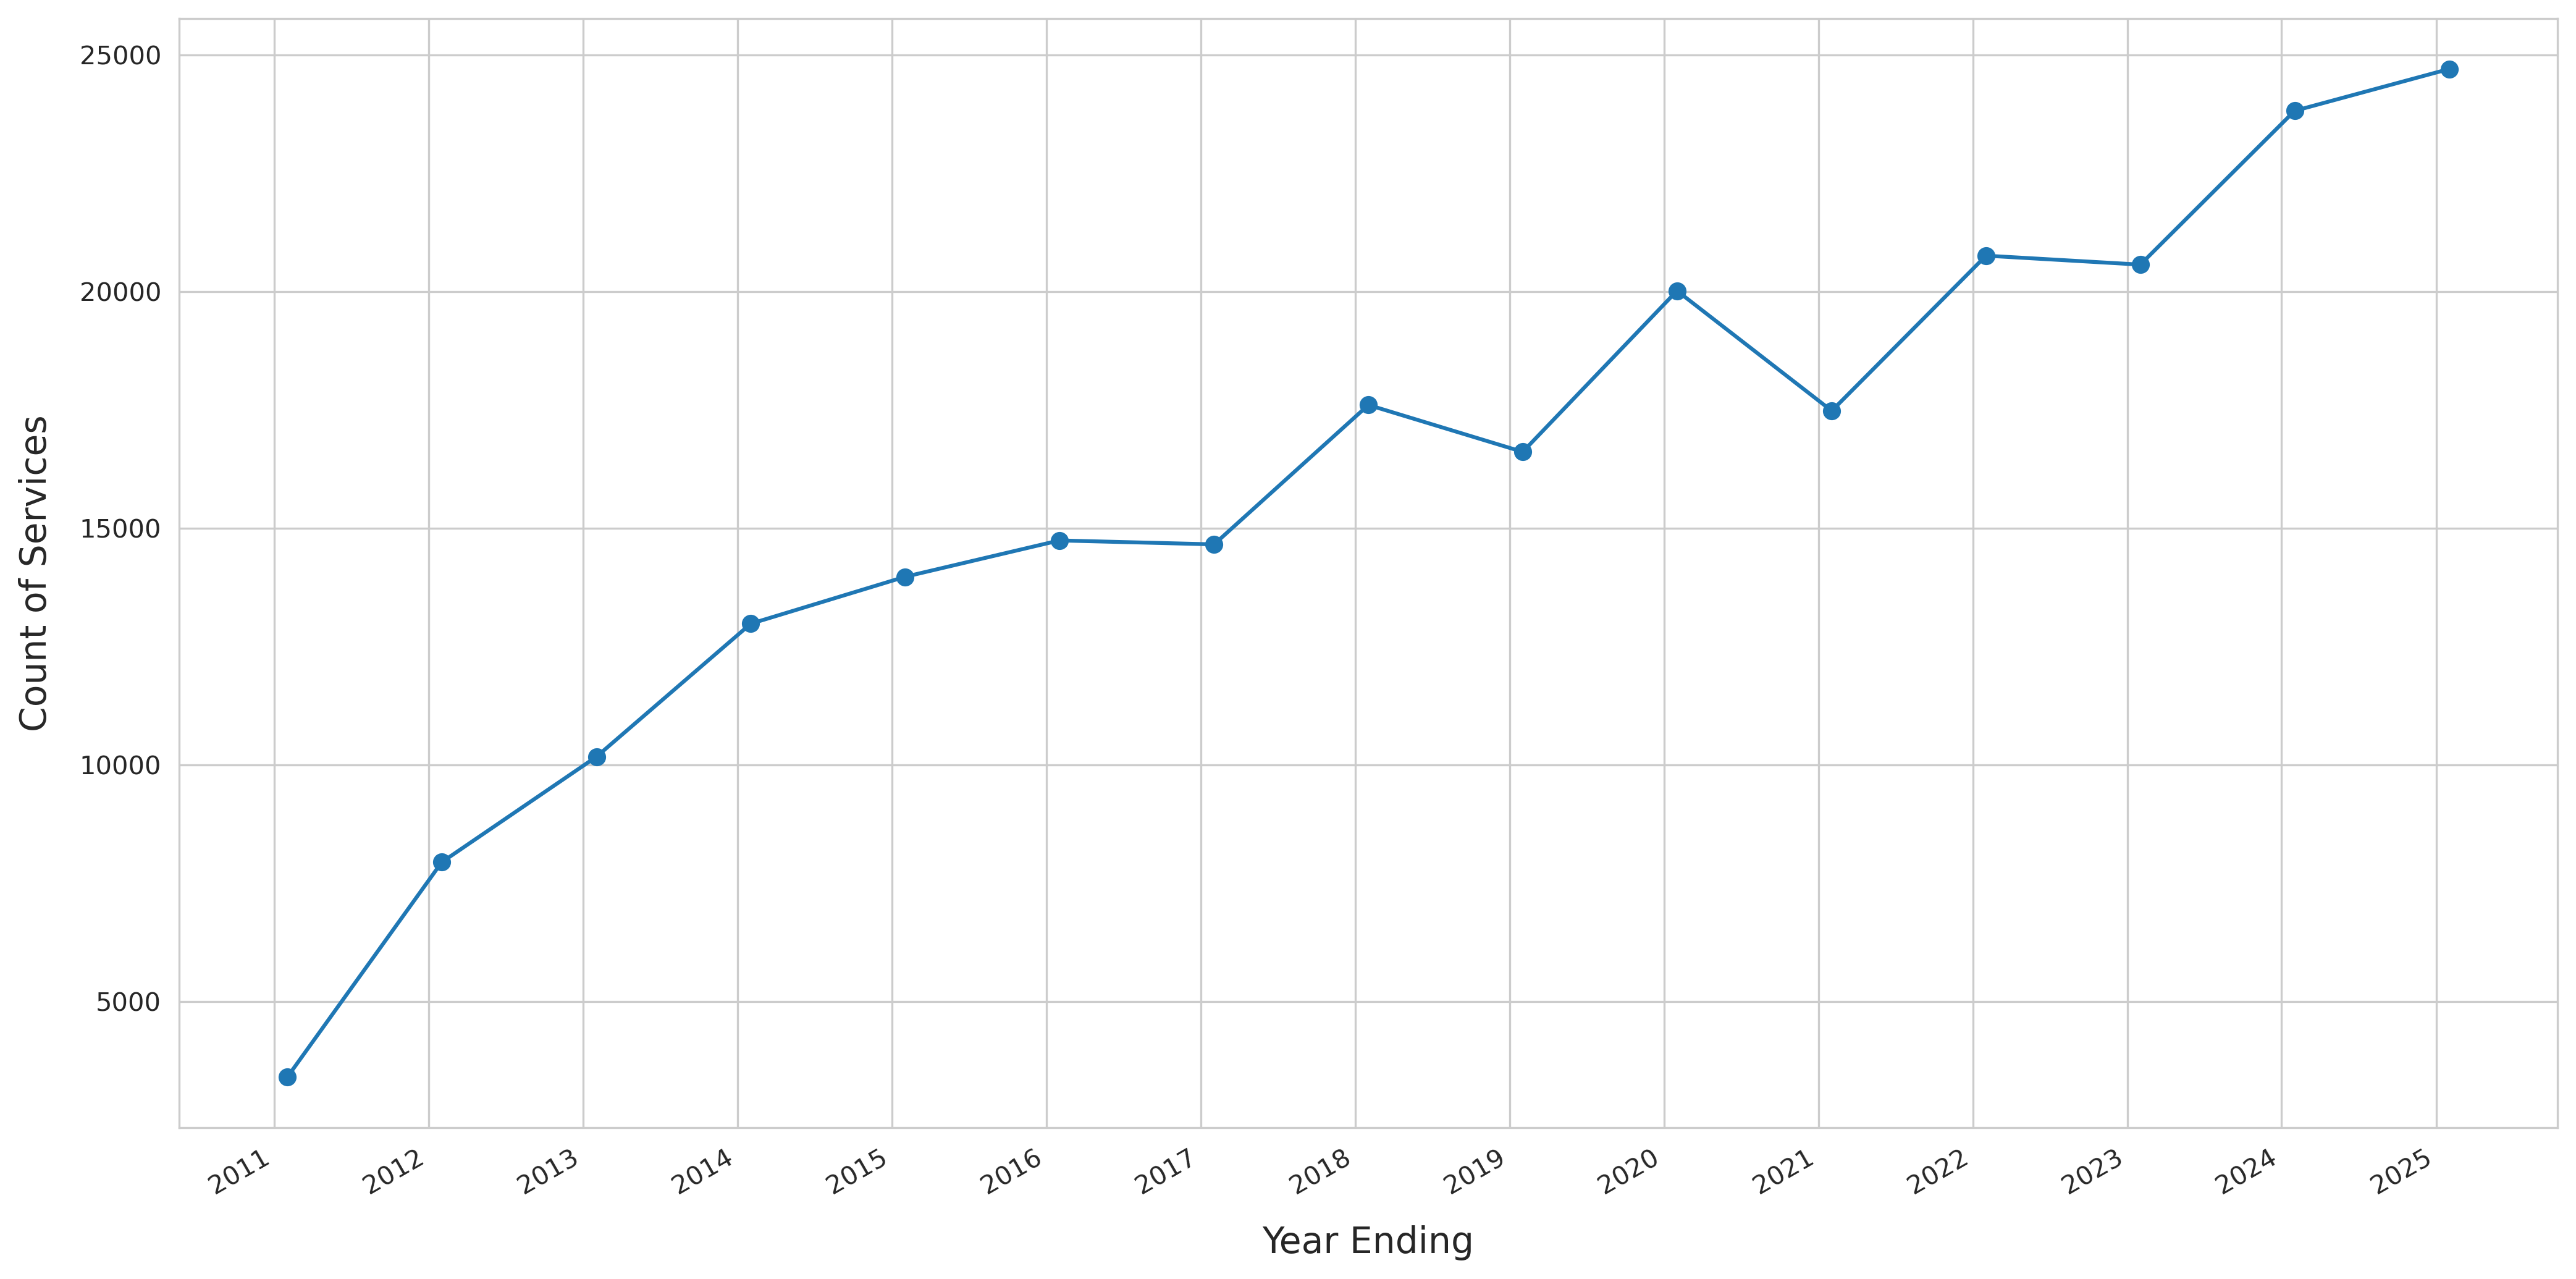

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Convert 'Month' column to datetime (using the month period) and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73292', '73298', '73299', '73358', '73359',
    '73360', '73395', '73401', '73402', '73416',
    '73422', '73425', '73426', '73440', '73440', 
    '73441', '73444', '73456', '73457', '73460'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# -- Grouping data in 12-month blocks starting from the most recent date --

# 1. Determine the most recent date (this will be the end of the most recent complete year)
last_date = filtered_data.index.max()

# 2. For each observation, compute the difference in months from the last_date.
#    (This converts the date difference into full months.)
filtered_data['months_diff'] = (
    (last_date.year - filtered_data.index.year) * 12 + (last_date.month - filtered_data.index.month)
)

# 3. Define the period as the integer division of months_diff by 12.
#    Period 0 is the most recent 12-month block, period 1 is the preceding block, etc.
filtered_data['period'] = filtered_data['months_diff'] // 12

# 4. (Optional) Ensure the most recent period contains a full 12 months.
#    If period 0 is incomplete, you may decide to exclude it.
period_counts = filtered_data.groupby('period').size()
if period_counts.loc[0] < 12:
    # Remove observations from period 0 if it does not have a full year.
    filtered_data = filtered_data[filtered_data['period'] != 0]

# 5. Aggregate the 'Value' by these 12-month periods.
annual_data = filtered_data.groupby('period')['Value'].sum()

# 6. Create a new index for annual_data representing the "year-end" date for each block.
#    For period k, the corresponding year-end is last_date minus k years.
annual_data.index = [last_date - pd.DateOffset(years=int(k)) for k in annual_data.index]
annual_data = annual_data.sort_index()  # Sort by increasing date

# -- Plotting --
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)  # Higher DPI for better print quality

ax.plot(annual_data.index, annual_data, marker='o', linestyle='-', color='#1f77b4')

# Labels and axis formatting
ax.set_xlabel('Year Ending', fontsize=14, labelpad=10)
ax.set_ylabel('Count of Services', fontsize=14, labelpad=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate and format the x-axis labels for clarity
fig.autofmt_xdate()
plt.tight_layout()

# Display inline in Jupyter Notebook
plt.show()

# -- Save the figure as an SVG --
fig.savefig("AnnualValuePlot.svg", format='svg', dpi=300)


### Viz - By Group - 6M Moving Average

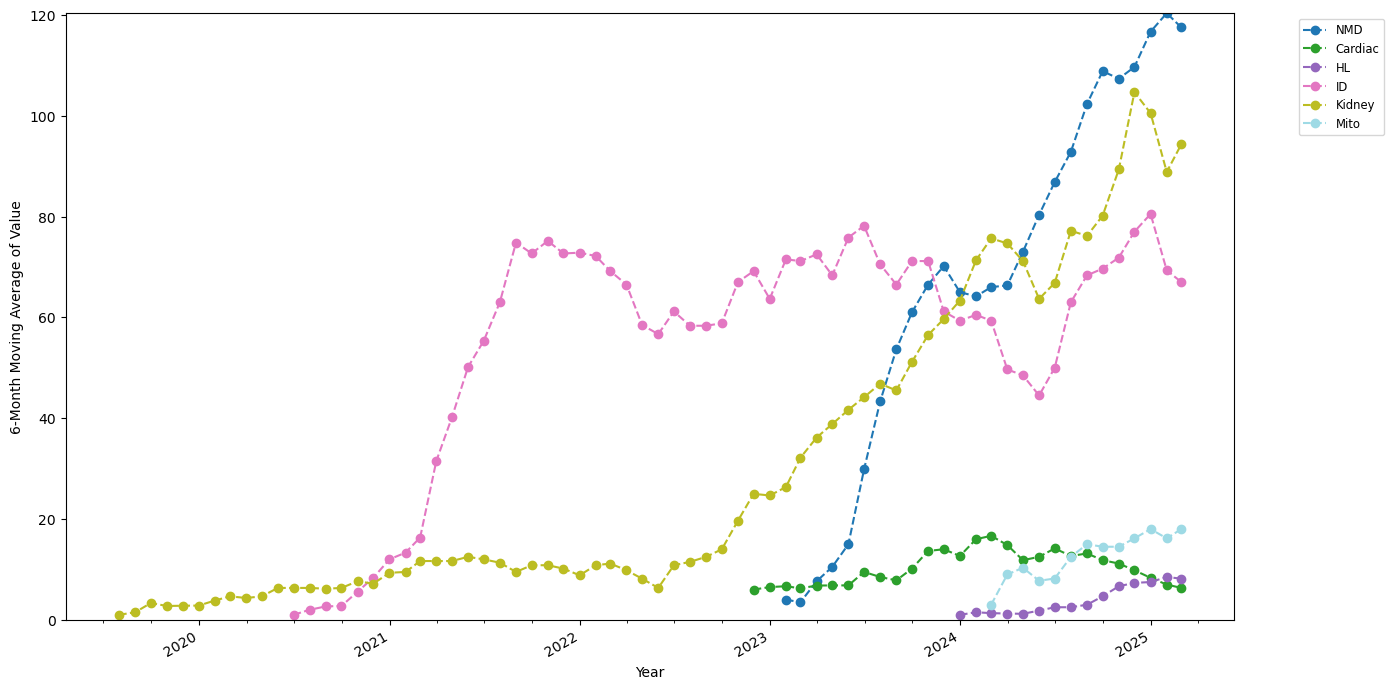

Plot saved as: MonthlySum_MA_SelectedItems.svg


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define the items to include, dropping KT-NB (73287), KT-BL (73289), CMA (73292) and FMR1 (73300)
items_to_include = [
    '73298',        # Kidney group member
    '73358', '73359',  # CS group members
    '73401', '73402',  # Kidney group members
    '73422',        # NMD (individual item)
    # New groups:
    '73456', '73457', '73460',  # Mitochondrial group
    '73440', '73441', '73444',  # Hearing Loss group
    '73416'         # Cardiac group
]

# Use .copy() to ensure a proper independent DataFrame to avoid SettingWithCopyWarning.
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# Define group mappings:
# Kidney group includes: 73298, 73401, 73402
# CS group includes: 73358, 73359
# Mitochondrial group includes: 73456, 73457, 73460
# Hearing Loss group includes: 73440, 73441, 73444
# Cardiac group includes: 73416
group_mapping = {
    'Kidney': ['73298', '73401', '73402'],
    'ID': ['73358', '73359'],
    'Mito': ['73456', '73457', '73460'],
    'HL': ['73440', '73441', '73444'],
    'Cardiac': ['73416']
}

# Function to assign a group if the item is in one; otherwise, return the original item.
def assign_group(item):
    for group, items in group_mapping.items():
        if item in items:
            return group
    return item

# Use .loc for assignment to avoid SettingWithCopyWarning.
filtered_data.loc[:, 'Group'] = filtered_data['Item'].apply(assign_group)

# Group the data by the new 'Group' column and resample by month-end.
grouped_data = filtered_data.groupby('Group').resample('ME')['Value'].sum()

# Compute a 6-month moving average for each group.
ma_dict = {}
for group in grouped_data.index.get_level_values(0).unique():
    group_series = grouped_data.loc[group]
    # Compute the moving average with a window of 6 months (min_periods=1 ensures early months are included)
    ma_series = group_series.rolling(window=6, min_periods=1).mean()
    ma_dict[group] = ma_series

# --- Modification to ensure new groups appear ---
# List of expected groups from the mapping.
expected_groups = list(group_mapping.keys())
# Get the full range of dates based on filtered_data using month-end frequency ('ME')
date_range = pd.date_range(filtered_data.index.min(), filtered_data.index.max(), freq='ME')

# For any expected group missing in the moving average dictionary, create a series of 0's.
for group in expected_groups:
    if group not in ma_dict:
        # Create a series of zeros with the full date range.
        ma_dict[group] = pd.Series(0, index=date_range)
# --- End Modification ---

# Determine the global y-axis limits based on the moving average values.
y_max = max(series.max() for series in ma_dict.values())
y_min = 0  # Assuming y-axis starts at 0

# Create the plot for the moving average only.
plt.figure(figsize=(14, 7))

unique_groups = list(ma_dict.keys())
num_groups = len(unique_groups)
# Use plt.get_cmap instead of plt.cm.get_cmap to avoid MatplotlibDeprecationWarning.
colors = plt.get_cmap('tab20', num_groups)

# Optional: custom titles for ungrouped items (e.g. NMD)
custom_titles = {
    '73422': 'NMD'
}

for idx, group in enumerate(unique_groups):
    ma_series = ma_dict[group]
    label = custom_titles.get(group, group)
    plt.plot(ma_series.index, ma_series, marker='o', linestyle='--', color=colors(idx), label=label)

plt.xlabel('Year')
plt.ylabel('6-Month Moving Average of Value')
plt.ylim([y_min, y_max])

# Format the x-axis ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Place the legend outside the plot area for clarity
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

plt.tight_layout()

# Save the figure as an SVG file for publication-quality output
output_file = "MonthlySum_MA_SelectedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)
plt.show()

print(f"Plot saved as: {output_file}")


### Viz - Pred vs Actual - Grouped

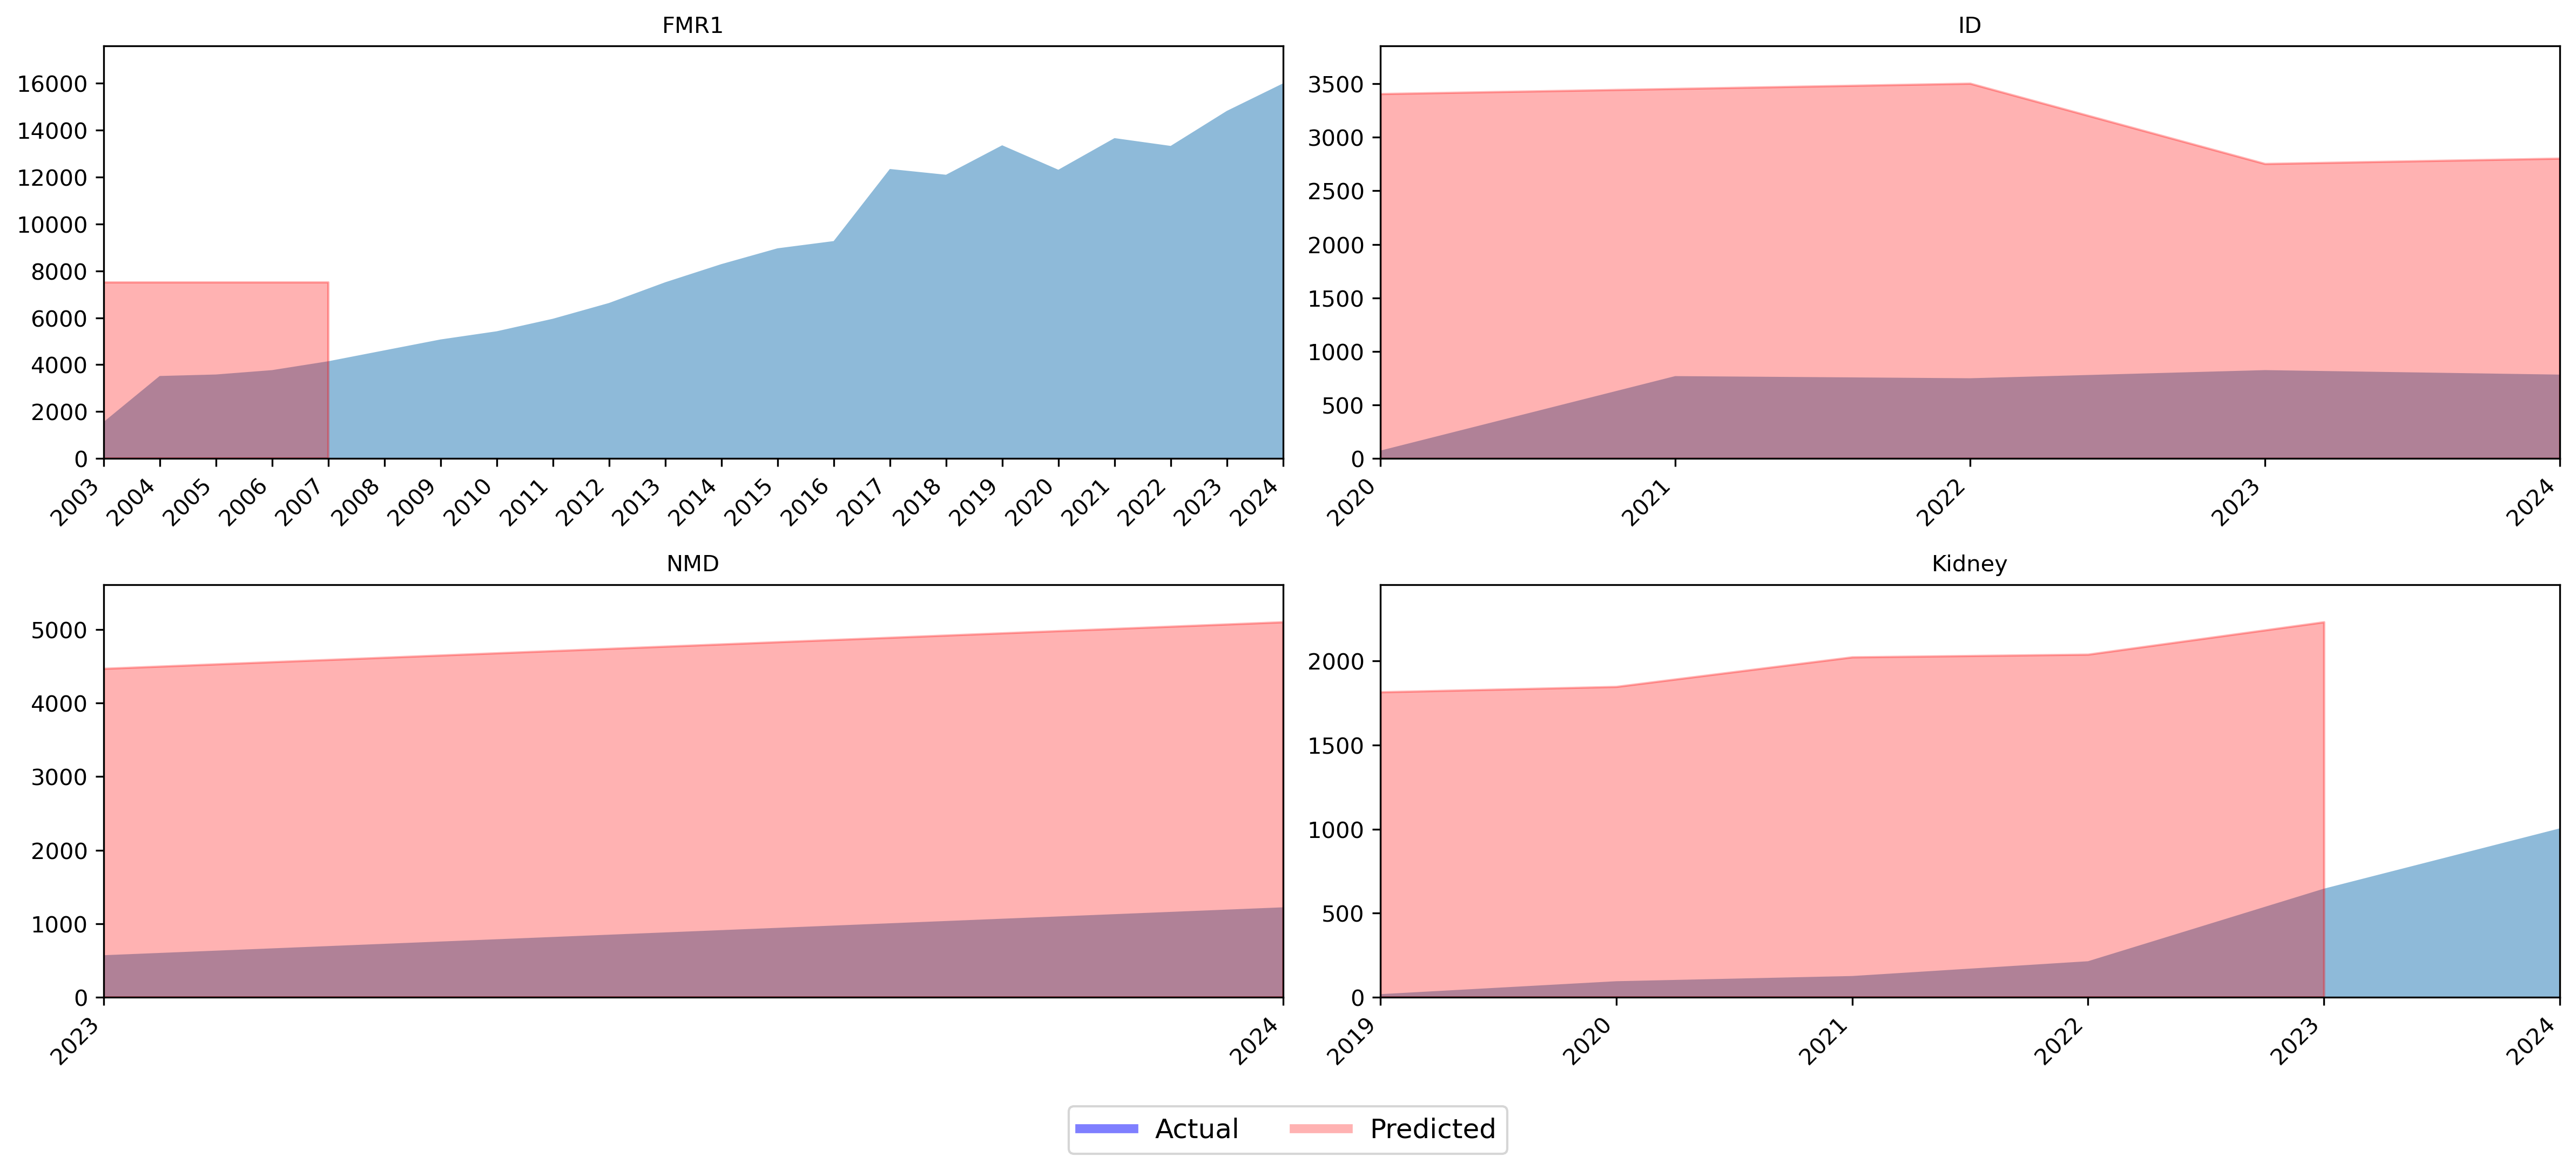

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item codes.
# Include '73300' for FMR1 so that its actual values are retained.
items_to_include = [
    '73300', '73292', '73298', '73299', '73358', '73359',
    '73360', '73395', '73401', '73402', '73416',
    '73422', '73425', '73426', '73440', '73440', 
    '73441', '73444', '73456', '73457', '73460'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Replace items with their corresponding group names:
# - Combine CS-P and CS-T: '73358' and '73359' become '73358_73359'
# - Combine Kidney: '73298', '73401', and '73402' become 'Kidney'
filtered_data.loc[:, 'Item'] = filtered_data['Item'].replace({
    '73359': '73358_73359', 
    '73358': '73358_73359',
    '73298': 'Kidney',
    '73401': 'Kidney',
    '73402': 'Kidney'
})

# Re-aggregate 'Value' by year for each item/group
grouped_data = filtered_data.groupby(['Item', filtered_data.index.year])['Value'].sum()

# Get the list of available item/group keys from the actual data
available_items = grouped_data.index.get_level_values('Item').unique().tolist()

# Predicted values (annual)
predicted_values = {
    '73300': [7500, 7500, 7500, 7500, 7500],
    '73358_73359': [3406, 3454, 3503, 2753, 2803],
    '73398': [2300, 1170, 1190, 1210, 1230],
    '73401': [789, 723, 796, 715, 805],
    '73402': [27, 25, 28, 25, 28],
    '73422': [4472, 5106, 5454, 5499, 5285],
    '73298': [1000, 1100, 1200, 1300, 1400]  # Example values; replace with actual predictions if needed
}

# Combine predicted values for the Kidney group (sum element-wise) if all keys are present
if all(k in predicted_values for k in ['73298', '73401', '73402']):
    kidney_pred = [a + b + c for a, b, c in zip(predicted_values['73298'], predicted_values['73401'], predicted_values['73402'])]
    predicted_values['Kidney'] = kidney_pred
    # Remove individual kidney predictions to avoid duplicate display
    for k in ['73298', '73401', '73402']:
         del predicted_values[k]

# Custom titles mapping for the desired items/groups
custom_titles = {
    '73300': 'FMR1',
    '73358_73359': 'ID',
    '73422': 'NMD',
    'Kidney': 'Kidney'
}

def get_custom_title(item):
    """
    Return a custom title for an item code.
    If the entire item code exists in custom_titles, return its value.
    Otherwise, if the item code is a combination (contains an underscore),
    then split and map each part.
    """
    if item in custom_titles:
        return custom_titles[item]
    elif "_" in item:
        parts = item.split("_")
        mapped_parts = [custom_titles.get(part, part) for part in parts]
        return "/".join(mapped_parts)
    else:
        return item

def create_subplots(items, filename=None):
    # Determine the current year (assumed to be incomplete if present)
    current_year = pd.Timestamp.now().year
    num_items = len(items)
    cols = 2  # Set number of columns
    rows = math.ceil(num_items / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300)
    axes = axes.flatten() if num_items > 1 else [axes]  # Flatten axes if needed

    for ax, item in zip(axes, items):
        max_y = 0

        # Get actual data for the item if available
        if item in grouped_data.index.get_level_values('Item'):
            item_data = grouped_data.loc[item]
            # If the maximum year equals the current year (likely incomplete), remove it
            if not item_data.empty and item_data.index.max() == current_year:
                item_data = item_data.loc[item_data.index < current_year]
        else:
            item_data = pd.Series()

        if not item_data.empty:
            ax.fill_between(item_data.index, item_data, alpha=0.5, label="Actual")
            max_y = max(max_y, item_data.max())
            last_year = item_data.index.max()
        else:
            last_year = None

        # Plot predicted values if available
        if item in predicted_values:
            if not item_data.empty:
                start_year = item_data.index.min()
            else:
                start_year = current_year - len(predicted_values[item])
            full_pred_years = list(range(start_year, start_year + len(predicted_values[item])))
            pred_values = predicted_values[item]
            # If a full last year exists, clip predictions to only those years
            if last_year is not None:
                clipped_years = []
                clipped_values = []
                for year, value in zip(full_pred_years, pred_values):
                    if year <= last_year:
                        clipped_years.append(year)
                        clipped_values.append(value)
                if clipped_years:
                    ax.fill_between(clipped_years, clipped_values, alpha=0.3, color='red', label="Predicted")
                    max_y = max(max_y, max(clipped_values))
                    pred_years = clipped_years
                else:
                    pred_years = []
            else:
                ax.fill_between(full_pred_years, pred_values, alpha=0.3, color='red', label="Predicted")
                max_y = max(max_y, max(pred_values))
                pred_years = full_pred_years
        else:
            pred_years = []

        # Set y-axis limits with some padding
        ax.set_ylim(0, max_y * 1.1)

        # Compute x-axis ticks as the union of actual and predicted (possibly clipped) years
        x_ticks = set()
        if not item_data.empty:
            x_ticks.update(item_data.index)
        if pred_years:
            x_ticks.update(pred_years)
        x_ticks = sorted(x_ticks)
        if x_ticks:
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks, rotation=45, ha='right')

        # Limit the x-axis to end at the last full year from actual data (if available)
        if not item_data.empty:
            ax.set_xlim(min(x_ticks), item_data.index.max())
        else:
            ax.set_xlim(min(x_ticks), max(x_ticks))

        # Set the subplot title using the custom title mapping
        ax.set_title(get_custom_title(item), fontsize=10)

    # Hide unused subplots if there are any extra axes
    for ax in axes[len(items):]:
        ax.axis('off')

    # Add a legend for the entire figure with automatic positioning
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.5, label='Actual'),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Predicted')
    ]
    fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.1))
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Define the list of groups to display:
# '73300' -> FMR1, '73358_73359' -> ID, '73422' -> NMD, and 'Kidney'
desired_items = ['73300', '73358_73359', '73422', 'Kidney']

# Create plots for the selected items/groups
create_subplots(
    desired_items,
    filename="FilteredItems_3cols.svg"
)


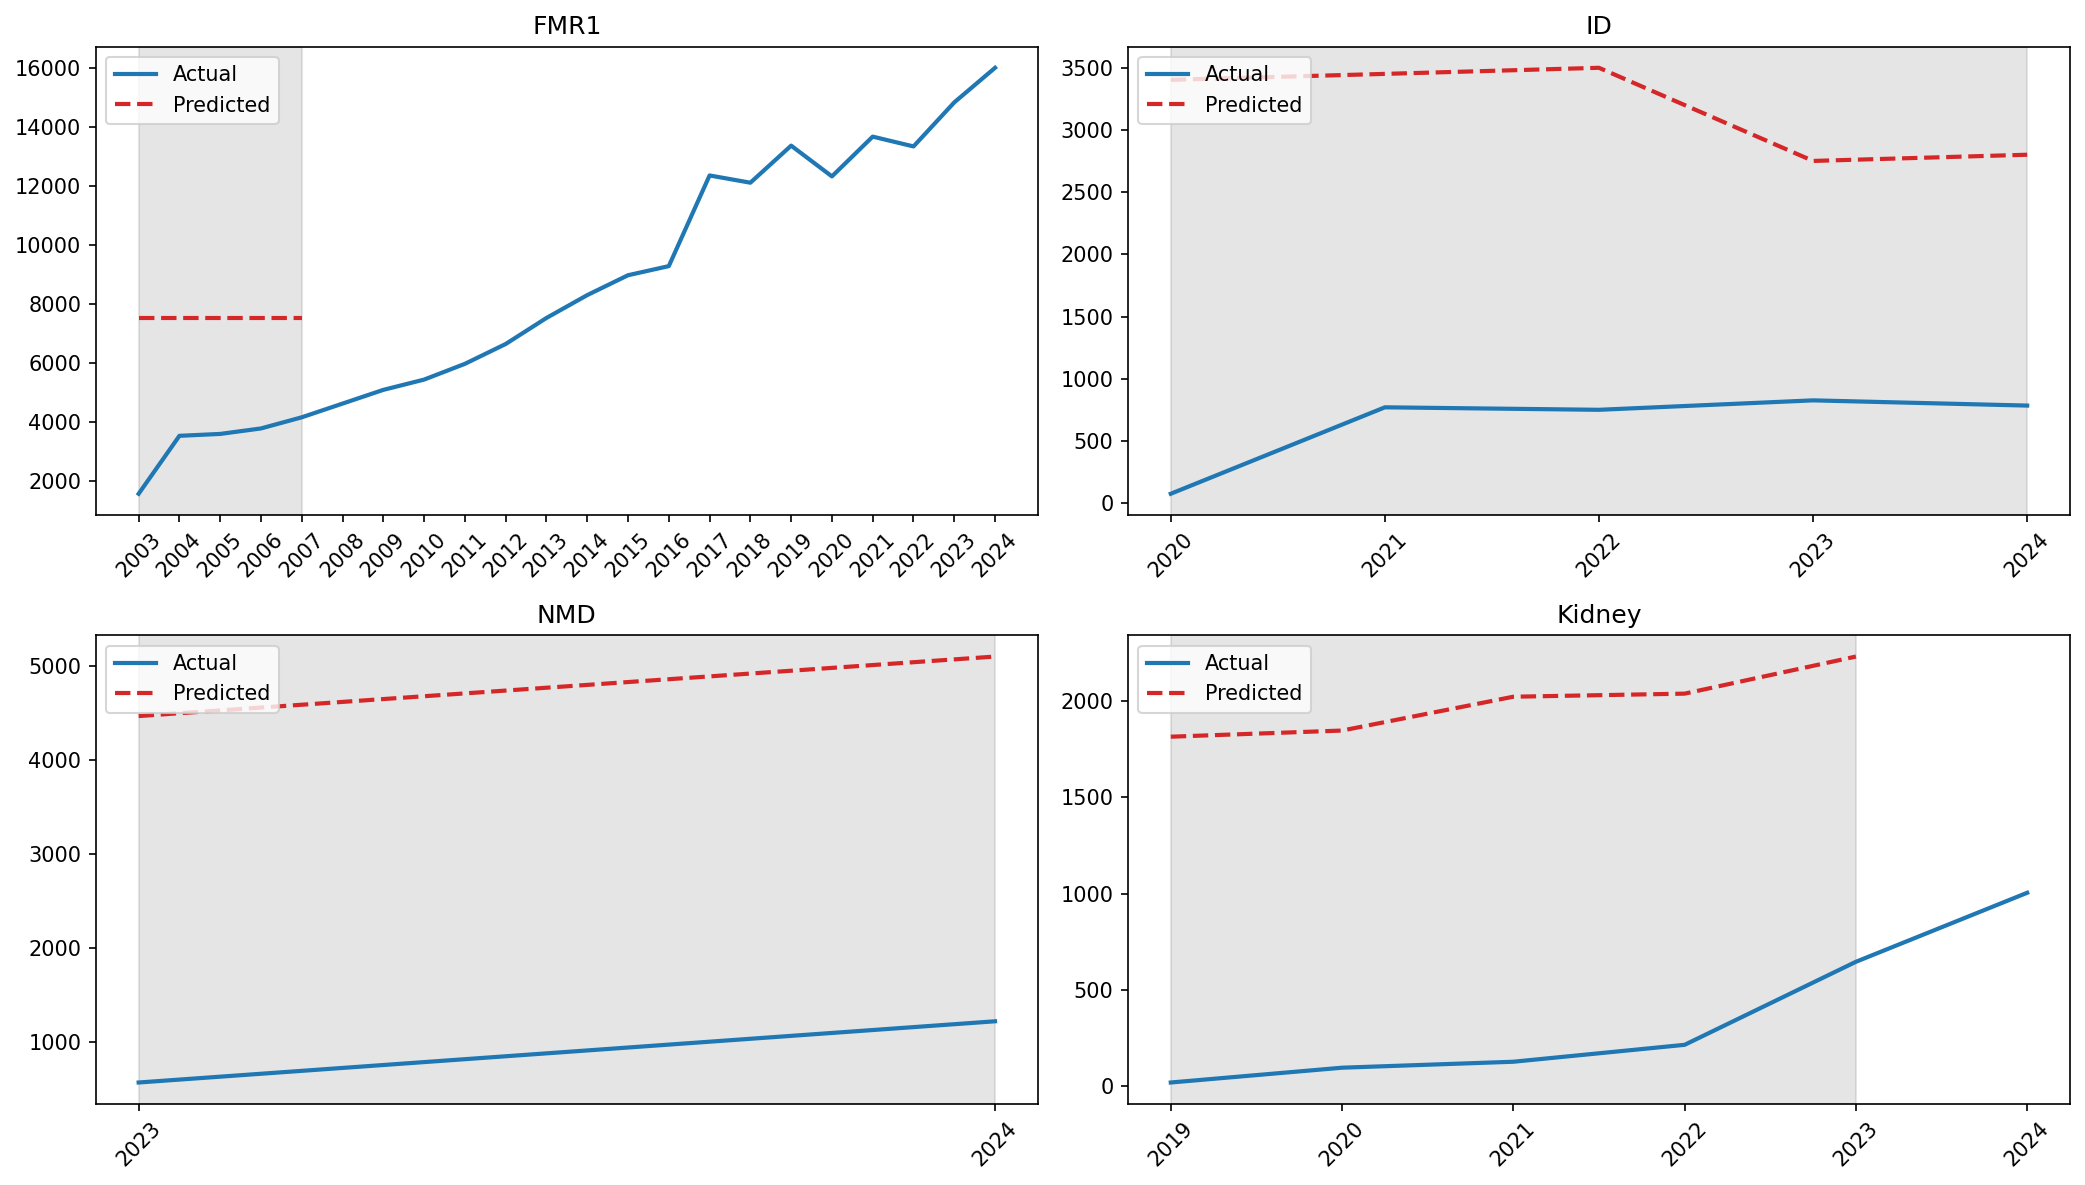

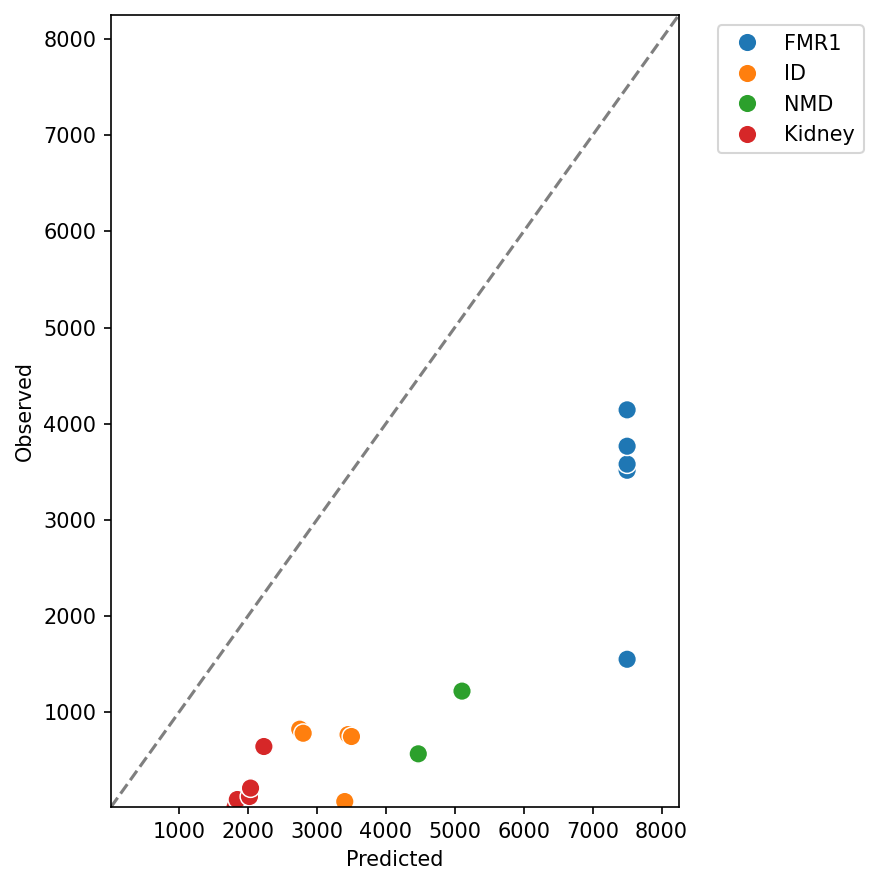

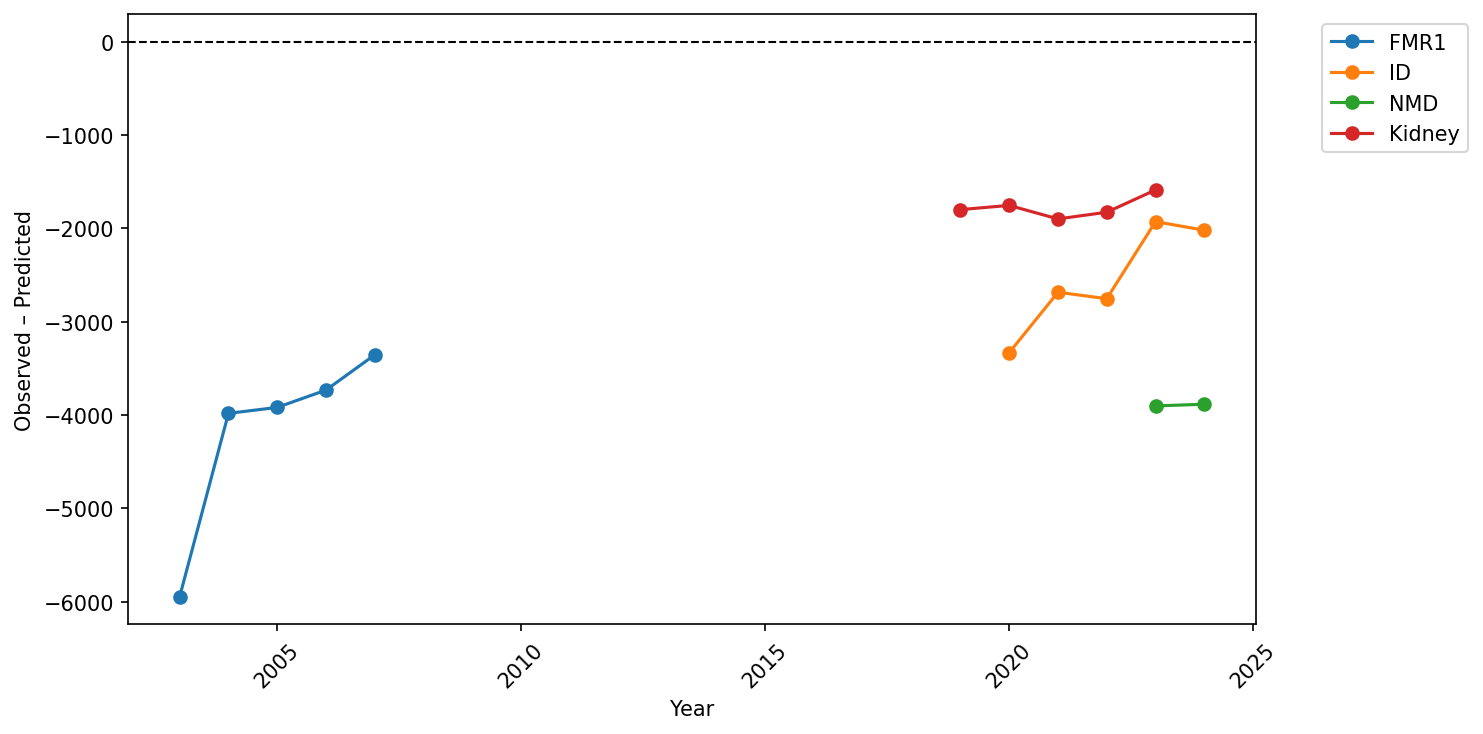

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# -------------------------
# 1) Load and prepare data
# -------------------------
file_path = "MBSGeneticsBenefit_202502.feather"  # adjust to your local path
df_all = pd.read_feather(file_path)

# Convert Month to datetime and set index
df_all['Month'] = pd.to_datetime(df_all['Month']).dt.to_period('M').dt.to_timestamp()
df_all.set_index('Month', inplace=True)

# Filter and map to groups
items_to_include = ['73300','73298','73358','73359','73422','73401','73402']
df = df_all[df_all['Item'].isin(items_to_include)].copy()
df['Item'] = df['Item'].replace({
    '73359':'73358_73359','73358':'73358_73359',
    '73298':'Kidney','73401':'Kidney','73402':'Kidney'
})

# Aggregate annual sums
grouped_data = (
    df.groupby(['Item', df.index.year])['Value']
      .sum()
      .rename_axis(index=['Item','Year'])
)

# -------------------------
# 2) Define predictions
# -------------------------
predicted_values = {
    '73300':[7500,7500,7500,7500,7500],         # FMR1
    '73358_73359':[3406,3454,3503,2753,2803],   # ID
    '73422':[4472,5106,5454,5499,5285],         # NMD
    '73298':[1000,1100,1200,1300,1400],         # Kidney parts
    '73401':[789,723,796,715,805],
    '73402':[27,25,28,25,28],
}
# Combine Kidney
kidney = [a+b+c for a,b,c in zip(predicted_values['73298'],
                                 predicted_values['73401'],
                                 predicted_values['73402'])]
predicted_values['Kidney'] = kidney
for k in ['73298','73401','73402']:
    predicted_values.pop(k)

# -------------------------
# 3) Plot settings
# -------------------------
desired_items = ['73300','73358_73359','73422','Kidney']
title_map = {'73300':'FMR1','73358_73359':'ID','73422':'NMD','Kidney':'Kidney'}
get_title = lambda i: title_map.get(i,i)

# -------------------------
# 4) Option A: Faceted plots
# -------------------------
def plot_facets_first_years(items):
    cols, rows = 2, math.ceil(len(items)/2)
    fig, axes = plt.subplots(rows, cols, figsize=(14,4*rows), dpi=150)
    axes = axes.flatten()
    for ax, item in zip(axes, items):
        actual = grouped_data.loc[item].sort_index().iloc[:-1]
        years = actual.index.tolist()
        ax.plot(years, actual.values, color='C0', label='Actual', lw=2)
        preds = predicted_values[item]
        # align to first 5 years
        if len(preds) <= len(years):
            yrs_pred = years[:len(preds)]
        else:
            yrs_pred = years
        vals_pred = preds[:len(yrs_pred)]
        ax.plot(yrs_pred, vals_pred, '--', color='C3', label='Predicted', lw=2)
        ax.axvspan(yrs_pred[0], yrs_pred[-1], color='grey', alpha=0.2)
        # integer-year x-axis
        ticks = sorted(set(years+yrs_pred))
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks, rotation=45)
        ax.set_title(get_title(item))
        ax.legend(loc='upper left')
    for ax in axes[len(items):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------
# 5) Option B: Scatter Pred vs Obs
# -------------------------
def plot_scatter_first_years(items):
    recs=[]
    for item in items:
        actual = grouped_data.loc[item].sort_index().iloc[:-1]
        years = actual.index.tolist()
        preds = predicted_values[item]
        for y,p in zip(years[:len(preds)], preds):
            recs.append({'Test':get_title(item),'Year':y,
                         'Observed':actual.loc[y],'Predicted':p})
    df_sc = pd.DataFrame(recs)
    plt.figure(figsize=(6,6),dpi=150)
    sns.scatterplot(data=df_sc,x='Predicted',y='Observed',hue='Test',s=80)
    lims=(df_sc[['Observed','Predicted']].min().min()*0.9,
          df_sc[['Observed','Predicted']].max().max()*1.1)
    plt.plot(lims,lims,'k--',alpha=0.5)
    plt.xlim(lims);plt.ylim(lims)
    plt.xlabel('Predicted');plt.ylabel('Observed')
    #plt.title('Predicted vs Observed (First 5 Years)')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.tight_layout()
    plt.show()

# -------------------------
# 6) Option C: Error Over Time
# -------------------------
def plot_error_first_years(items):
    plt.figure(figsize=(10,5),dpi=150)
    for item in items:
        actual=grouped_data.loc[item].sort_index().iloc[:-1]
        years=actual.index.tolist()
        preds=predicted_values[item]
        errs=[actual.loc[y]-p for y,p in zip(years[:len(preds)],preds)]
        plt.plot(years[:len(preds)],errs,marker='o',label=get_title(item))
    plt.axhline(0,ls='--',color='black',lw=1)
    plt.xlabel('Year');plt.ylabel('Observed – Predicted')
    #plt.title('Forecast Error (First 5 Years)')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------
# 7) Generate all plots
# -------------------------
plot_facets_first_years(desired_items)
plot_scatter_first_years(desired_items)
plot_error_first_years(desired_items)


### Viz - Diffusion - 5Y - By Group

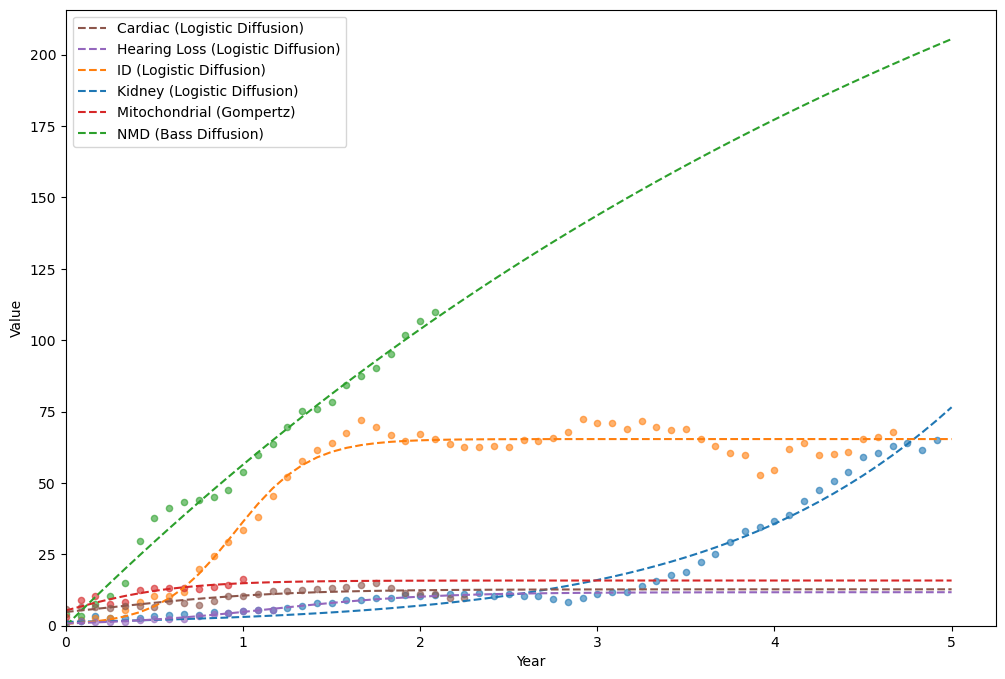

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB, KT-BL, CMA, FMR1
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group ID: CS-P (73358) and CS-T (73359) [renamed from CS to ID]
# - Group NMD: remains as NMD (73422)
# - Group Mitochondrial: (73456, 73457, 73460)
# - Group Hearing Loss: (73440, 73441, 73444)
# - Group Cardiac: (73416)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'ID': ['73358', '73359'],
    'NMD': ['73422'],
    'Mitochondrial': ['73456', '73457', '73460'],
    'Hearing Loss': ['73440', '73441', '73444'],
    'Cardiac': ['73416']
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group
for group, items in group_definitions.items():
    # Use 'ME' (month end) to avoid the future deprecation warning for 'M'
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of available data for fitting
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis (in years) for the available data
    fitted_years = np.arange(len(group_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                # Increase maxfev for the Gompertz model to help convergence
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=100000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {
                'r2': r2,
                'params': params,
                'func': model_func
            }
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Create a time axis that spans a full 5 years (60 months)
        full_years = np.linspace(0, 5, 61)  # 61 points from 0 to 5 years
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'ActualYears': fitted_years,
            'Actual': group_data,
            'Predicted': best_pred_full
        })

# Plot the best performing diffusion model predictions for each group on one plot
plt.figure(figsize=(12, 8))
for bp in best_predictions:
    plt.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['Group']} ({bp['BestModel']})")
    # Plot the actual data points on their original time axis
    plt.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6)
plt.xlabel("Year")
plt.ylabel("Value")

# Set x-axis and y-axis lower limits to 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Sort the legend entries in alphabetical order
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_handles_labels)
plt.legend(sorted_handles, sorted_labels)

plt.show()


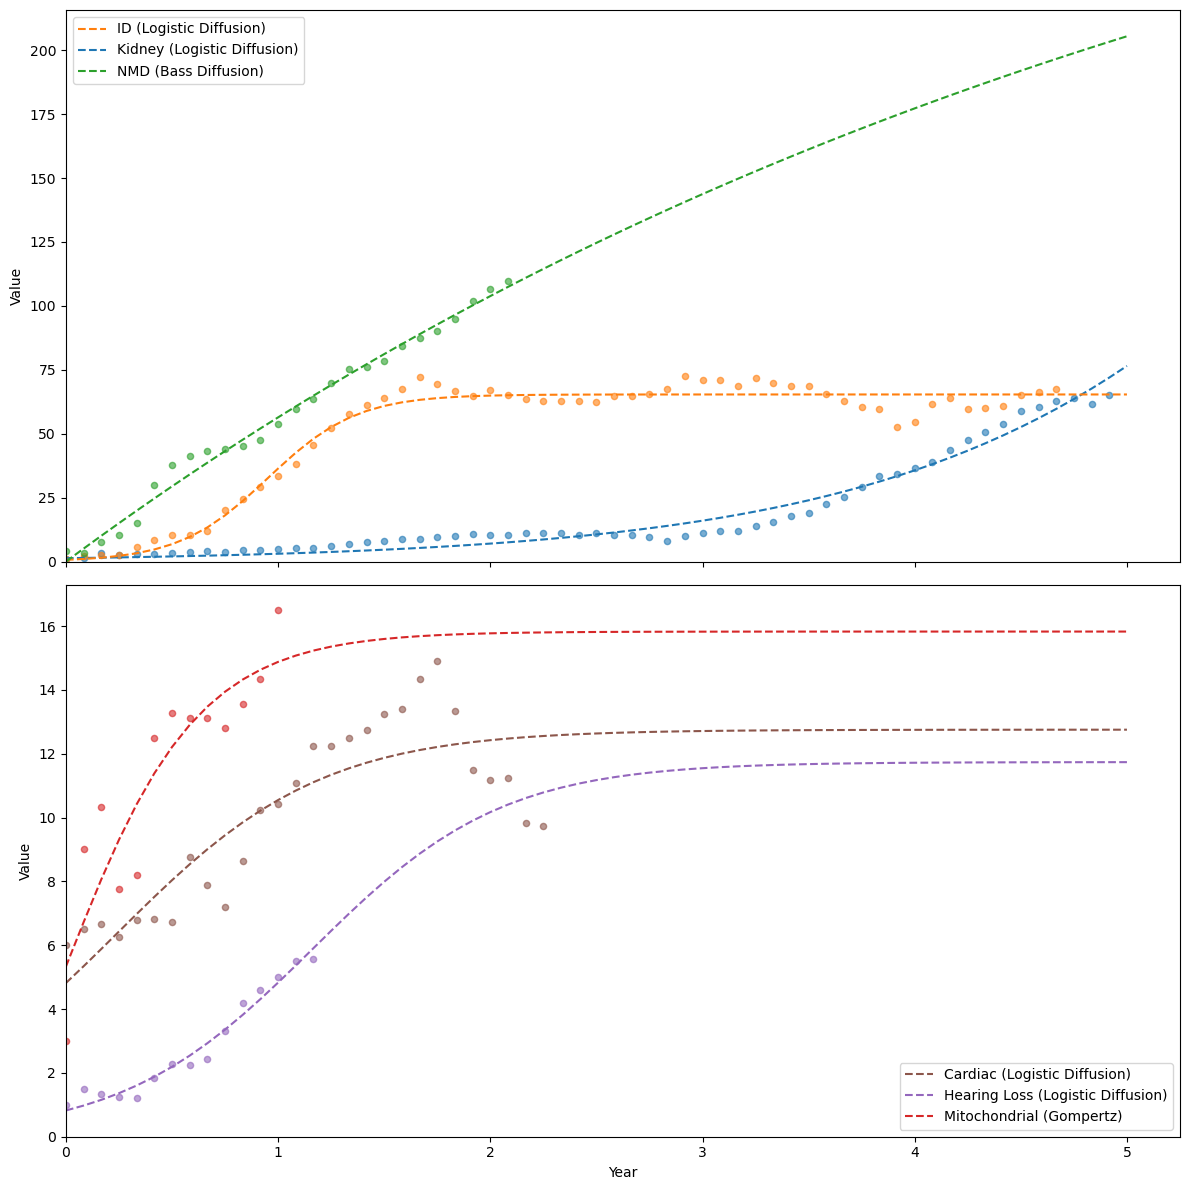

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB, KT-BL, CMA, FMR1
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group ID: CS-P (73358) and CS-T (73359) [renamed from CS to ID]
# - Group NMD: remains as NMD (73422)
# - Group Mitochondrial: (73456, 73457, 73460)
# - Group Hearing Loss: (73440, 73441, 73444)
# - Group Cardiac: (73416)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'ID': ['73358', '73359'],
    'NMD': ['73422'],
    'Mitochondrial': ['73456', '73457', '73460'],
    'Hearing Loss': ['73440', '73441', '73444'],
    'Cardiac': ['73416']
}

# Define a mapping so that each group always uses the same unique color
color_mapping = {
    'Kidney': 'tab:blue',
    'ID': 'tab:orange',
    'NMD': 'tab:green',
    'Mitochondrial': 'tab:red',
    'Hearing Loss': 'tab:purple',
    'Cardiac': 'tab:brown'
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group
for group, items in group_definitions.items():
    # Use 'ME' (month end) to avoid the future deprecation warning for 'M'
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 60 months (5 years) of available data for fitting
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Create a time axis (in years) for the available data
    fitted_years = np.arange(len(group_data)) / 12.0

    # Define diffusion models to fit
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # Fit each diffusion model
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                # Increase maxfev for the Gompertz model to help convergence
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=100000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func,
                    fitted_years,
                    group_data,
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
            # Compute predictions on the fitted range and calculate R² on the available data
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {
                'r2': r2,
                'params': params,
                'func': model_func
            }
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # Select the best-performing diffusion model based on the highest R² score
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        # Create a time axis that spans a full 5 years (60 months)
        full_years = np.linspace(0, 5, 61)  # 61 points from 0 to 5 years
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'ActualYears': fitted_years,
            'Actual': group_data,
            'Predicted': best_pred_full
        })

# Separate predictions into two subgroups:
# Subplot 1: Kidney, ID, NMD
# Subplot 2: Cardiac, Mitochondrial, Hearing Loss
subplot2_groups = ['Cardiac', 'Mitochondrial', 'Hearing Loss']
subplot2_predictions = [bp for bp in best_predictions if bp['Group'] in subplot2_groups]
subplot1_predictions = [bp for bp in best_predictions if bp['Group'] not in subplot2_groups]

# Create a figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plot in subplot 1: Kidney, ID, NMD
for bp in subplot1_predictions:
    color = color_mapping[bp['Group']]
    ax1.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['Group']} ({bp['BestModel']})", color=color)
    ax1.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6, color=color)
ax1.set_ylabel("Value")
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)
# Sort legend entries alphabetically
handles1, labels1 = ax1.get_legend_handles_labels()
sorted_handles_labels1 = sorted(zip(labels1, handles1), key=lambda x: x[0])
if sorted_handles_labels1:
    sorted_labels1, sorted_handles1 = zip(*sorted_handles_labels1)
    ax1.legend(sorted_handles1, sorted_labels1)
#ax1.set_title("Diffusion Model Predictions (Kidney, ID, NMD)")

# Plot in subplot 2: Cardiac, Mitochondrial, Hearing Loss
for bp in subplot2_predictions:
    color = color_mapping[bp['Group']]
    ax2.plot(bp['Years'], bp['Predicted'], linestyle='--',
             label=f"{bp['Group']} ({bp['BestModel']})", color=color)
    ax2.scatter(bp['ActualYears'], bp['Actual'], s=20, alpha=0.6, color=color)
ax2.set_xlabel("Year")
ax2.set_ylabel("Value")
ax2.set_xlim(left=0)
ax2.set_ylim(bottom=0)
# Sort legend entries alphabetically
handles2, labels2 = ax2.get_legend_handles_labels()
sorted_handles_labels2 = sorted(zip(labels2, handles2), key=lambda x: x[0])
if sorted_handles_labels2:
    sorted_labels2, sorted_handles2 = zip(*sorted_handles_labels2)
    ax2.legend(sorted_handles2, sorted_labels2)
#ax2.set_title("Diffusion Model Predictions (Cardiac, Mitochondrial, Hearing Loss)")

plt.tight_layout()
plt.show()


### Viz - Scenario - Utilisation - Forecast

/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


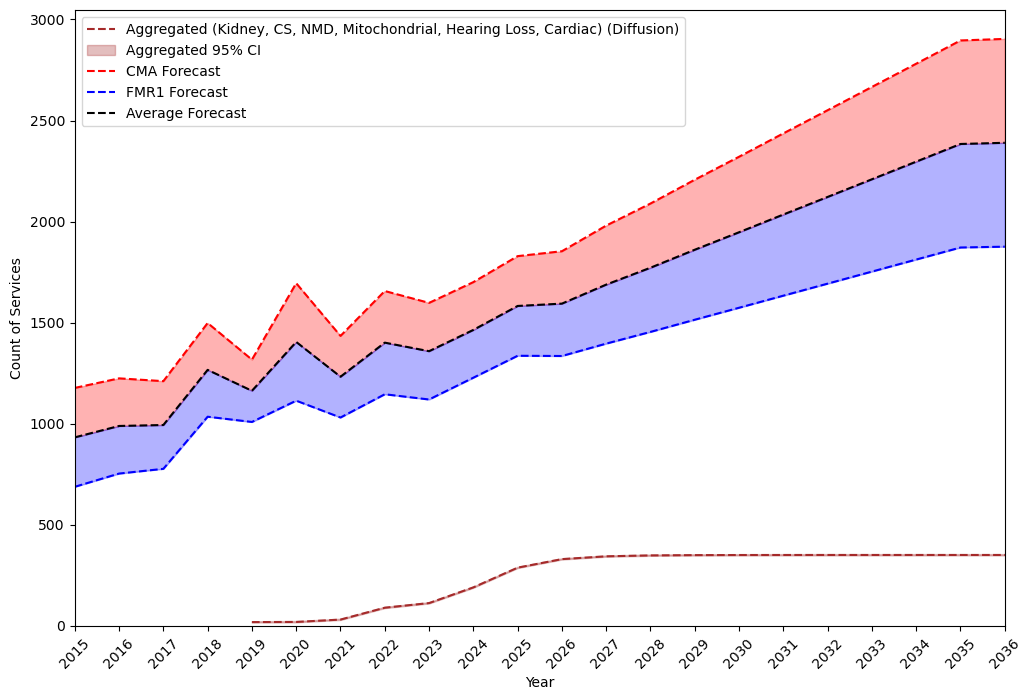

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
# Primary groups: CMA and FMR1
# Secondary groups (to be aggregated) originally included: Kidney, CS, NMD
# Now adding three more secondary groups: Mitochondrial, Hearing Loss, and Cardiac
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'Mitochondrial': ['73456', '73457', '73460'],  # Newly added
    'Hearing Loss': ['73440', '73441', '73444'],   # Newly added
    'Cardiac': ['73416'],                           # Newly added
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Colors for primary groups and aggregated secondary forecast.
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
# Use all available data (smoothed with a 12‐month moving average).
# The original time is computed as decimal years but we then create forecast grids in whole years.
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue
    
    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            # Use SARIMA predict with date_range and then convert to whole years.
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            # For simplicity, re-sample SARIMA forecast to whole years using interpolation.
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Generate Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        
        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        }
        # For secondary groups, store in-sample info for residuals.
        # Updated condition to include new secondary groups.
        if group in ["Kidney", "CS", "NMD", "Mitochondrial", "Hearing Loss", "Cardiac"]:
            entry['InSampleYears'] = fitted_years  # still in decimals, used for residuals
            entry['InSampleFitted'] = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleObserved'] = group_data.values
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)
##########################
# Update the list to include the new groups.
secondary_preds = [bp for bp in best_predictions if bp['Group'] in ["Kidney", "CS", "NMD", "Mitochondrial", "Hearing Loss", "Cardiac"]]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)
    
    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    
    # Also, compute aggregated in-sample residuals from secondary groups over their overlapping in-sample period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)
    
    # Bootstrapping for 95% CI over the aggregated forecast grid.
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_residuals, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
    
    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']
    
    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)
    
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# Plotting all forecasts on a single y-axis
##########################
fig, ax = plt.subplots(figsize=(12, 8))

# Plot aggregated secondary forecast with bootstrapped 95% CI if available.
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")

# Plot individual forecasts for CMA and FMR1.
ax.plot(common_years_avg, interp_cma, linestyle='--', color=color_map["CMA"], label="CMA Forecast")
ax.plot(common_years_avg, interp_fmr1, linestyle='--', color=color_map["FMR1"], label="FMR1 Forecast")

# Plot the average forecast with a line style similar to the other curves.
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")

# Shade the area between the average forecast and the individual forecasts.
ax.fill_between(common_years_avg, avg_forecast, interp_cma, color=color_map["CMA"], alpha=0.3)
ax.fill_between(common_years_avg, avg_forecast, interp_fmr1, color=color_map["FMR1"], alpha=0.3)

# Set axis limits and labels.
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
# ax.set_title("Forecasts: Aggregated Secondary Groups with 95% CI and Average (CMA & FMR1)")

# Set x-axis ticks to whole years and angle the labels.
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)

# Create a legend and place it on the right side.
ax.legend(loc='lower left', bbox_to_anchor=(0, 0.8))

plt.show()


### Viz - Scenario - Cost - Forecast

/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)_Unscaled  \
Year                                                                               
2025                                     287 (284, 291)                            
2026                                     329 (326, 333)                            
2027                                     343 (340, 347)                            
2028                                     348 (345, 352)                            
2029                                     349 (346, 353)                            
2030                                     349 (346, 353)                            
2031                                     350 (347, 354)                            
2032                                     350 (347, 354)                            
2033                                     350 (347, 354)                            
2034                                     350 (347, 354)                     

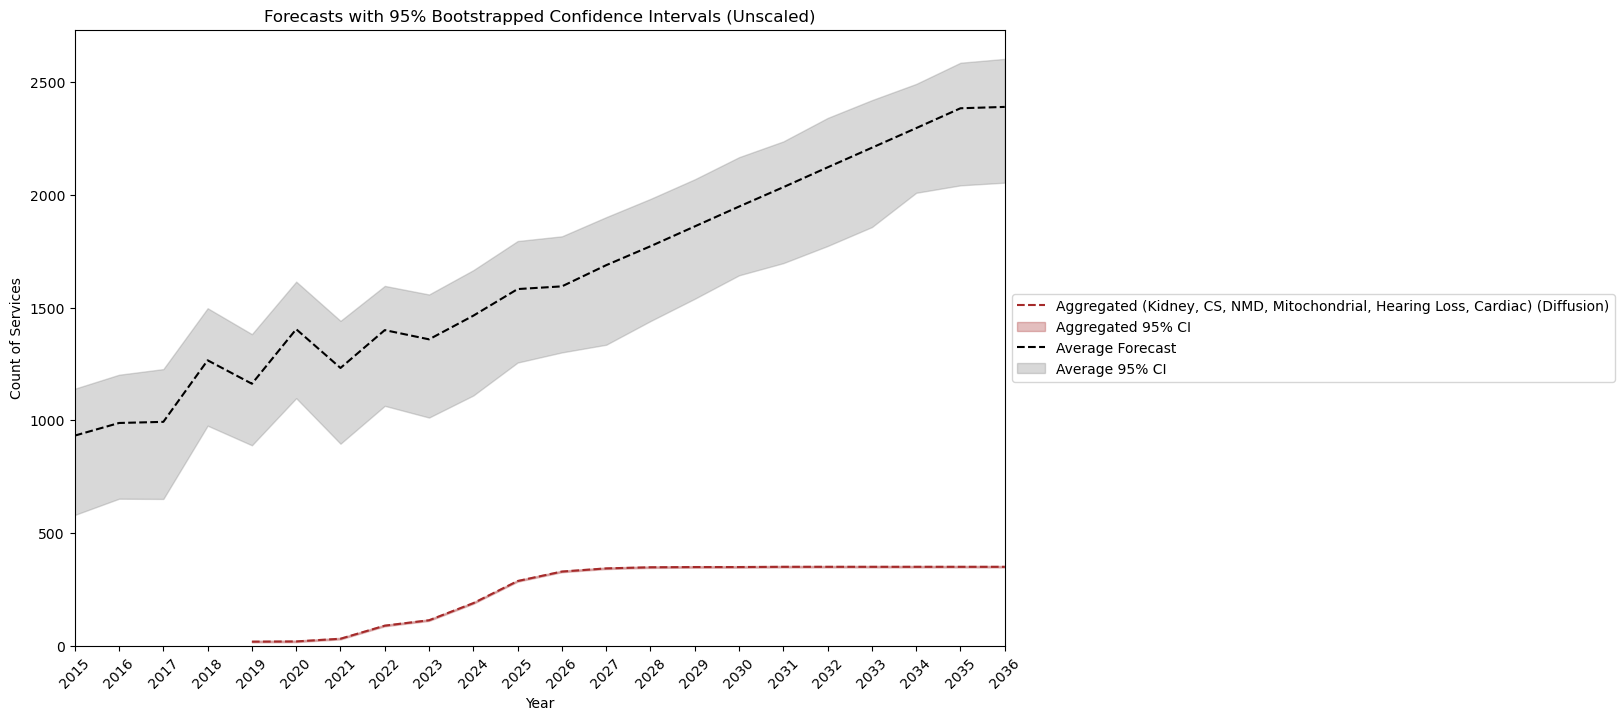

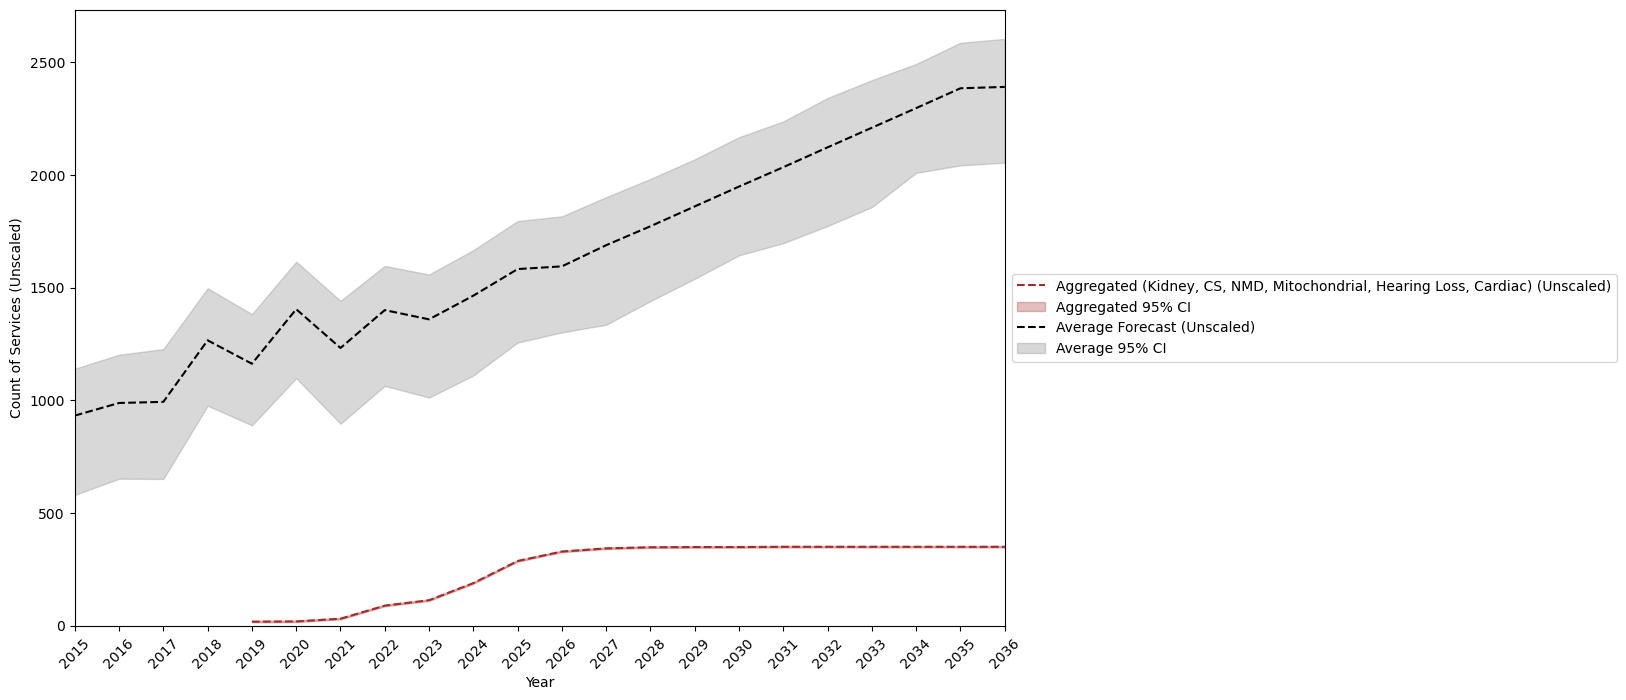

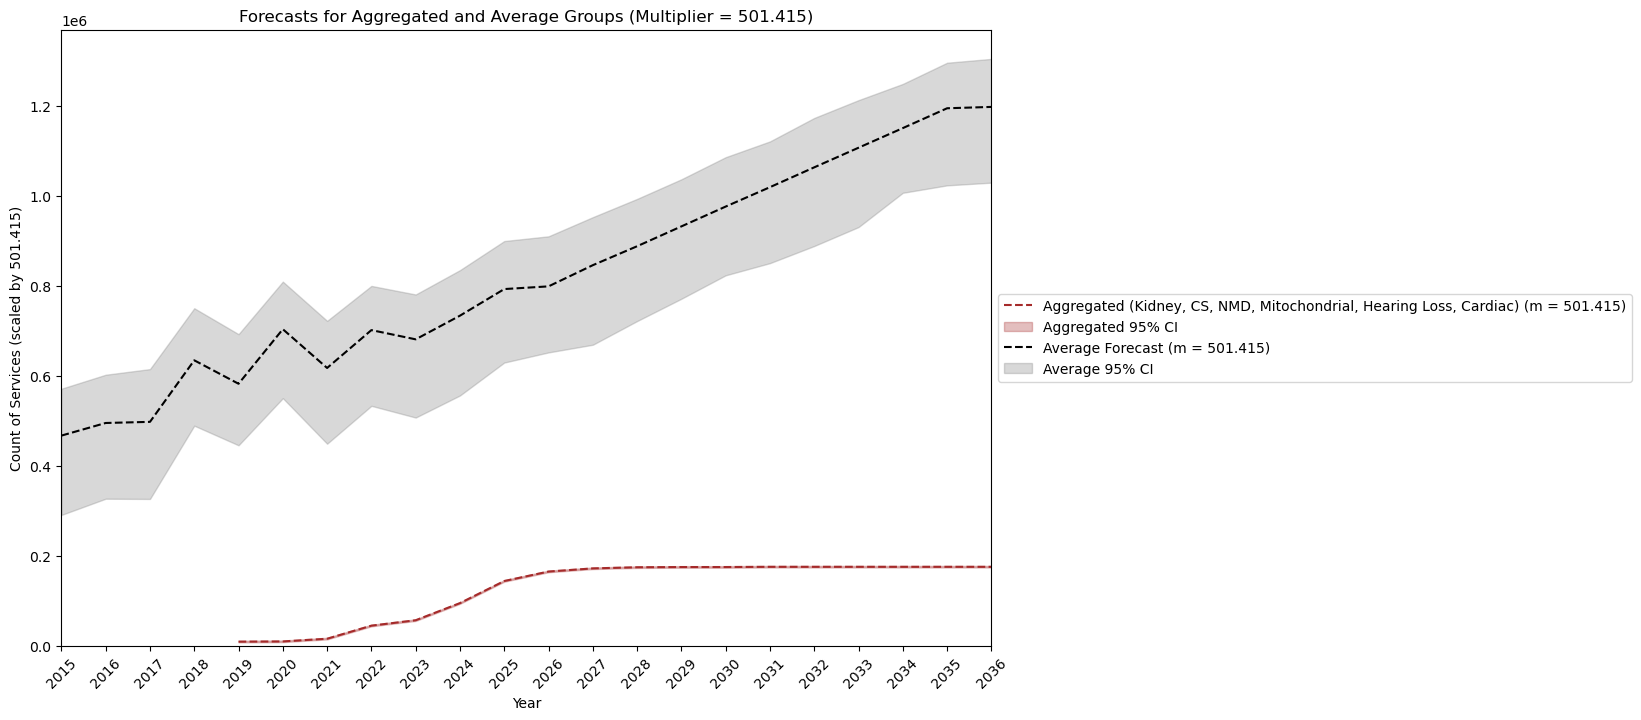

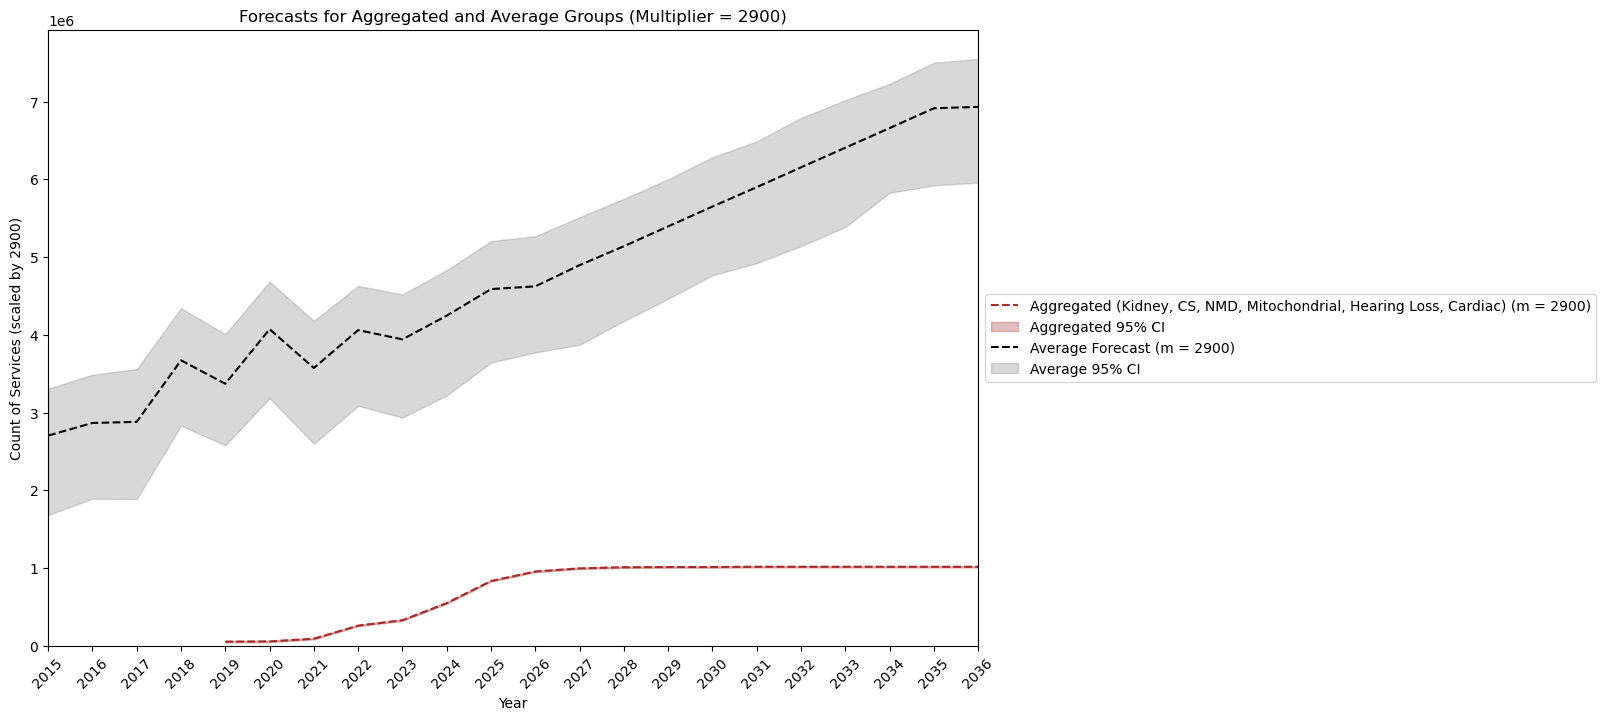

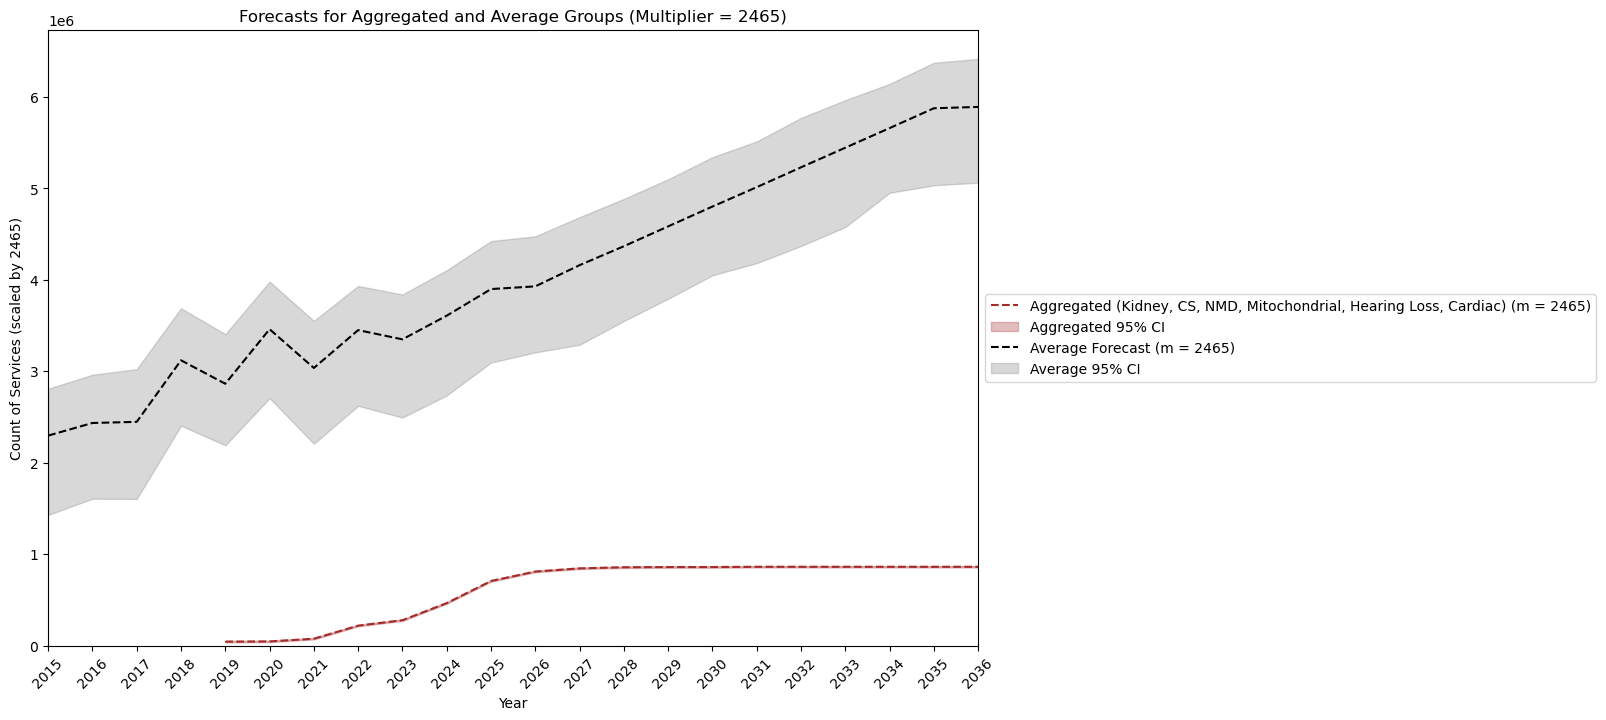

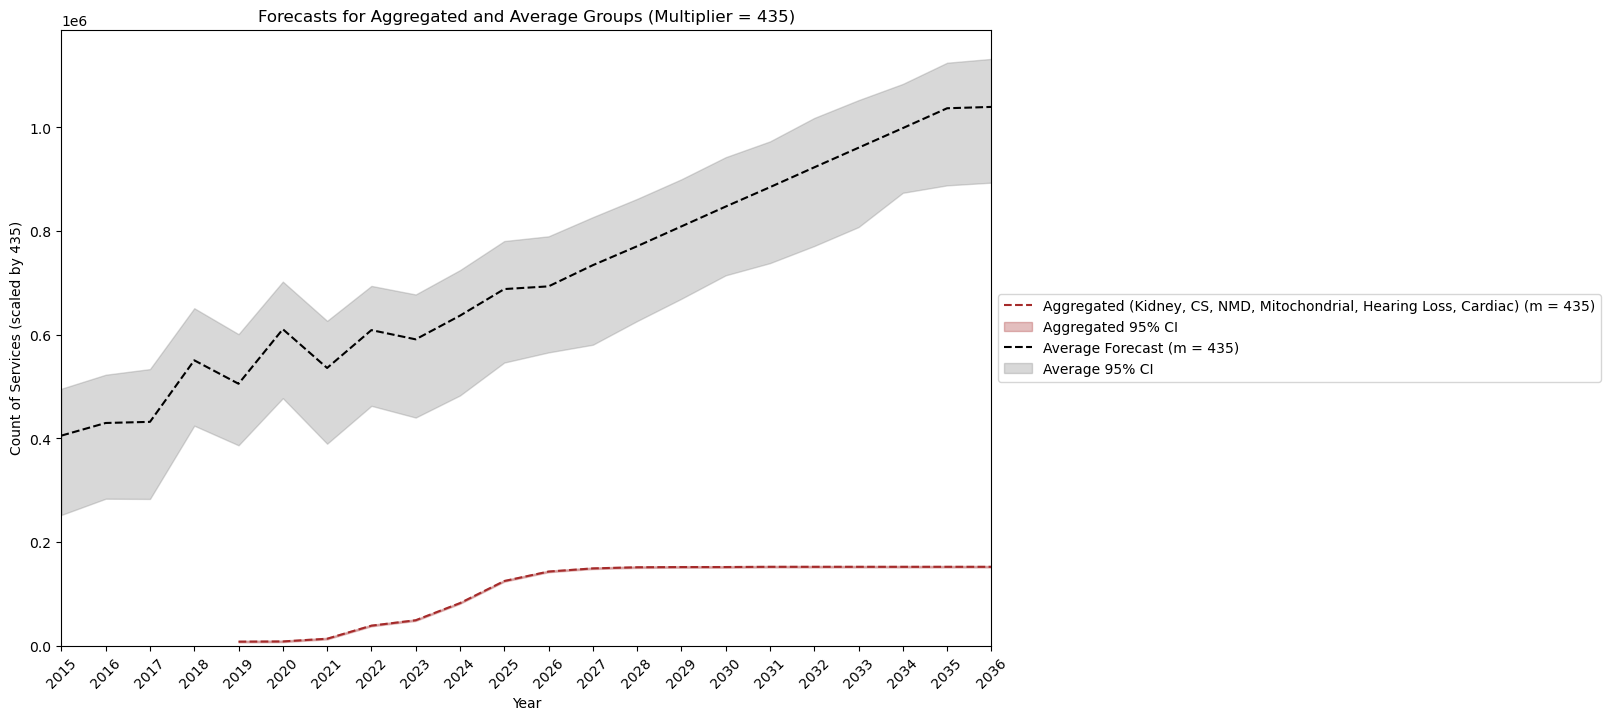

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'Mitochondrial': ['73456', '73457', '73460'],  # Added
    'Hearing Loss': ['73440', '73441', '73444'],    # Added
    'Cardiac': ['73416'],                           # Added
    'CMA': ['73292'],
    'FMR1': ['73300']
}

color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

# Define the list of secondary groups for later use.
secondary_groups = ["Kidney", "CS", "NMD", "Mitochondrial", "Hearing Loss", "Cardiac"]

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Center the residuals before bootstrapping.
        resid_centered = residuals - np.mean(residuals)
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(resid_centered, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        # --- Round to whole numbers ---
        best_pred_full = np.rint(best_pred_full)
        ci_lower = np.rint(ci_lower)
        ci_upper = np.rint(ci_upper)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in secondary_groups:
            entry['InSampleYears'] = fitted_years
            fitted_in_sample = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleFitted'] = np.rint(fitted_in_sample)
            entry['InSampleObserved'] = np.rint(group_data.values)
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)
##########################
secondary_preds = [bp for bp in best_predictions if bp['Group'] in secondary_groups]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    # Compute aggregated in-sample residuals over the overlapping period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds]
    common_in_start = max(in_sample_starts)
    common_in_end = min(in_sample_ends)
    common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
    aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
    for bp in secondary_preds:
        obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
        fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
        aggregated_residuals += (obs_interp - fit_interp)

    # Center aggregated residuals.
    aggregated_resid_centered = aggregated_residuals - np.mean(aggregated_residuals)
    B = 500
    bootstrap_forecasts = np.zeros((B, len(common_time)))
    for b in range(B):
        boot_errors = np.random.choice(aggregated_resid_centered, size=len(common_time), replace=True)
        bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
    agg_ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    agg_ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    # --- Round aggregated forecasts to whole numbers ---
    aggregated_forecast = np.rint(aggregated_forecast)
    agg_ci_lower = np.rint(agg_ci_lower)
    agg_ci_upper = np.rint(agg_ci_upper)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': agg_ci_lower,
        'CI_upper': agg_ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    # Interpolate the forecasts onto the common grid.
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # For bootstrapping, compute in-sample residuals for each primary forecast.
    resid_cma = primary_forecasts["CMA"].get('residuals', primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma)
    resid_fmr1 = primary_forecasts["FMR1"].get('residuals', primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1)
    # Center each set of residuals.
    resid_cma_centered = resid_cma - np.mean(resid_cma)
    resid_fmr1_centered = resid_fmr1 - np.mean(resid_fmr1)
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    for b in range(B):
        boot_error_cma = np.random.choice(resid_cma_centered, size=len(common_years_avg), replace=True)
        boot_error_fmr1 = np.random.choice(resid_fmr1_centered, size=len(common_years_avg), replace=True)
        boot_forecast_cma = interp_cma + boot_error_cma
        boot_forecast_fmr1 = interp_fmr1 + boot_error_fmr1
        bootstrap_avg[b, :] = (boot_forecast_cma + boot_forecast_fmr1) / 2
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)

    # --- Round average forecasts to whole numbers ---
    avg_forecast = np.rint(avg_forecast)
    avg_ci_lower = np.rint(avg_ci_lower)
    avg_ci_upper = np.rint(avg_ci_upper)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# (Optional) Plotting the original forecasts (unscaled)
##########################
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper,
                color='gray', alpha=0.3, label="Average 95% CI")
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()  # Uncomment to display the unscaled plot

##########################
# Generate table for Aggregated and Average Groups, scaled by each multiplier
##########################
# Multipliers now include unscaled (1) and 501.415 in addition to the previous ones.
multipliers = [1, 501.415, 2900, 2465, 435]
agg_group_name = 'Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)'
avg_group_name = 'Average (CMA & FMR1)'
years_range = sorted(list(set(range(2025, 2036))))
table_data = {}

for year in years_range:
    row = {}
    # Process Aggregated Group.
    if aggregated_secondary_forecast is not None and year in aggregated_secondary_forecast['Years']:
        idx = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
        pred_val = aggregated_secondary_forecast['Predicted'][idx]
        ci_lower_val = aggregated_secondary_forecast['CI_lower'][idx]
        ci_upper_val = aggregated_secondary_forecast['CI_upper'][idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            # Multiply and convert to whole numbers.
            row[col_name] = f"{int(round(pred_val * m))} ({int(round(ci_lower_val * m))}, {int(round(ci_upper_val * m))})"
        # New column: Sum of multiplier 2465 and 501.415 for Aggregated group.
        sum_val = pred_val * 2465 + pred_val * 501.415
        sum_lower = ci_lower_val * 2465 + ci_lower_val * 501.415
        sum_upper = ci_upper_val * 2465 + ci_upper_val * 501.415
        row[f"{agg_group_name}_2465+501.415"] = f"{int(round(sum_val))} ({int(round(sum_lower))}, {int(round(sum_upper))})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            row[col_name] = ""
        row[f"{agg_group_name}_2465+501.415"] = ""
    
    # Process Average Group.
    if year in common_years_avg:
        idx = np.where(common_years_avg == year)[0][0]
        pred_val = avg_forecast[idx]
        ci_lower_val = avg_ci_lower[idx]
        ci_upper_val = avg_ci_upper[idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = f"{int(round(pred_val * m))} ({int(round(ci_lower_val * m))}, {int(round(ci_upper_val * m))})"
        # New column: Sum of multiplier 501.415 and 2465 for Average group.
        sum_val = pred_val * 501.415 + pred_val * 2465
        sum_lower = ci_lower_val * 501.415 + ci_lower_val * 2465
        sum_upper = ci_upper_val * 501.415 + ci_upper_val * 2465
        row[f"{avg_group_name}_501.415+2465"] = f"{int(round(sum_val))} ({int(round(sum_lower))}, {int(round(sum_upper))})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = ""
        row[f"{avg_group_name}_501.415+2465"] = ""
    
    table_data[year] = row

df_final = pd.DataFrame.from_dict(table_data, orient='index')
df_final.index.name = 'Year'
print(df_final)

##########################
# Create separate plots for:
# 1. Unscaled forecasts (m = 1)
# 2. Forecasts scaled with multiplier 501.415
# 3. Plots for the original multipliers: 2900, 2465, and 435
##########################

# 1. Unscaled Plot (m = 1)
m = 1
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (Unscaled)")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = np.rint(avg_forecast * m)
avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label="Average Forecast (Unscaled)")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services (Unscaled)")
#ax.set_title("Forecasts for Aggregated and Average Groups (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 2. Plot with multiplier 501.415
m = 501.415
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (m = {m})")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = np.rint(avg_forecast * m)
avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label=f"Average Forecast (m = {m})")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel(f"Count of Services (scaled by {m})")
ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 3. Plots for the original multipliers: 2900, 2465, and 435
for m in [2900, 2465, 435]:
    fig, ax = plt.subplots(figsize=(12, 8))
    if aggregated_secondary_forecast is not None:
        years_agg = aggregated_secondary_forecast['Years']
        agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
        agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
        agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
        ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
                label=f"{agg_group_name} (m = {m})")
        ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                        color=agg_color, alpha=0.3, label="Aggregated 95% CI")
    avg_pred_scaled = np.rint(avg_forecast * m)
    avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
    avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
    ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
            label=f"Average Forecast (m = {m})")
    ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                    color='gray', alpha=0.3, label="Average 95% CI")
    if aggregated_secondary_forecast is not None:
        global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
        global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
    else:
        global_start = common_years_avg[0]
        global_end = common_years_avg[-1]
    ax.set_xlim(global_start, global_end)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Count of Services (scaled by {m})")
    ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
    ax.set_xticks(np.arange(global_start, global_end + 1, 1))
    ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [43]:
df_final

Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)_Unscaled  \
Year                                                                               
2025                                     287 (284, 291)                            
2026                                     329 (326, 333)                            
2027                                     343 (340, 347)                            
2028                                     348 (345, 352)                            
2029                                     349 (346, 353)                            
2030                                     349 (346, 353)                            
2031                                     350 (347, 354)                            
2032                                     350 (347, 354)                            
2033                                     350 (347, 354)                            
2034                                     350 (347, 354)                            
2035                                     350 (347, 354)                            

     Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)_501.415  \
Year                                                                              
2025                            143906 (142402, 145912)                           
2026                            164966 (163461, 166971)                           
2027                            171985 (170481, 173991)                           
2028                            174492 (172988, 176498)                           
2029                            174994 (173490, 176999)                           
2030                            174994 (173490, 176999)                           
2031                            175495 (173991, 177501)                           
2032                            175495 (173991, 177501)                           
2033                            175495 (173991, 177501)                           
2034                            175495 (173991, 177501)                           
2035                            175495 (173991, 177501)                           

     Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)_2900  \
Year                                                                           
2025                            832300 (823600, 843900)                        
2026                            954100 (945400, 965700)                        
2027                           994700 (986000, 1006300)                        
2028                         1009200 (1000500, 1020800)                        
2029                         1012100 (1003400, 1023700)                        
2030                         1012100 (1003400, 1023700)                        
2031                         1015000 (1006300, 1026600)                        
2032                         1015000 (1006300, 1026600)                        
2033                         1015000 (1006300, 1026600)                        
2034                         1015000 (1006300, 1026600)                        
2035                         1015000 (1006300, 1026600)                        

     Aggregated (Kidney, CS, NMD, Mitochondrial, Hearing Loss, Cardiac)_2465  \
Year                                                                           
2025                            707455 (700060, 717315)                        
2026                            810985 (803590, 820845)                        
2027                            845495 (838100, 855355)                        
2028                            857820 (850425, 867680)                        
2029                            860285 (852890, 870145)                        
2030                            860285 (852890, 870145)                        
2031                            862750 (855355, 872610)                        
2032                            862750 (855355, 872610)                

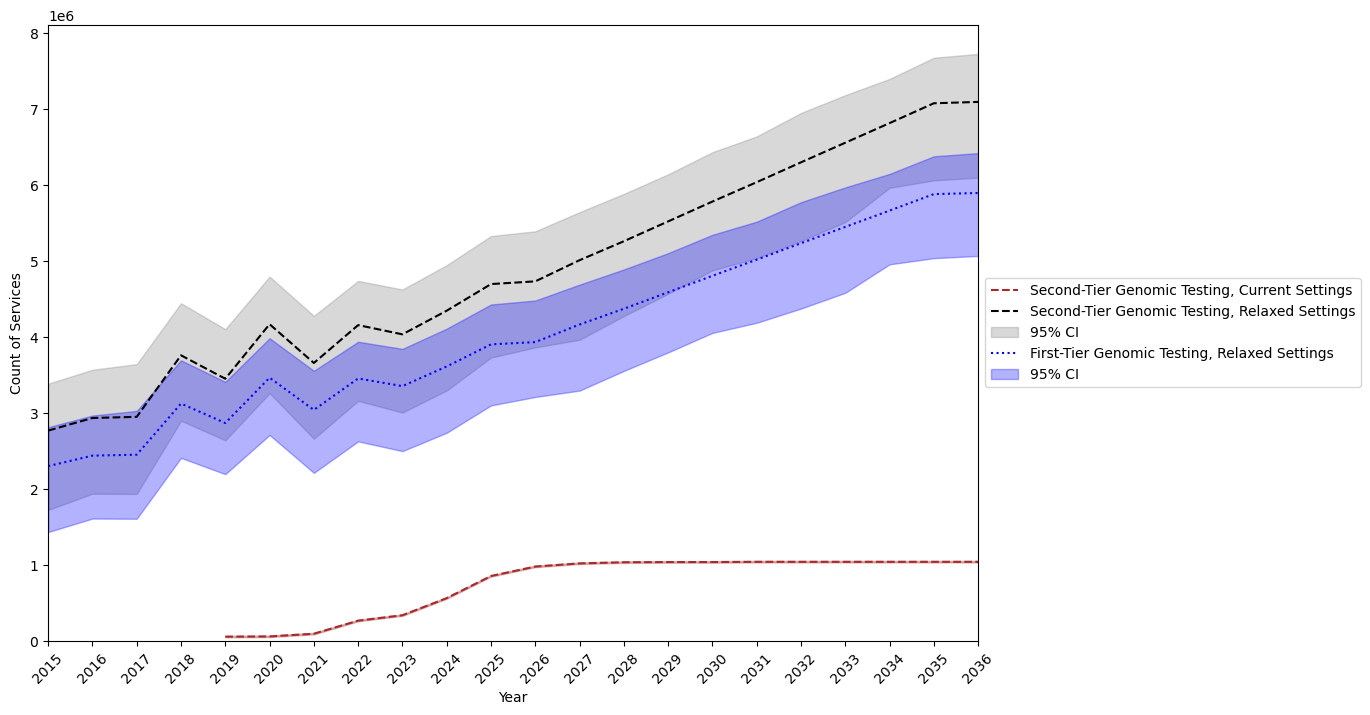

In [46]:
# Define the multipliers for the new graph.
multiplier_agg = 2465 + 501.415       # For the aggregated forecast.
multiplier_avg_sum = 2465 + 501.415     # For the first version of the average forecast.
multiplier_avg = 2465                 # For the second version of the average forecast.

fig, ax = plt.subplots(figsize=(12, 8))

# Plot Aggregated Forecast (scaled by 2465+501.415)
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * multiplier_agg)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * multiplier_agg)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * multiplier_agg)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color='brown',
            label="Second-Tier Genomic Testing, Current Settings")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color='brown', alpha=0.3)

# Plot Average Forecast with multiplier = 2465+501.415
avg_pred_scaled_sum = np.rint(avg_forecast * multiplier_avg_sum)
avg_ci_lower_scaled_sum = np.rint(avg_ci_lower * multiplier_avg_sum)
avg_ci_upper_scaled_sum = np.rint(avg_ci_upper * multiplier_avg_sum)
ax.plot(common_years_avg, avg_pred_scaled_sum, linestyle='--', color='black',
        label="Second-Tier Genomic Testing, Relaxed Settings")
ax.fill_between(common_years_avg, avg_ci_lower_scaled_sum, avg_ci_upper_scaled_sum,
                color='gray', alpha=0.3, label="95% CI")

# Plot Average Forecast with multiplier = 2465
avg_pred_scaled = np.rint(avg_forecast * multiplier_avg)
avg_ci_lower_scaled = np.rint(avg_ci_lower * multiplier_avg)
avg_ci_upper_scaled = np.rint(avg_ci_upper * multiplier_avg)
ax.plot(common_years_avg, avg_pred_scaled, linestyle=':', color='blue',
        label="First-Tier Genomic Testing, Relaxed Settings")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='blue', alpha=0.3, label="95% CI")

# Determine global x-axis limits based on the available data.
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
#ax.set_title("Aggregated and Average Forecasts with Alternative Multipliers")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Viz - Utilisation - Grouped - Quarterly

/tmp/ipykernel_4286/4172278375.py:79: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  full_date_range = pd.date_range(start=grouped_secondary_groups.index.min(),


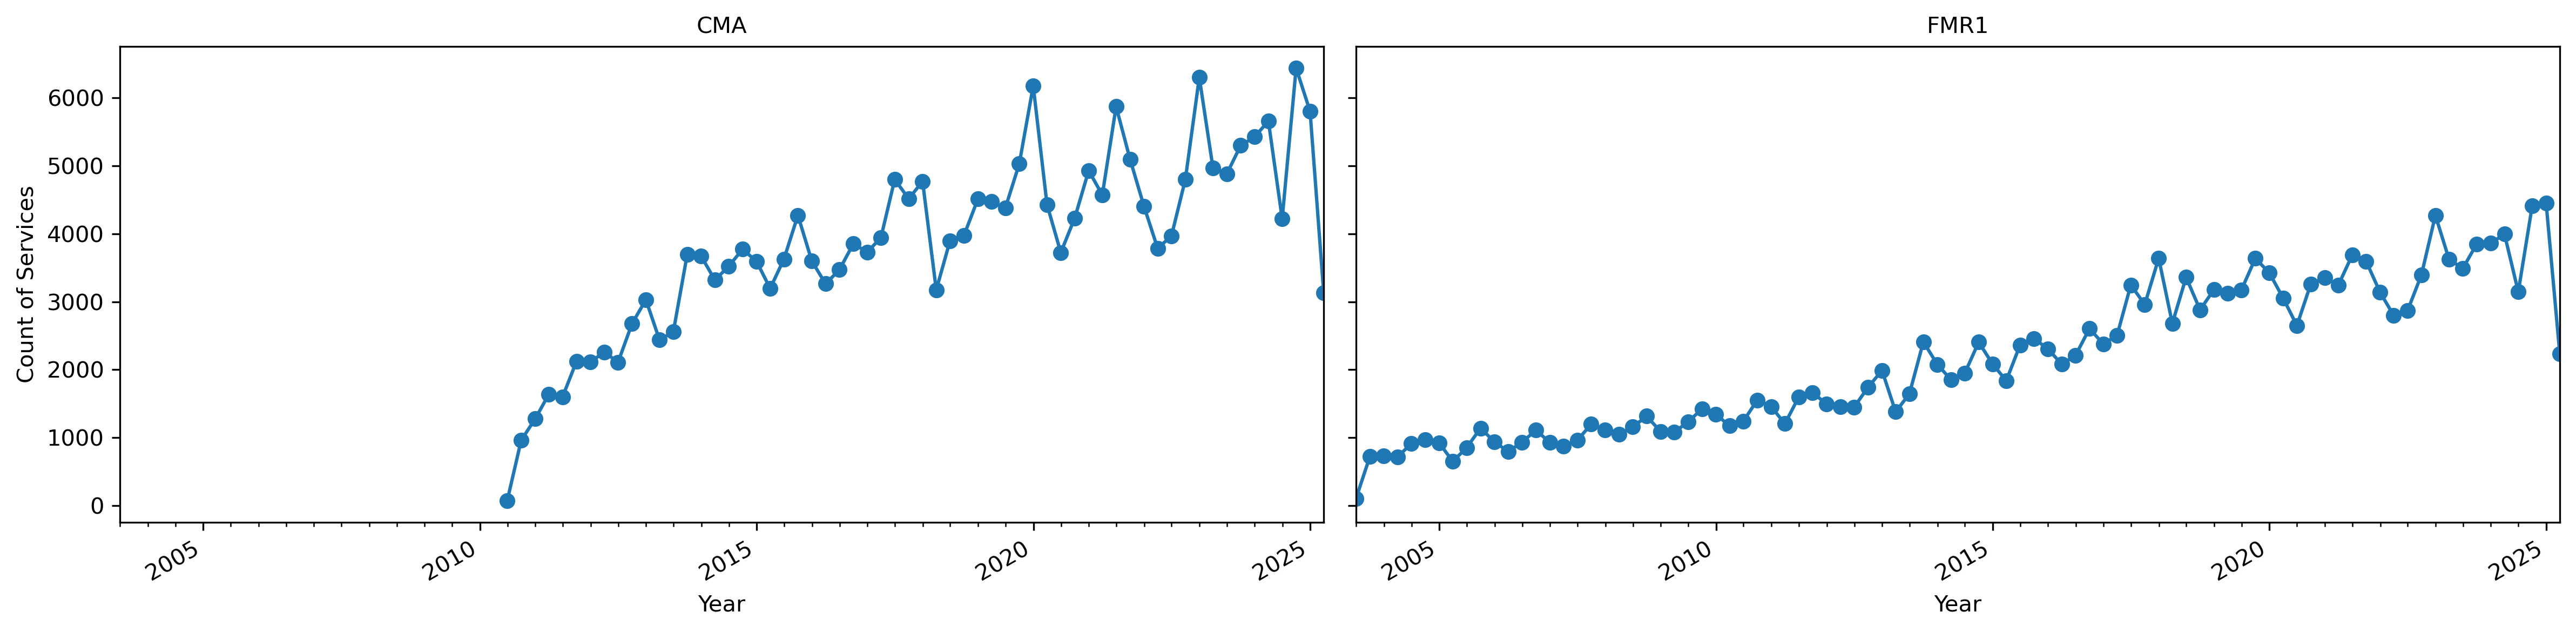

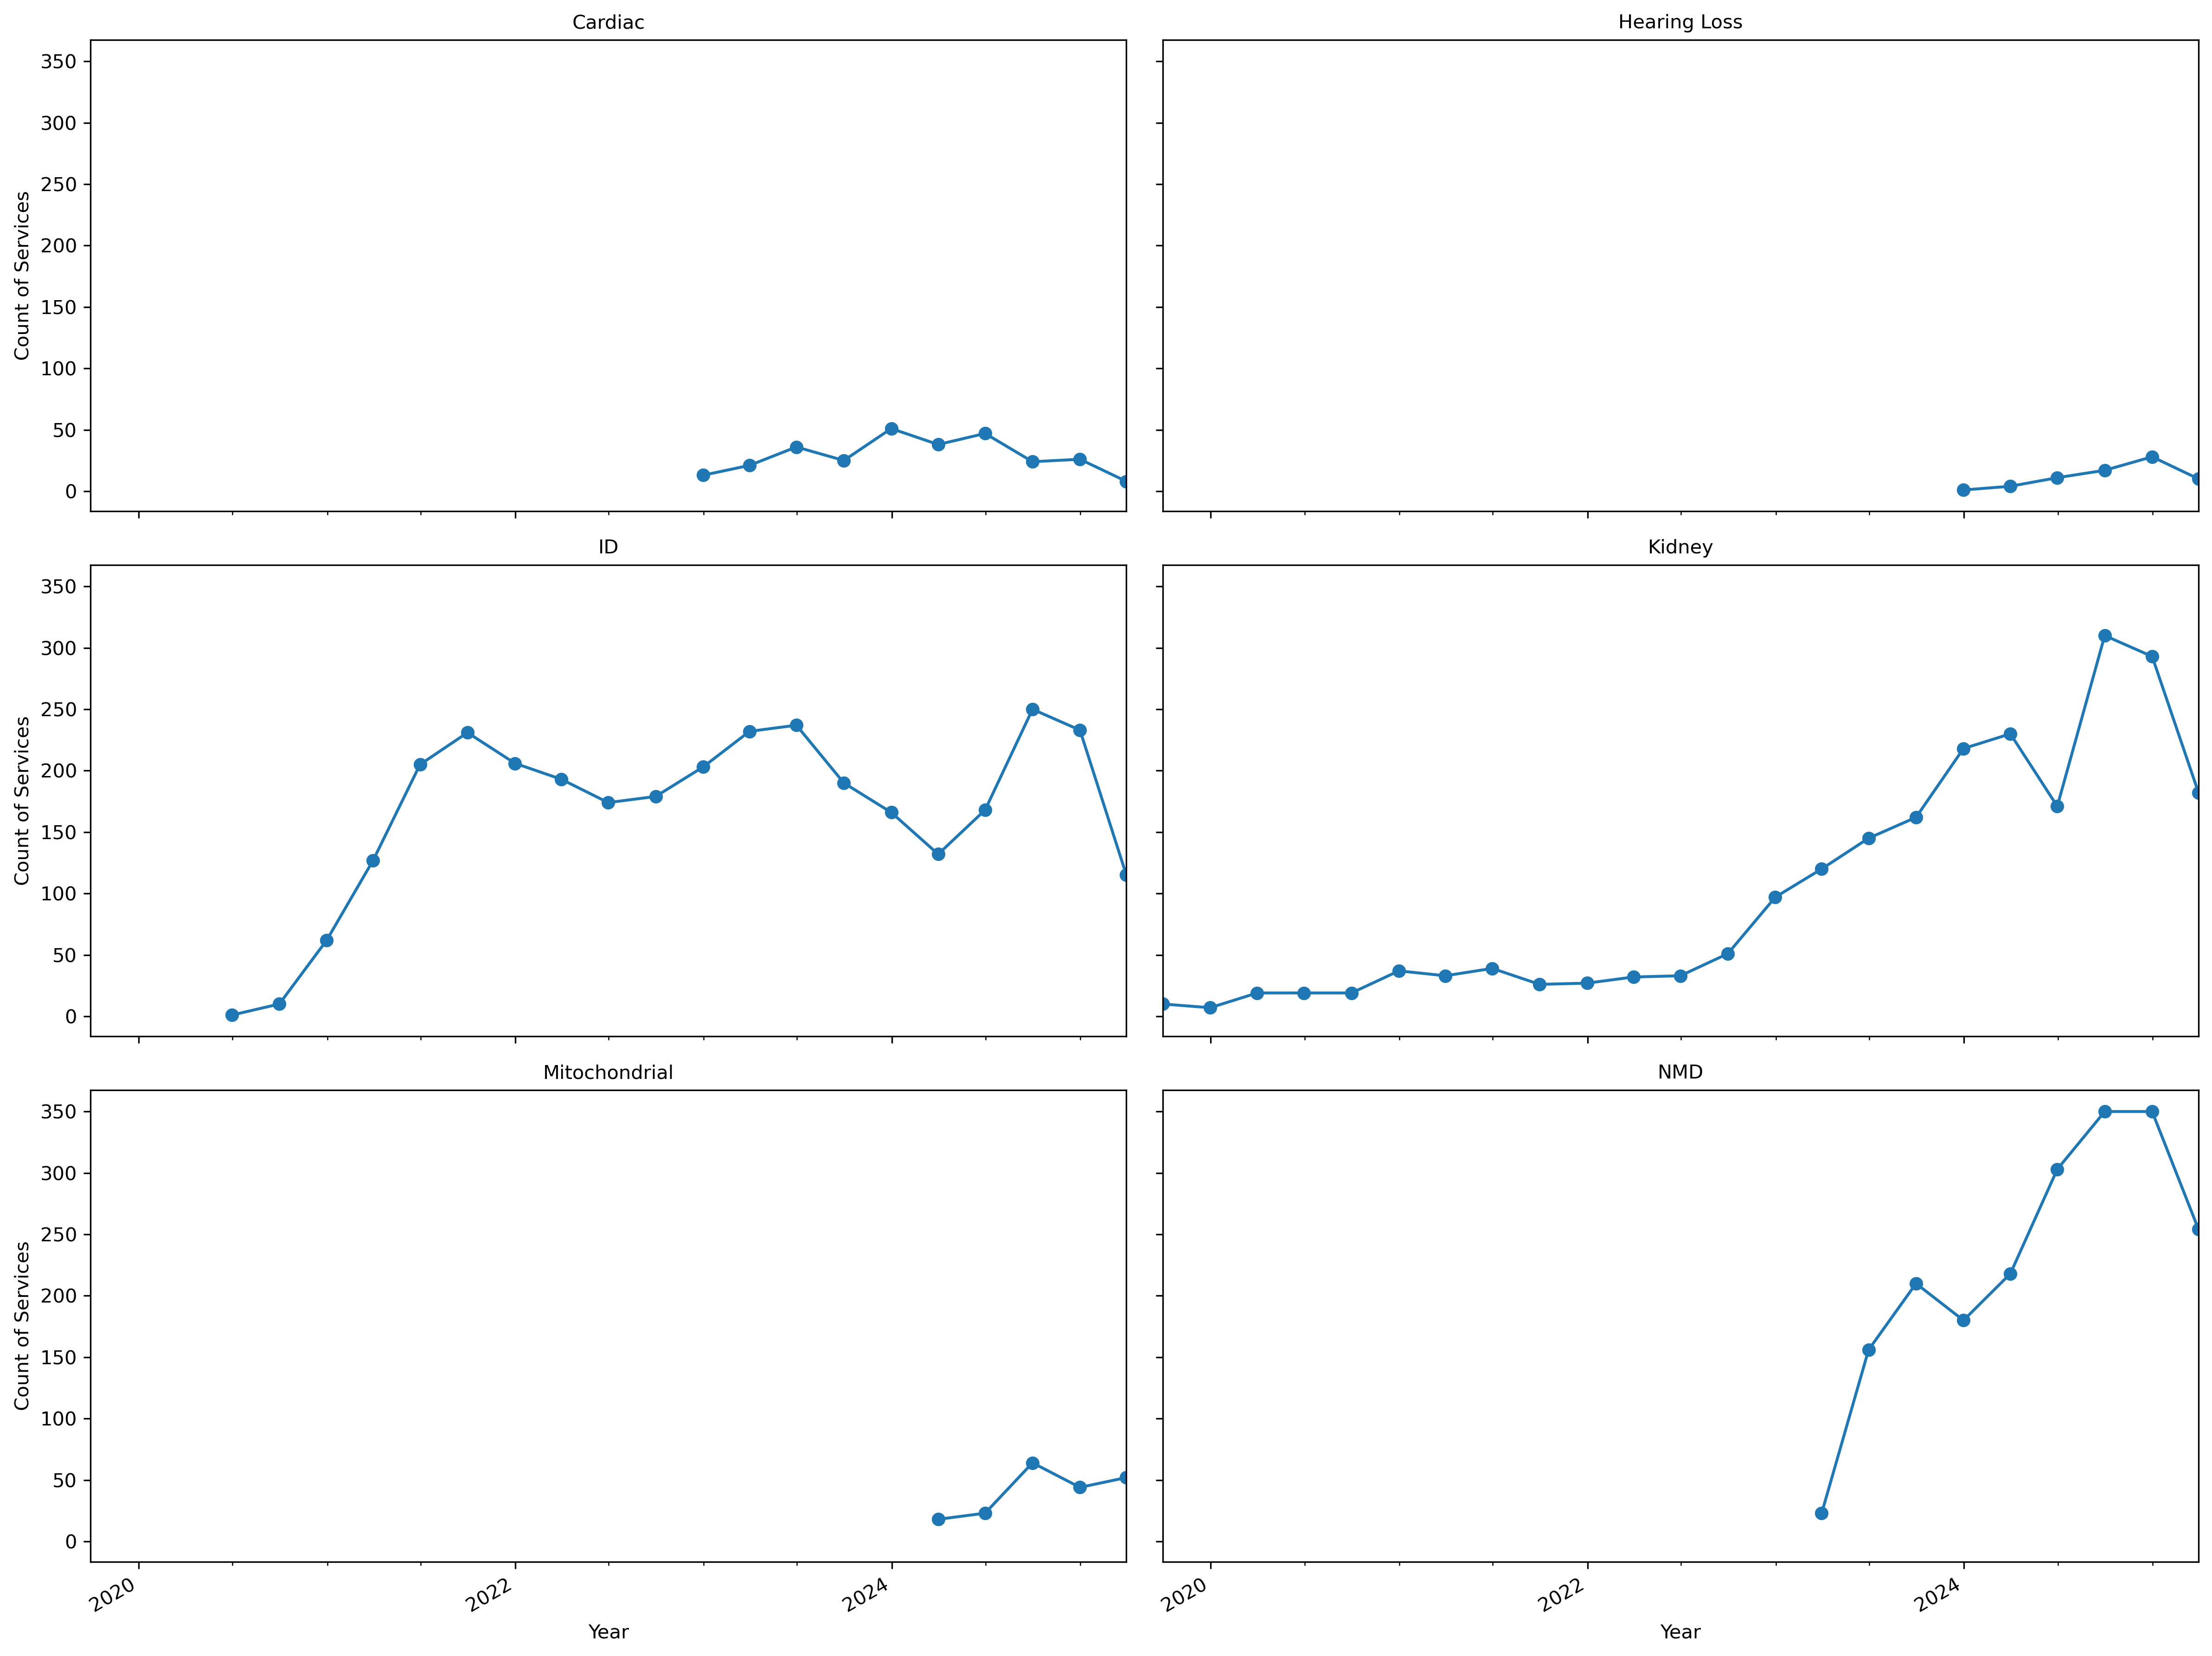

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import math

# Inline plotting for Jupyter
%matplotlib inline

register_matplotlib_converters()

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Update the items to include:
# - Exclude KT-NB ('73287') and KT-BL ('73289')
# - Add new groups: Mitochondrial, Hearing Loss, and Cardiac
items_to_include = [
    '73292', '73298', '73300', '73358', '73359', '73401', '73402', '73422', 
    '73456', '73457', '73460',  # Mitochondrial group
    '73440', '73441', '73444',  # Hearing Loss group
    '73416'         # Cardiac group
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Identify primary items (individual items) and secondary items (to be grouped)
# Drop KT-NB ('73287') and KT-BL ('73289') from the primary list.
primary_items = ['73292', '73300']
secondary_items = [item for item in items_to_include if item not in primary_items]

# Aggregate 'Value' by quarter for each item
grouped_data = filtered_data.groupby('Item')['Value'].resample('QE').sum()

# Only keep those primary items that exist in the aggregated data
available_primary_items = [item for item in primary_items if item in grouped_data.index.get_level_values('Item')]

# Define custom titles for primary items
custom_titles = {
    '73292': 'CMA',
    '73300': 'FMR1',
}

# --- Order primary items alphabetically by title (or by item if no title) ---
available_primary_items = sorted(available_primary_items, key=lambda x: custom_titles.get(x, x))

# Define secondary groupings (aggregated groups):
# Note: "CS" has now been changed to "ID" with the same underlying codes.
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'ID': ['73358', '73359'],
    'Mitochondrial': ['73456', '73457', '73460'],
    'Hearing Loss': ['73440', '73441', '73444'],
    'Cardiac': ['73416']
}

# Aggregate secondary groups by summing their values (for each quarter)
grouped_secondary_groups = pd.DataFrame()
for group_name, codes in group_definitions.items():
    available_codes = [code for code in codes if code in grouped_data.index.get_level_values('Item')]
    if available_codes:
        group_series = grouped_data.loc[available_codes].groupby(level='Month').sum()
        grouped_secondary_groups[group_name] = group_series

# Include the separate NMD item (code '73422') as its own series.
if '73422' in grouped_data.index.get_level_values('Item'):
    nmd_series = grouped_data.loc['73422']
    nmd_series = nmd_series.groupby(level='Month').sum()
    grouped_secondary_groups['NMD'] = nmd_series

# Ensure that all expected secondary groups are present.
expected_secondary_groups = ['Kidney', 'ID', 'Mitochondrial', 'Hearing Loss', 'Cardiac', 'NMD']
if not grouped_secondary_groups.empty:
    full_date_range = pd.date_range(start=grouped_secondary_groups.index.min(),
                                    end=grouped_secondary_groups.index.max(), freq='Q')
else:
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='Q')

for group in expected_secondary_groups:
    if group not in grouped_secondary_groups.columns:
        grouped_secondary_groups[group] = pd.Series(0, index=full_date_range)

# Order secondary groups alphabetically
sorted_secondary_groups = sorted(grouped_secondary_groups.columns)

# Reorder columns in the DataFrame accordingly.
grouped_secondary_groups = grouped_secondary_groups[sorted_secondary_groups]

# Create a unified plotting function that orders plots alphabetically and adds a margin so that values don't go outside the plot range.
def create_subplots(items, data_source, x_range=None, filename=None, title_mapping=None, major_tick_interval=5):
    num_items = len(items)
    cols = 2  # Set to 3 columns
    rows = math.ceil(num_items / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows), dpi=300, sharex=True, sharey=True)
    axes = axes.flatten() if num_items > 1 else [axes]

    # Determine overall y-axis limits for consistency
    if isinstance(data_source, pd.DataFrame):
        y_min = data_source[items].min().min()
        y_max = data_source[items].max().max()
    else:
        y_min = data_source.loc[items].min()
        y_max = data_source.loc[items].max()
    
    # Add a margin (5% of the range or default margin when range is 0)
    if y_min == y_max:
        y_margin = 1
    else:
        y_margin = 0.05 * (y_max - y_min)
    
    y_min_plot = y_min - y_margin
    y_max_plot = y_max + y_margin

    for ax, item in zip(axes, items):
        if isinstance(data_source, pd.DataFrame):
            item_data = data_source[item]
        else:
            item_data = data_source.loc[item]
        title = title_mapping.get(item, item) if title_mapping is not None else item
        ax.plot(item_data.index, item_data, marker='o', linestyle='-')
        if x_range:
            ax.set_xlim(x_range)
        ax.set_ylim(y_min_plot, y_max_plot)
        ax.set_title(title, fontsize=10)

    # Hide any unused subplots
    for ax in axes[len(items):]:
        ax.axis('off')

    # Configure axis labels
    for ax in axes[-cols:]:
        ax.set_xlabel('Year', fontsize=10)
    for ax in axes[::cols]:
        ax.set_ylabel('Count of Services', fontsize=10)

    # Configure x-axis ticks and formatting
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(base=major_tick_interval))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    if filename:
        fig.savefig(filename, format='svg', dpi=300)

# Determine x-axis ranges for primary and secondary items
primary_x_range = (
    grouped_data.loc[available_primary_items].index.get_level_values('Month').min(),
    grouped_data.loc[available_primary_items].index.get_level_values('Month').max(),
)
secondary_x_range = (
    grouped_secondary_groups.index.min(),
    grouped_secondary_groups.index.max(),
)

# Plot primary items (individual items) in alphabetical order
create_subplots(
    available_primary_items,
    data_source=grouped_data,
    x_range=primary_x_range,
    filename="PrimaryAxisItems_3cols.svg",
    title_mapping=custom_titles,
    major_tick_interval=5
)

# Plot secondary items (aggregated groups + separate NMD) in alphabetical order
create_subplots(
    sorted_secondary_groups,
    data_source=grouped_secondary_groups,
    x_range=secondary_x_range,
    filename="SecondaryAxisGroups_3cols.svg",
    title_mapping=None,  # The column names will be used as titles
    major_tick_interval=2
)


### Viz - Utilisation - Grouped - Monthly

/tmp/ipykernel_4286/2471960410.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Item'] = filtered_data['Item'].apply(


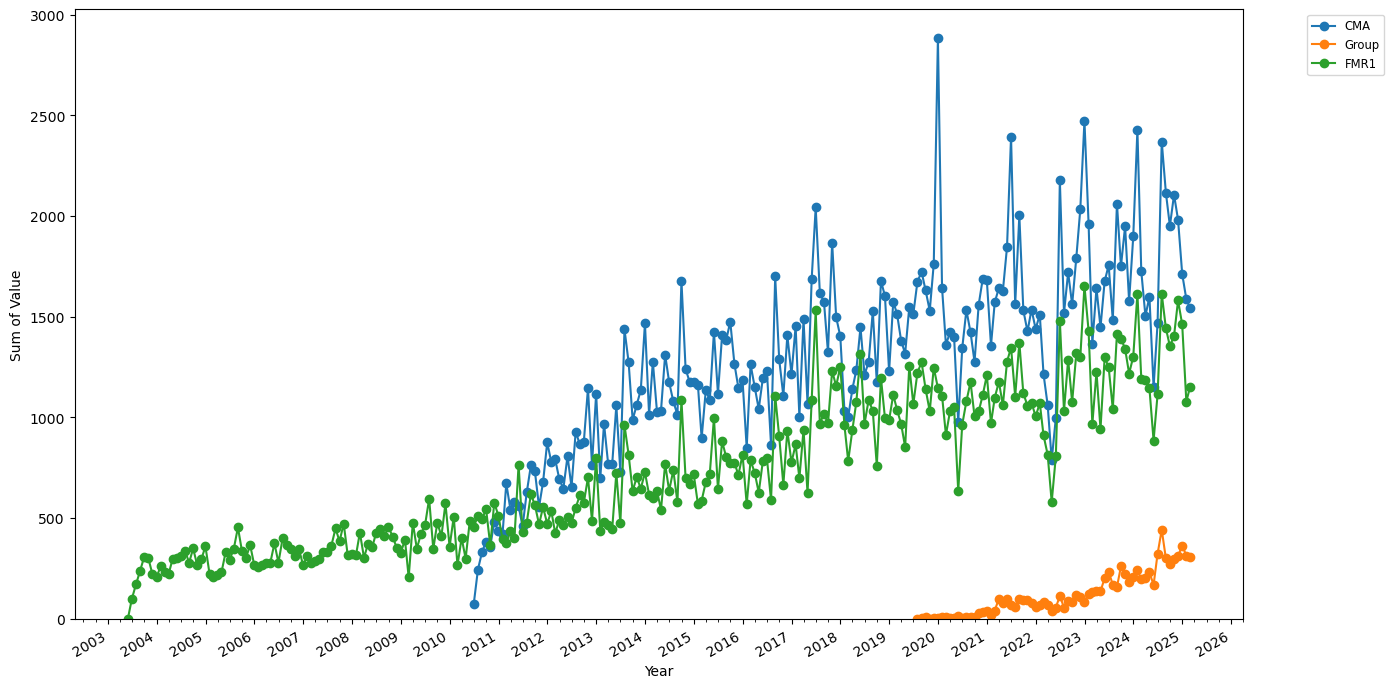

Plot saved as: MonthlySum_GroupedItems.svg


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Load the data
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Convert the "Value" column to absolute values
data['Value'] = data['Value'].abs()

# Filter the data to include only specific "Item" categories,
# excluding KT-NB ('73287') and KT-BL ('73289')
items_to_include = [
    '73292', '73298', '73300', '73358', '73359', '73401', '73402', '73422',
    '73456', '73457', '73460',  # Mitochondrial group
    '73440', '73441', '73444',  # Hearing Loss group
    '73416'                   # Cardiac group
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Define a dictionary to map item IDs to custom titles.
custom_titles = {
    '73292': 'CMA',
    '73298': 'ALP',
    '73300': 'FMR1',
    '73358': 'CS-P',
    '73359': 'CS-T',
    '73401': 'SKD',
    '73402': 'CKD',
    '73422': 'NMD'
}

# For the purpose of the plot we wish to display only a select few items individually.
# Items not in the list below will be grouped under "Group".
items_to_keep = ['73292', '73300']

# Update the "Item" column:
# Use the custom title for items to keep; all others (including the newly added ones) are set to "Group".
filtered_data['Item'] = filtered_data['Item'].apply(
    lambda x: custom_titles[x] if x in items_to_keep else 'Group'
)

# Plotting all items (and the group) on the same plot
plt.figure(figsize=(14, 7))

# Loop through each unique item label in the filtered data
for item in filtered_data['Item'].unique():
    # Resample by month-end and sum the "Value" column
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum()
    plt.plot(item_data.index, item_data, marker='o', linestyle='-', label=item)

# Set labels and format the x-axis
plt.xlabel('Year')
plt.ylabel('Sum of Value')
plt.ylim(bottom=0)

# Major ticks every year; minor ticks at January, April, July, October
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()  # Auto-format date labels

# Place legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()

# Save the figure as an SVG file
output_file = "MonthlySum_GroupedItems.svg"
plt.savefig(output_file, format='svg', dpi=300)
plt.show()

print(f"Plot saved as: {output_file}")


### Viz - Diffusion - 5Y - Grouped

/tmp/ipykernel_4286/362580726.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Group"] = filtered_data["Item"].apply(assign_group)
/tmp/ipykernel_4286/362580726.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Group'] == group]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarni

Error fitting Gompertz for group Kidney (Kidney): Optimal parameters not found: The maximum number of function evaluations is exceeded.


/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/tmp/ipykernel_4286/362580726.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Group'] == group]['Value'].resample('M').sum().dropna()
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/doughnut/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except

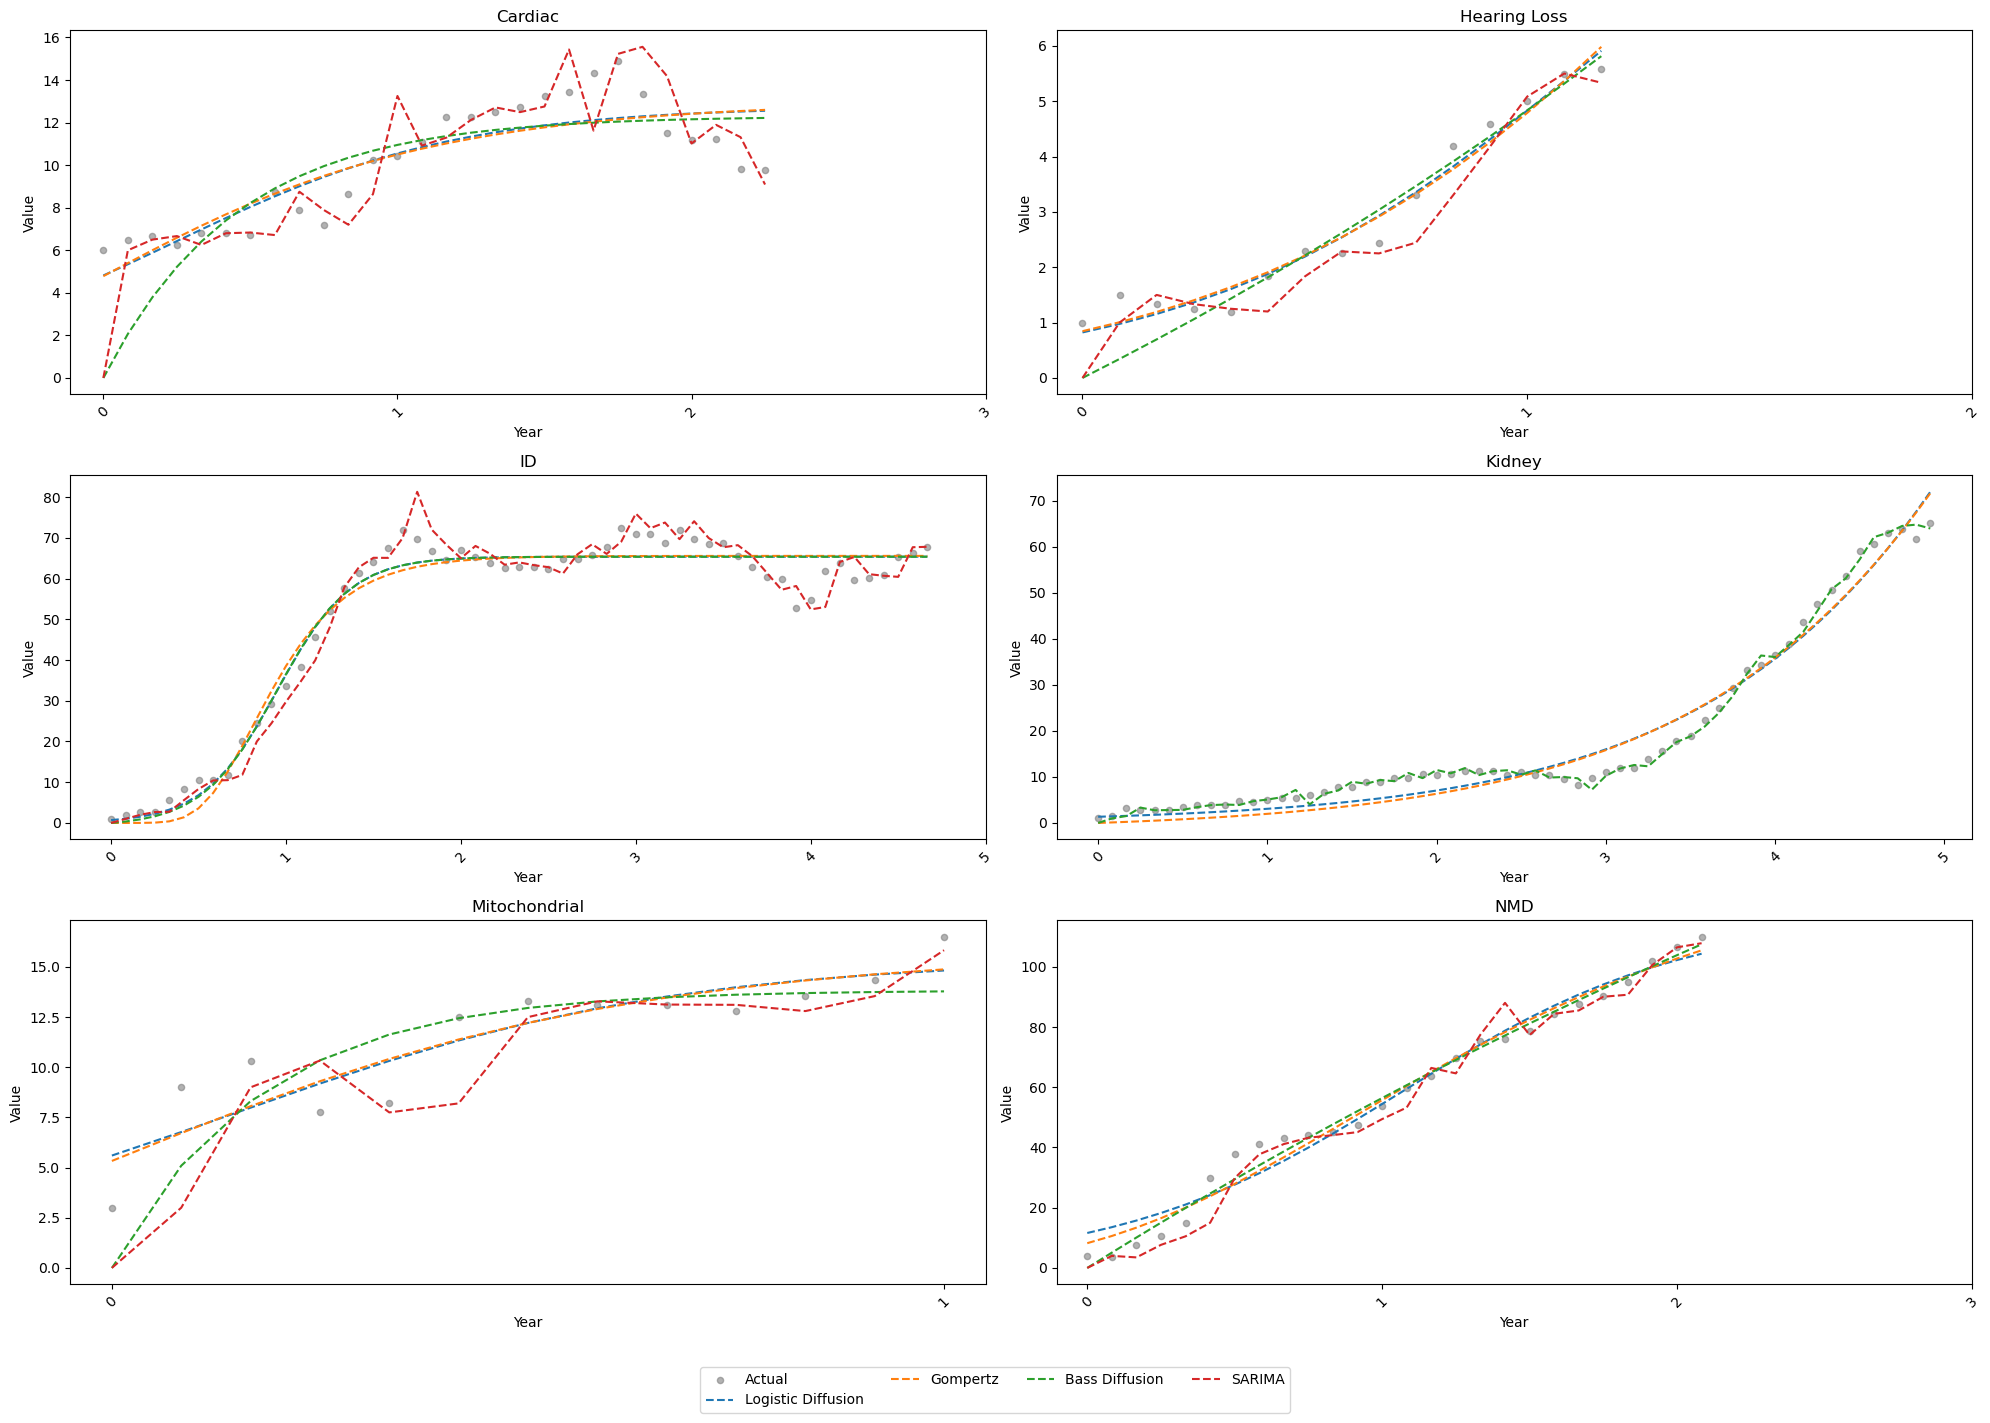

            Group               Model    r2   MAE  MAPE
0         Cardiac  Logistic Diffusion  0.74  1.15  0.12
1         Cardiac            Gompertz  0.72  1.20  0.12
2         Cardiac      Bass Diffusion  0.43  1.58  0.19
3         Cardiac              SARIMA  0.60  1.16  0.13
4    Hearing Loss  Logistic Diffusion  0.97  0.24  0.12
5    Hearing Loss            Gompertz  0.97  0.25  0.12
6    Hearing Loss      Bass Diffusion  0.91  0.37  0.22
7    Hearing Loss              SARIMA  0.91  0.37  0.19
8              ID  Logistic Diffusion  0.97  3.07  0.10
9              ID            Gompertz  0.96  3.62  0.17
10             ID      Bass Diffusion  0.97  3.15  0.13
11             ID              SARIMA  0.98  2.72  0.10
12         Kidney  Logistic Diffusion  0.97  2.93  0.27
13         Kidney      Bass Diffusion  0.96  3.35  0.39
14         Kidney              SARIMA  1.00  0.86  0.10
15  Mitochondrial  Logistic Diffusion  0.79  1.35  0.18
16  Mitochondrial            Gompertz  0.80  1.3

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings

# Optionally filter out some warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Only include items that are needed:
# Kidney: "73298", "73401", "73402"
# CS: "73358", "73359"
# NMD: "73422"
# Mitochondrial: "73456", "73457", "73460"
# Hearing Loss: "73440", "73441", "73444"
# Cardiac: "73416"
items_to_include = [
    '73298', '73358', '73359', '73401', '73402', '73422',
    '73456', '73457', '73460',  # Mitochondrial group
    '73440', '73441', '73444',  # Hearing Loss group
    '73416'                   # Cardiac group
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Update custom titles (if needed; here only NMD is customized)
custom_titles = {
    '73422': 'NMD'
}

# Create a new column called "Group" to assign each row to a combined group
def assign_group(item):
    if item in ["73298", "73401", "73402"]:
        return "Kidney"
    elif item in ["73358", "73359"]:
        return "ID"  # Changed from "CS" to "ID"
    elif item in ["73422"]:
        return "NMD"
    elif item in ["73456", "73457", "73460"]:
        return "Mitochondrial"
    elif item in ["73440", "73441", "73444"]:
        return "Hearing Loss"
    elif item in ["73416"]:
        return "Cardiac"
    else:
        return custom_titles.get(item, item)

filtered_data["Group"] = filtered_data["Item"].apply(assign_group)

# Determine which groups have data
group_data_counts = filtered_data.groupby("Group")["Value"].count()
valid_groups = group_data_counts[group_data_counts > 0].index.tolist()

# Define model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

model_results = []

# Plot settings: create a grid of subplots
n_groups = len(valid_groups)
cols = 2
rows = int(np.ceil(n_groups / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

# Loop over each valid group
for i, group in enumerate(valid_groups):
    display_name = group  # "Kidney", "CS", "NMD", "Mitochondrial", "Hearing Loss", or "Cardiac"
    
    # Resample data by month and sum the values for the group
    group_data = filtered_data[filtered_data['Group'] == group]['Value'].resample('M').sum().dropna()
    
    # Apply a 12-month moving average to smooth the data
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first 5 years (60 months) of data
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after resampling and slicing. Skipping.")
        continue
    
    # Create a new time axis in years (0, 1, 2, ...)
    years = np.arange(len(group_data)) / 12.0

    # Setup models for fitting
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(years)
    
    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func, years, group_data, p0=p0, bounds=bounds, maxfev=10000
                )
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func, years, group_data, p0=p0, bounds=bounds, maxfev=10000
                )
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(
                    model_func, years, group_data, p0=p0, bounds=bounds, maxfev=10000
                )
            predicted = model_func(years, *params)
            r2 = r2_score(group_data, predicted)
            mae = mean_absolute_error(group_data, predicted)
            mape = mean_absolute_percentage_error(group_data, predicted)
            results[model_name] = {'r2': r2, 'MAE': mae, 'MAPE': mape, 'predicted': predicted}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group} ({display_name}): {e}")
    
    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(group_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.fittedvalues
        sarima_r2 = r2_score(group_data, sarima_pred)
        sarima_mae = mean_absolute_error(group_data, sarima_pred)
        sarima_mape = mean_absolute_percentage_error(group_data, sarima_pred)
        results["SARIMA"] = {'r2': sarima_r2, 'MAE': sarima_mae, 'MAPE': sarima_mape, 'predicted': sarima_pred}
    except Exception as e:
        print(f"Error fitting SARIMA for group {group} ({display_name}): {e}")
    
    # Store the model metrics for later reporting
    for model_name, metrics in results.items():
        model_results.append({
            'Group': group,
            'Model': model_name,
            'r2': metrics['r2'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })
    
    # Plot actual vs. predicted values using the new time axis in years
    ax = axes[i]
    ax.scatter(years, group_data, label='Actual', color='gray', alpha=0.6, s=20)
    for model_name, metrics in results.items():
        ax.plot(years, metrics['predicted'], label=model_name, linestyle='--')
    ax.set_title(display_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.set_xticks(np.arange(0, np.ceil(years.max()) + 1))
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Build a global legend using only one set of model types
legend_entries = {}
for ax in axes:
    if not ax.has_data():
        continue
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in legend_entries:
            legend_entries[label] = handle

fig.legend(legend_entries.values(), legend_entries.keys(),
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.05))
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

# Convert model results to a DataFrame and format values
results_df = pd.DataFrame(model_results)
for column in ['MAE', 'MAPE', 'r2']:
    results_df[column] = results_df[column].apply(
        lambda x: f"{x:.2e}" if abs(x) >= 100000 else f"{x:.2f}"
    )
print(results_df)


/tmp/ipykernel_4286/2040200999.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()


Error fitting Gompertz for group Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_4286/2040200999.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2040200999.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2040200999.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2040200999.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2040200999.py:65: Future

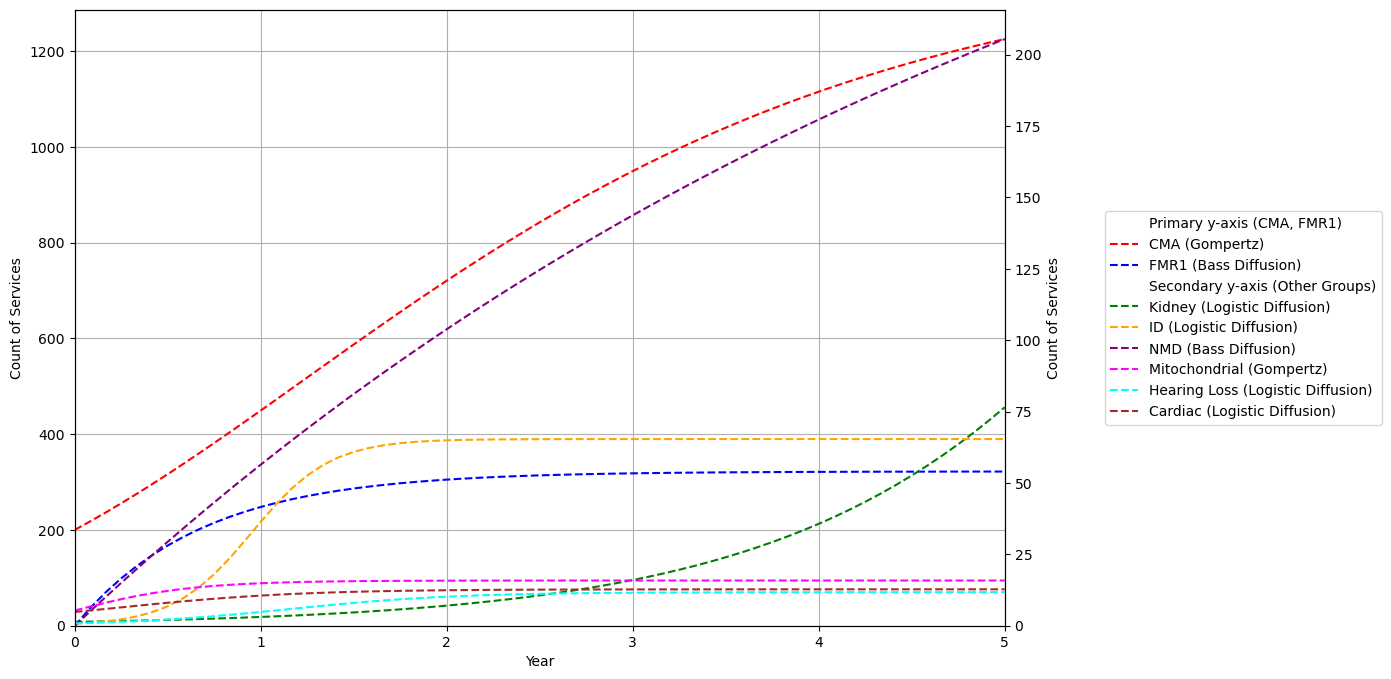

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
import warnings

# Optionally, filter out some warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by item codes (renaming CS to ID)
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'ID': ['73358', '73359'],  # Previously 'CS'
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300'],
    'Mitochondrial': ['73456', '73457', '73460'],
    'Hearing Loss': ['73440', '73441', '73444'],
    'Cardiac': ['73416']
}

# Assign distinct colours for each group
color_map = {
    'Kidney': 'green',
    'ID': 'orange',  # Renamed from 'CS'
    'NMD': 'purple',
    'CMA': 'red',
    'FMR1': 'blue',
    'Mitochondrial': 'magenta',
    'Hearing Loss': 'cyan',
    'Cardiac': 'brown'
}

# Filter the data to include only the items that are part of our groups
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# This list will hold the best model predictions and related data per group
best_predictions = []

# Loop over each group to fit the models and generate predictions
for group, items in group_definitions.items():
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    group_data = group_data.iloc[:60]
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    fitted_years = np.arange(len(group_data)) / 12.0

    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    for model_name, model_func in models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data, p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data, p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data, p0=p0, bounds=bounds, maxfev=10000)

            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        full_years = np.linspace(0, 5, 61)
        best_pred_full = best_model_metrics['func'](full_years, *best_model_metrics['params'])
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': full_years,
            'Predicted': best_pred_full
        })

# Create the plot
fig, ax_primary = plt.subplots(figsize=(12, 8))
ax_secondary = ax_primary.twinx()

ax_primary.grid(True)
ax_primary.set_axisbelow(True)
ax_secondary.grid(False)

primary_handles, primary_labels = [], []
secondary_handles, secondary_labels = [], []

for bp in best_predictions:
    color = color_map.get(bp['Group'], None)
    label = f"{bp['Group']} ({bp['BestModel']})"
    if bp['Group'] in ["CMA", "FMR1"]:
        line, = ax_primary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        primary_handles.append(line)
        primary_labels.append(label)
    else:
        line, = ax_secondary.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color, label=label)
        secondary_handles.append(line)
        secondary_labels.append(label)

ax_primary.set_xlim(0, 5)
ax_primary.set_ylim(bottom=0)
ax_secondary.set_ylim(bottom=0)

ax_primary.set_xlabel("Year")
ax_primary.set_ylabel("Count of Services")
ax_secondary.set_ylabel("Count of Services")

dummy_primary = Line2D([], [], linestyle='None', label="Primary y-axis (CMA, FMR1)")
dummy_secondary = Line2D([], [], linestyle='None', label="Secondary y-axis (Other Groups)")

combined_handles = [dummy_primary] + primary_handles + [dummy_secondary] + secondary_handles
combined_labels = [dummy_primary.get_label()] + primary_labels + [dummy_secondary.get_label()] + secondary_labels

ax_primary.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.show()


/tmp/ipykernel_4286/2865230542.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2865230542.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2865230542.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2865230542.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
/tmp/ipykernel_4286/2865230542.py:70: Future

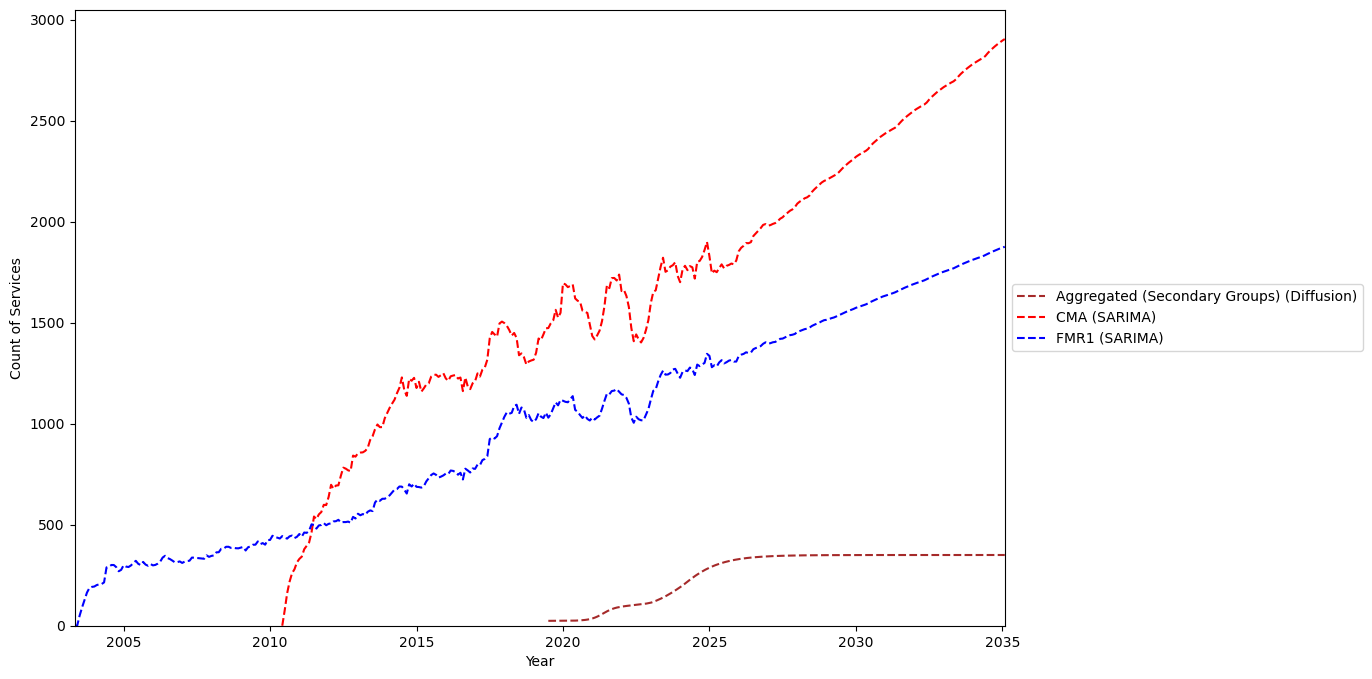

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Clean and prepare the data
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Define groups by original item codes:
# - Drop: KT-NB (73287) and KT-BL (73289)
# - Group Kidney: ALP (73298), SKD (73401) and CKD (73402)
# - Group CS: CS-P (73358) and CS-T (73359)
# - Group NMD: remains as NMD (73422)
# - Individual items: CMA (73292) and FMR1 (73300)
# 
# *** Updates below: Additional groups have been added ***
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'Mitochondrial': ['73456', '73457', '73460'],  # Mitochondrial group
    'Hearing Loss': ['73440', '73441', '73444'],     # Hearing Loss group
    'Cardiac': ['73416'],                             # Cardiac group
    'CMA': ['73292'],
    'FMR1': ['73300']
}

# Assign colours for primary groups (CMA and FMR1)
color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
# For the aggregated secondary forecast, assign its own color:
agg_color = 'brown'

# Filter data to include only relevant items
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# List to hold best model forecasts for each group
best_predictions = []

# Loop through each group
for group, items in group_definitions.items():
    # Aggregate monthly data by summing values
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('M').sum().dropna()
    
    # Smooth data with a 12-month moving average
    group_data = group_data.rolling(window=12, min_periods=1).mean()
    
    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to actual decimal years (e.g. 2010.25 for April 2010)
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    # Dictionary to hold candidate models and their performance
    results = {}
    
    # --- Diffusion Models ---
    diffusion_models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    max_val = group_data.max()
    mid_t = np.median(fitted_years)
    
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")
    
    # --- SARIMA Model (only for CMA and FMR1) ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Forecast from the first observed date to 10 years beyond the last observed date
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='M')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            # Convert forecast index to decimal years
            forecast_years_sarima = forecast_index.year + (forecast_index.month - 1) / 12.0
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast.values}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")
    
    # --- Select Best Model and Generate Forecast ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
        else:
            # Forecast from the first observed decimal year to 10 years beyond the last observed year
            start_year = fitted_years[0]
            end_year = fitted_years[-1]
            num_points = int((end_year - start_year + 10) * 12) + 1  # monthly resolution
            forecast_years = np.linspace(start_year, end_year + 10, num_points)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
        
        best_predictions.append({
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full
        })

# --- Combine Secondary Groups ---
# Secondary groups: all groups except the primary ones (CMA and FMR1) will be aggregated
secondary_groups = [bp for bp in best_predictions if bp['Group'] not in ["CMA", "FMR1"]]
aggregated_secondary = None
if secondary_groups:
    # Determine a common forecast time grid from the union of their time intervals
    common_start = min(bp['Years'][0] for bp in secondary_groups)
    common_end = max(bp['Years'][-1] for bp in secondary_groups)
    num_points = int((common_end - common_start) * 12) + 1
    common_time = np.linspace(common_start, common_end, num_points)
    
    # Sum the forecasts after re-interpolating each forecast onto the common grid
    aggregated_forecast = np.zeros_like(common_time)
    for bp in secondary_groups:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    
    aggregated_secondary = {
        'Group': 'Aggregated (Secondary Groups)',
        'BestModel': "Diffusion",  # they all use diffusion models
        'Years': common_time,
        'Predicted': aggregated_forecast
    }

# --- Prepare Final Predictions ---
# Primary groups: CMA and FMR1 remain as individual curves.
primary_groups = [bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]]
# Final predictions: aggregated secondary plus primary groups
final_predictions = []
if aggregated_secondary is not None:
    final_predictions.append(aggregated_secondary)
final_predictions.extend(primary_groups)

# --- Plotting on a Single y-axis ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each forecast curve with distinct colours
handles = []
labels = []
for bp in final_predictions:
    if bp['Group'] in ["CMA", "FMR1"]:
        color = color_map.get(bp['Group'], None)
    else:
        color = agg_color
    line, = ax.plot(bp['Years'], bp['Predicted'], linestyle='--', color=color,
                    label=f"{bp['Group']} ({bp['BestModel']})")
    handles.append(line)
    labels.append(f"{bp['Group']} ({bp['BestModel']})")

# Set x-axis limits based on overall forecast period
global_start = min(bp['Years'][0] for bp in final_predictions)
global_end = max(bp['Years'][-1] for bp in final_predictions)
ax.set_xlim(global_start, global_end)
# Force y-axis to start at 0
ax.set_ylim(bottom=0)

# Set axis labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
# ax.set_title("Best Performing Model Predictions (Forecast 10 Years Beyond Data)")

# Place the legend on the right side of the plot
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


### Table - Utilisation - Annual

In [70]:
import pandas as pd

# -- Load and prepare the data --
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Convert Month column to datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# Filter the data to include only the specific item categories
items_to_include = [
    '73292', '73298', '73299', '73358', '73359',
    '73360', '73395', '73401', '73402', '73416',
    '73422', '73425', '73426', '73440', '73440', 
    '73441', '73444', '73456', '73457', '73460'
]
filtered_data = data[data['Item'].isin(items_to_include)]

# Aggregate 'Value' by year (using 'YE' for year-end frequency)
annual_data = filtered_data['Value'].resample('YE').sum()

# Ensure the year is displayed correctly (only the year)
annual_data.index = annual_data.index.year

# Reverse the data for backward year calculation
annual_data = annual_data[::-1]

# Add reverse year index
reverse_years = range(1, len(annual_data) + 1)

# Convert to a DataFrame and add the reverse year index
annual_data_table = annual_data.reset_index()
annual_data_table.columns = ['Actual Year', 'Annual Count of Services']  # Explicitly rename columns
annual_data_table['Reverse Year'] = reverse_years
annual_data_table['Annual Count of Services'] = annual_data_table['Annual Count of Services'].astype(int)

# Reorder columns for clarity
annual_data_table = annual_data_table[['Reverse Year', 'Actual Year', 'Annual Count of Services']]

# Display the table
print(annual_data_table)


    Reverse Year  Actual Year  Annual Count of Services
0              1         2025                      3764
1              2         2024                     25542
2              3         2023                     22807
3              4         2022                     19866
4              5         2021                     20868
5              6         2020                     17511
6              7         2019                     20082
7              8         2018                     15558
8              9         2017                     18028
9             10         2016                     14315
10            11         2015                     14691
11            12         2014                     14205
12            13         2013                     12363
13            14         2012                     10074
14            15         2011                      7471
15            16         2010                      2314


In [71]:
annual_data_table

Reverse Year  Actual Year  Annual Count of Services
0              1         2025                      3764
1              2         2024                     25542
2              3         2023                     22807
3              4         2022                     19866
4              5         2021                     20868
5              6         2020                     17511
6              7         2019                     20082
7              8         2018                     15558
8              9         2017                     18028
9             10         2016                     14315
10            11         2015                     14691
11            12         2014                     14205
12            13         2013                     12363
13            14         2012                     10074
14            15         2011                      7471
15            16         2010                      2314

### Table - Diffusion - Annual - By Group

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Load the data (update file_path as needed)
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Strip whitespace from the "Item" column
data['Item'] = data['Item'].astype(str).str.strip()

# Ensure the "Month" column is treated as datetime and set as index
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -------------------------------------------------------------------
# Filter the data to include only specific "Item" categories.
# This list now includes individual tests (CMA, FMR1, NMD), items that will be
# combined into groups (CS, Kidney) as well as the new groups: Mitochondrial, Hearing Loss, and Cardiac.
items_to_include = [
    '73292',   # CMA (individual)
    '73300',   # FMR1 (individual)
    '73358',   # Part of CS group
    '73359',   # Part of CS group
    '73298',   # Part of Kidney group
    '73401',   # Part of Kidney group
    '73402',   # Part of Kidney group
    '73422',   # NMD (keep individual AND include in combined group)
    '73456', '73457', '73460',  # Mitochondrial group
    '73440', '73441', '73444',  # Hearing Loss group
    '73416'                    # Cardiac group
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# -- Create new virtual groups --

# CS group: combine items 73358 and 73359
cs_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
cs_group['Item'] = 'CS Combined'  # This will be mapped to "CS"

# Kidney group: combine items 73298, 73401, and 73402
kidney_group = (
    filtered_data[filtered_data['Item'].isin(['73298', '73401', '73402'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
kidney_group['Item'] = 'Kidney'

# Genomic Tests Combined group: combine items for CS, Kidney, and NMD
genomic_tests_group = (
    filtered_data[filtered_data['Item'].isin(['73358', '73359', '73298', '73401', '73402', '73422'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
genomic_tests_group['Item'] = 'Genomic Tests Combined'

# New Group: Mitochondrial group (combine items 73456, 73457, 73460)
mito_group = (
    filtered_data[filtered_data['Item'].isin(['73456', '73457', '73460'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
mito_group['Item'] = 'Mitochondrial'

# New Group: Hearing Loss group (combine items 73440, 73441, 73444)
hearing_group = (
    filtered_data[filtered_data['Item'].isin(['73440', '73441', '73444'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
hearing_group['Item'] = 'Hearing Loss'

# New Group: Cardiac group (single item: 73416)
cardiac_group = (
    filtered_data[filtered_data['Item'].isin(['73416'])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
cardiac_group['Item'] = 'Cardiac'

# Remove individual rows for items that are now grouped into CS, Kidney, Mitochondrial, Hearing Loss, and Cardiac,
# but keep NMD ('73422') as an individual item.
grouped_items = [
    '73358', '73359', 
    '73298', '73401', '73402',
    '73456', '73457', '73460',   # Mitochondrial
    '73440', '73441', '73444',   # Hearing Loss
    '73416'                    # Cardiac
]
filtered_data = filtered_data[~filtered_data['Item'].isin(grouped_items)]

# Append the combined groups back to the filtered data
filtered_data = pd.concat(
    [
        filtered_data.reset_index(),  # Remaining individual items (e.g., CMA, FMR1, NMD)
        cs_group,                     # CS group
        kidney_group,                 # Kidney group
        genomic_tests_group,          # Genomic Tests Combined group
        mito_group,                   # Mitochondrial group
        hearing_group,                # Hearing Loss group
        cardiac_group                 # Cardiac group
    ],
    ignore_index=True
)

# -------------------------------------------------------------------
# Create new Group 2 by aggregating all the above virtual groups.
# This includes CS Combined, Kidney, Genomic Tests Combined, Mitochondrial, Hearing Loss, and Cardiac.
group2_virtual_codes = ['CS Combined', 'Kidney', 'Genomic Tests Combined', 'Mitochondrial', 'Hearing Loss', 'Cardiac']
group2 = (
    filtered_data[filtered_data['Item'].isin(group2_virtual_codes)]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
group2['Item'] = 'Group 2'

# Append Group 2 to the filtered data
filtered_data = pd.concat(
    [
        filtered_data,
        group2
    ],
    ignore_index=True
)

# Re-set the index to Month and verify groups are included
filtered_data.set_index('Month', inplace=True)
print("Unique items after grouping:", filtered_data['Item'].unique())

# Drop categories with no data
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()
filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]

# Define custom titles mapping (friendly names)
custom_titles = {
    '73292': 'CMA',
    '73300': 'FMR1',
    '73422': 'NMD',  # Individual NMD
    'CS Combined': 'CS',
    'Kidney': 'Kidney',
    'Genomic Tests Combined': 'Genomic Tests Combined',
    'Mitochondrial': 'Mitochondrial',
    'Hearing Loss': 'Hearing Loss',
    'Cardiac': 'Cardiac',
    'Group 2': 'Group 2'
}

# Define diffusion model functions
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# Initialize lists to hold results and problematic fits
model_results = []
problematic_items = []

# Iterate through each valid item and fit only the diffusion models using the first five years of data
for item in valid_items:
    # Resample by month-end, sum the values, and drop missing values
    item_data = filtered_data[filtered_data['Item'] == item]['Value'].resample('ME').sum().dropna()
    
    if item_data.empty:
        print(f"Item {item} has no data after resampling. Skipping.")
        continue

    # Apply a 12-month moving average to smooth the data
    item_data = item_data.rolling(window=12, min_periods=1).mean()
    
    # Use only the first five years (approximately 60 months) of data
    item_data = item_data.iloc[:60]

    # Create a new time axis expressed in years (year 0, year 1, etc.)
    time_index = np.arange(len(item_data)) / 12.0

    # Define diffusion models to test
    models = {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }
    
    # Calculate useful values for initial guesses
    max_val = item_data.max()
    mid_t = np.median(time_index)
    
    for model_name, model_func in models.items():
        try:
            # Provide improved initial guesses and bounds
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
            
            params, _ = curve_fit(
                model_func, 
                time_index, 
                item_data, 
                p0=p0, 
                bounds=bounds, 
                maxfev=10000
            )
            predicted = model_func(time_index, *params)
            r2 = 1 - np.sum((item_data - predicted) ** 2) / np.sum((item_data - np.mean(item_data)) ** 2)
            
            # Store results
            model_results.append({
                'Item': item,
                'Model': model_name,
                'r2': r2,
                'MAE': mean_absolute_error(item_data, predicted),
                'MAPE': mean_absolute_percentage_error(item_data, predicted)
            })
            
            # Check for problematic R² values
            if r2 < -1 or r2 > 1:
                problematic_items.append({
                    'Item': item,
                    'Model': model_name,
                    'R2': r2
                })
        except Exception as e:
            print(f"Error fitting {model_name} for item {item}: {e}")

# Convert results to DataFrame and add custom titles
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].apply(lambda x: custom_titles[x] if x in custom_titles else x)

problematic_df = pd.DataFrame(problematic_items)

# Identify best models for each item based on highest R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# Output best models with custom titles
print("Best Models for Each Item (using only the first five years of data):")
print(best_models[['Item', 'Item_title', 'Model', 'r2', 'MAE', 'MAPE']])

# Analyze diffusion model performance
diffusion_models = results_df[results_df['Model'].isin(["Logistic Diffusion", "Gompertz", "Bass Diffusion"])]

# For each item, pick the diffusion model with the highest R²
diffusion_performance = diffusion_models.groupby('Item')['r2'].idxmax().apply(lambda idx: diffusion_models.loc[idx])

print("\nDiffusion Model Analysis (using only the first five years of data):")
for _, row in diffusion_performance.iterrows():
    print(f"Item {row['Item_title']} (code: {row['Item']}): Best Diffusion Model = {row['Model']} (R2 = {row['r2']:.2f})")
    if row['Model'] == "Logistic Diffusion":
        print("  - Indicates balanced growth with symmetric adoption.")
    elif row['Model'] == "Gompertz":
        print("  - Suggests gradual early adoption with rapid growth later.")
    elif row['Model'] == "Bass Diffusion":
        print("  - Reflects interplay of innovation and imitation in adoption.")


Unique items after grouping: ['73292' '73300' '73422' 'CS Combined' 'Kidney' 'Genomic Tests Combined'
 'Mitochondrial' 'Hearing Loss' 'Cardiac' 'Group 2']
Error fitting Gompertz for item Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Best Models for Each Item (using only the first five years of data):
                      Item              Item_title               Model  \
1                    73292                     CMA            Gompertz   
5                    73300                    FMR1      Bass Diffusion   
8                    73422                     NMD      Bass Diffusion   
9              CS Combined                      CS  Logistic Diffusion   
12                 Cardiac                 Cardiac  Logistic Diffusion   
17  Genomic Tests Combined  Genomic Tests Combined      Bass Diffusion   
20                 Group 2                 Group 2      Bass Diffusion   
21            Hearing Loss            Hearing Loss  Logist

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gammaln
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# ---------- New metric functions ----------
def smape(y_true, y_pred, eps=1e-8):
    """Symmetric mean absolute percentage error."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))

def mase(y_true, y_pred):
    """Mean Absolute Scaled Error."""
    n = len(y_true)
    if n < 2:
        return np.nan
    naive_errors = np.abs(y_true[1:] - y_true[:-1])
    scale = naive_errors.mean()
    mae = np.mean(np.abs(y_true - y_pred))
    return mae / scale if scale > 0 else np.nan

def neg_binomial_nll(y, mu, alpha):
    """
    Negative log-likelihood for NB2: Var = mu + alpha * mu^2
    alpha estimated by method-of-moments.
    """
    r = 1.0 / alpha
    p = r / (r + mu)
    ll = (
        gammaln(y + r)
        - gammaln(r)
        - gammaln(y + 1)
        + r * np.log(p)
        + y * np.log(1 - p)
    )
    return -np.sum(ll)

# ---------- Data loading and cleaning ----------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# ---------- Filter to specific items ----------
items_to_include = [
    '73292','73300','73358','73359','73298','73401','73402','73422',
    '73456','73457','73460','73440','73441','73444','73416'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# ---------- Build combined groups ----------
def make_group(codes, name):
    grp = (
        filtered_data[filtered_data['Item'].isin(codes)]
        .groupby('Month')['Value'].sum()
        .reset_index()
    )
    grp['Item'] = name
    return grp

cs_group      = make_group(['73358','73359'], 'CS Combined')
kidney_group  = make_group(['73298','73401','73402'], 'Kidney')
genomic_group = make_group(['73358','73359','73298','73401','73402','73422'], 'Genomic Tests Combined')
mito_group    = make_group(['73456','73457','73460'], 'Mitochondrial')
hearing_group = make_group(['73440','73441','73444'], 'Hearing Loss')
cardiac_group = make_group(['73416'], 'Cardiac')

# Remove individual codes now in groups (but keep '73422' for NMD)
grouped_items = [
    '73358','73359','73298','73401','73402',
    '73456','73457','73460','73440','73441','73444','73416'
]
filtered_data = filtered_data[~filtered_data['Item'].isin(grouped_items)]

# Append groups back
filtered_data = pd.concat([
    filtered_data.reset_index(),
    cs_group, kidney_group, genomic_group,
    mito_group, hearing_group, cardiac_group
], ignore_index=True)

# ---------- Group 2: aggregate all virtual groups ----------
group2 = (
    filtered_data[filtered_data['Item'].isin([
        'CS Combined','Kidney','Genomic Tests Combined',
        'Mitochondrial','Hearing Loss','Cardiac'
    ])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
group2['Item'] = 'Group 2'

filtered_data = pd.concat([filtered_data, group2], ignore_index=True)

# ---------- Drop empty categories & define valid_items ----------
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()

filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]
filtered_data.set_index('Month', inplace=True)
print("Unique items after grouping:", filtered_data['Item'].unique())

# ---------- Friendly titles ----------
custom_titles = {
    '73292': 'CMA', '73300': 'FMR1', '73422': 'NMD',
    'CS Combined': 'CS', 'Kidney': 'Kidney',
    'Genomic Tests Combined': 'Genomic Tests Combined',
    'Mitochondrial': 'Mitochondrial', 'Hearing Loss': 'Hearing Loss',
    'Cardiac': 'Cardiac', 'Group 2': 'Group 2'
}

# ---------- Diffusion model definitions ----------
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# ---------- Fit models and compute metrics ----------
model_results = []
problematic_items = []

for item in valid_items:
    # prepare time series
    series = (filtered_data[filtered_data['Item'] == item]['Value']
              .resample('ME').sum().dropna()
              .rolling(window=12, min_periods=1).mean()
              .iloc[:60])
    if series.empty:
        continue

    time_index = np.arange(len(series)) / 12.0
    y = series.values
    var_y, mean_y = np.var(y), np.mean(y)
    alpha_est = max((var_y - mean_y) / mean_y**2, 1e-8)

    for model_name, model_func in {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }.items():
        try:
            max_val = y.max()
            mid_t   = np.median(time_index)
            if model_name == "Gompertz":
                p0, bounds = [max_val, 1.0, 0.1], (0, [np.inf]*3)
            elif model_name == "Logistic Diffusion":
                p0, bounds = [max_val*1.2, 0.1, mid_t], ([0]*3, [np.inf]*3)
            else:  # Bass
                p0, bounds = [0.01, 0.1, max_val*1.2], ([0]*3, [np.inf]*3)

            params, _ = curve_fit(model_func, time_index, y,
                                  p0=p0, bounds=bounds, maxfev=10000)
            y_pred = model_func(time_index, *params)

            # core metrics
            r2   = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
            mae  = mean_absolute_error(y, y_pred)
            mape = mean_absolute_percentage_error(y, y_pred)

            # new metrics
            smape_val = smape(y, y_pred)
            mase_val  = mase(y, y_pred)
            nb_nll    = neg_binomial_nll(y, y_pred, alpha_est)

            model_results.append({
                'Item':   item,
                'Model':  model_name,
                'r2':     r2,
                'MAE':    mae,
                'MAPE':   mape,
                'SMAPE':  smape_val,
                'MASE':   mase_val,
                'NB_NLL': nb_nll
            })

            if r2 < -1 or r2 > 1:
                problematic_items.append({'Item': item, 'Model': model_name, 'r2': r2})

        except Exception as e:
            print(f"Error fitting {model_name} for {item}: {e}")

# ---------- Summarize results ----------
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].map(custom_titles)

# best by R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

print("\nBest Models for Each Item (first 5 years):")
print(best_models[['Item','Item_title','Model','r2','MAE','MAPE','SMAPE','MASE','NB_NLL']])

# diffusion-only summary
diffusion_perf = results_df[results_df['Model'].isin([
    "Logistic Diffusion","Gompertz","Bass Diffusion"
])]
best_diff = diffusion_perf.loc[diffusion_perf.groupby('Item')['r2'].idxmax()]

print("\nDiffusion Model Analysis:")
for _, row in best_diff.iterrows():
    print(f"- {row['Item_title']}: {row['Model']} (R²={row['r2']:.2f}), "
          f"MAE={row['MAE']:.1f}, MAPE={row['MAPE']:.3f}, "
          f"SMAPE={row['SMAPE']:.3f}, MASE={row['MASE']:.3f}, "
          f"NB_NLL={row['NB_NLL']:.1f}")


Unique items after grouping: ['73292' '73300' '73422' 'CS Combined' 'Kidney' 'Genomic Tests Combined'
 'Mitochondrial' 'Hearing Loss' 'Cardiac' 'Group 2']


/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)


Error fitting Gompertz for Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.

Best Models for Each Item (first 5 years):
                      Item              Item_title               Model  \
1                    73292                     CMA            Gompertz   
5                    73300                    FMR1      Bass Diffusion   
8                    73422                     NMD      Bass Diffusion   
9              CS Combined                      CS  Logistic Diffusion   
12                 Cardiac                 Cardiac  Logistic Diffusion   
17  Genomic Tests Combined  Genomic Tests Combined      Bass Diffusion   
20                 Group 2                 Group 2      Bass Diffusion   
21            Hearing Loss            Hearing Loss  Logistic Diffusion   
24                  Kidney                  Kidney  Logistic Diffusion   
27           Mitochondrial           Mitochondrial            Gompertz   

          r2        

/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/144310907.py:35: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gammaln
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, HTML

# ---------- New metric functions ----------
def smape(y_true, y_pred, eps=1e-8):
    """Symmetric mean absolute percentage error."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))

def mase(y_true, y_pred):
    """Mean Absolute Scaled Error."""
    n = len(y_true)
    if n < 2:
        return np.nan
    naive_errors = np.abs(y_true[1:] - y_true[:-1])
    scale = naive_errors.mean()
    mae = np.mean(np.abs(y_true - y_pred))
    return mae / scale if scale > 0 else np.nan

def neg_binomial_nll(y, mu, alpha):
    """
    Negative log-likelihood for NB2: Var = mu + alpha * mu^2
    alpha estimated by method-of-moments.
    """
    r = 1.0 / alpha
    p = r / (r + mu)
    ll = (
        gammaln(y + r)
        - gammaln(r)
        - gammaln(y + 1)
        + r * np.log(p)
        + y * np.log(1 - p)
    )
    return -np.sum(ll)

# ---------- Data loading and cleaning ----------
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# ---------- Filter to specific items ----------
items_to_include = [
    '73292','73300','73358','73359','73298','73401','73402','73422',
    '73456','73457','73460','73440','73441','73444','73416'
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# ---------- Build combined groups ----------
def make_group(codes, name):
    grp = (
        filtered_data[filtered_data['Item'].isin(codes)]
        .groupby('Month')['Value'].sum()
        .reset_index()
    )
    grp['Item'] = name
    return grp

cs_group      = make_group(['73358','73359'], 'CS Combined')
kidney_group  = make_group(['73298','73401','73402'], 'Kidney')
genomic_group = make_group(['73358','73359','73298','73401','73402','73422'], 'Genomic Tests Combined')
mito_group    = make_group(['73456','73457','73460'], 'Mitochondrial')
hearing_group = make_group(['73440','73441','73444'], 'Hearing Loss')
cardiac_group = make_group(['73416'], 'Cardiac')

# Remove individual codes now in groups (but keep '73422' for NMD)
grouped_items = [
    '73358','73359','73298','73401','73402',
    '73456','73457','73460','73440','73441','73444','73416'
]
filtered_data = filtered_data[~filtered_data['Item'].isin(grouped_items)]

# Append groups back
filtered_data = pd.concat([
    filtered_data.reset_index(),
    cs_group, kidney_group, genomic_group,
    mito_group, hearing_group, cardiac_group
], ignore_index=True)

# ---------- Group 2: aggregate all virtual groups ----------
group2 = (
    filtered_data[filtered_data['Item'].isin([
        'CS Combined','Kidney','Genomic Tests Combined',
        'Mitochondrial','Hearing Loss','Cardiac'
    ])]
    .groupby('Month')['Value'].sum()
    .reset_index()
)
group2['Item'] = 'Group 2'

filtered_data = pd.concat([filtered_data, group2], ignore_index=True)

# ---------- Drop empty categories & define valid_items ----------
data_counts = filtered_data.groupby('Item')['Value'].count()
valid_items = data_counts[data_counts > 0].index.tolist()

filtered_data = filtered_data[filtered_data['Item'].isin(valid_items)]
filtered_data.set_index('Month', inplace=True)
print("Unique items after grouping:", filtered_data['Item'].unique())

# ---------- Friendly titles ----------
custom_titles = {
    '73292': 'CMA', '73300': 'FMR1', '73422': 'NMD',
    'CS Combined': 'CS', 'Kidney': 'Kidney',
    'Genomic Tests Combined': 'Genomic Tests Combined',
    'Mitochondrial': 'Mitochondrial', 'Hearing Loss': 'Hearing Loss',
    'Cardiac': 'Cardiac', 'Group 2': 'Group 2'
}

# ---------- Diffusion model definitions ----------
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

# ---------- Fit models and compute metrics ----------
model_results = []
problematic_items = []

for item in valid_items:
    series = (filtered_data[filtered_data['Item'] == item]['Value']
              .resample('ME').sum().dropna()
              .rolling(window=12, min_periods=1).mean()
              .iloc[:60])
    if series.empty:
        continue

    time_index = np.arange(len(series)) / 12.0
    y = series.values
    var_y, mean_y = np.var(y), np.mean(y)
    alpha_est = max((var_y - mean_y) / mean_y**2, 1e-8)

    for model_name, model_func in {
        "Logistic Diffusion": logistic_diffusion,
        "Gompertz": gompertz,
        "Bass Diffusion": bass_diffusion
    }.items():
        try:
            max_val = y.max()
            mid_t   = np.median(time_index)
            if model_name == "Gompertz":
                p0, bounds = [max_val, 1.0, 0.1], (0, [np.inf]*3)
            elif model_name == "Logistic Diffusion":
                p0, bounds = [max_val*1.2, 0.1, mid_t], ([0]*3, [np.inf]*3)
            else:
                p0, bounds = [0.01, 0.1, max_val*1.2], ([0]*3, [np.inf]*3)

            params, _ = curve_fit(model_func, time_index, y,
                                  p0=p0, bounds=bounds, maxfev=10000)
            y_pred = model_func(time_index, *params)

            r2   = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
            mae  = mean_absolute_error(y, y_pred)
            mape = mean_absolute_percentage_error(y, y_pred)
            smape_val = smape(y, y_pred)
            mase_val  = mase(y, y_pred)
            nb_nll    = neg_binomial_nll(y, y_pred, alpha_est)

            model_results.append({
                'Item':   item,
                'Model':  model_name,
                'r2':     r2,
                'MAE':    mae,
                'MAPE':   mape,
                'SMAPE':  smape_val,
                'MASE':   mase_val,
                'NB_NLL': nb_nll
            })

            if r2 < -1 or r2 > 1:
                problematic_items.append({'Item': item, 'Model': model_name, 'r2': r2})

        except Exception as e:
            print(f"Error fitting {model_name} for {item}: {e}")

# ---------- Summarize results ----------
results_df = pd.DataFrame(model_results)
results_df['Item_title'] = results_df['Item'].map(custom_titles)

# best by R²
best_models = results_df.loc[results_df.groupby('Item')['r2'].idxmax()]

# ---------- Display as HTML table in Jupyter ----------
html_table = best_models.to_html(
    classes=["table", "table-striped", "table-hover"],
    index=False,
    border=0,
    float_format="%.3f"
)
display(HTML(html_table))


Unique items after grouping: ['73292' '73300' '73422' 'CS Combined' 'Kidney' 'Genomic Tests Combined'
 'Mitochondrial' 'Hearing Loss' 'Cardiac' 'Group 2']


/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)


Error fitting Gompertz for Kidney: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)
/tmp/ipykernel_7171/1430918272.py:36: RuntimeWarning: divide by zero encountered in log
  + y * np.log(1 - p)


Group Mitochondrial has no data after processing. Skipping.
Group HearingLoss has no data after processing. Skipping.
Group Cardiac has no data after processing. Skipping.
     Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)_Unscaled  \
Year                                                                              
2025                                     252 (246, 260)                           
2026                                     306 (300, 314)                           
2027                                     347 (341, 355)                           
2028                                     369 (363, 377)                           
2029                                     380 (374, 388)                           
2030                                     384 (378, 392)                           
2031                                     386 (380, 394)                           
2032                                     387 (381, 395)                          

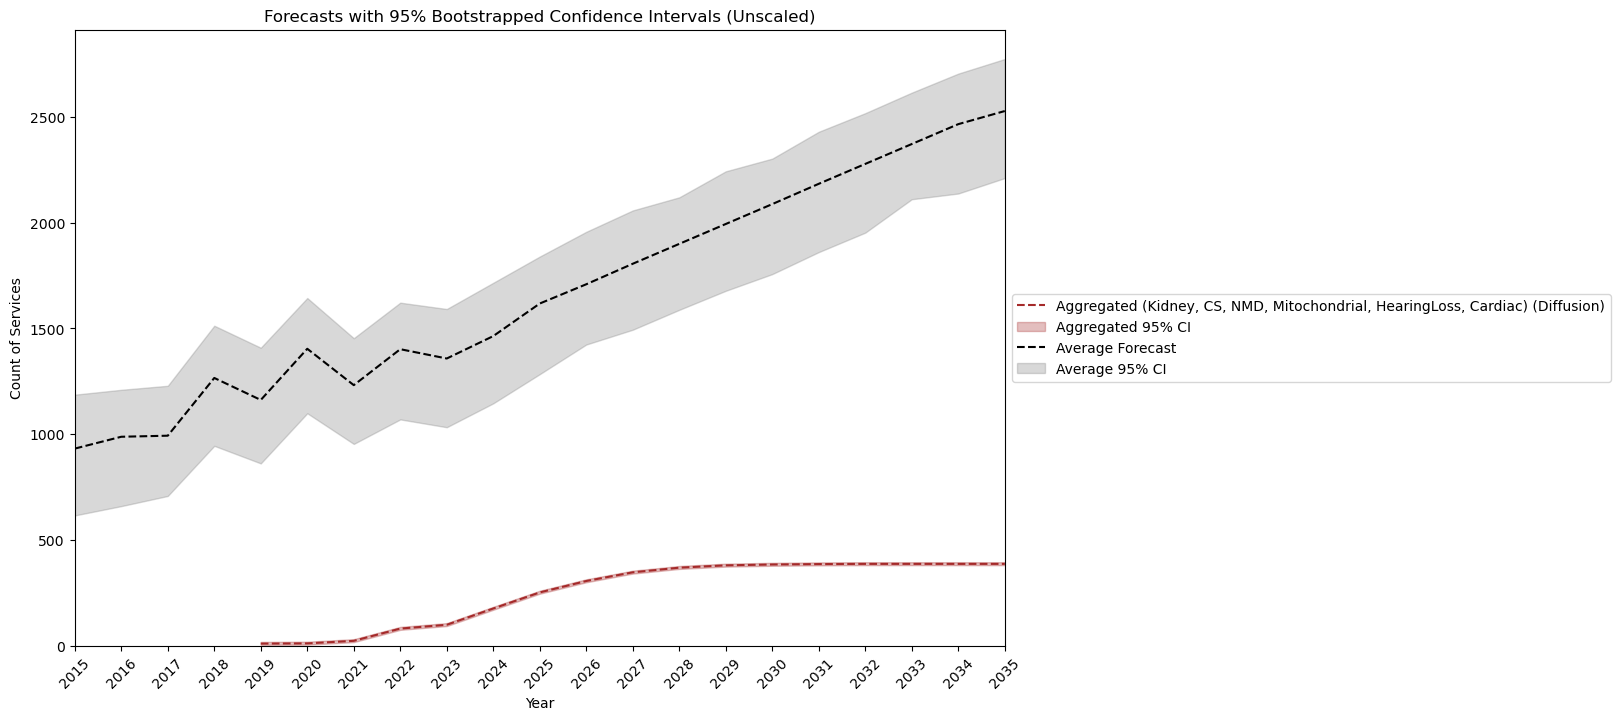

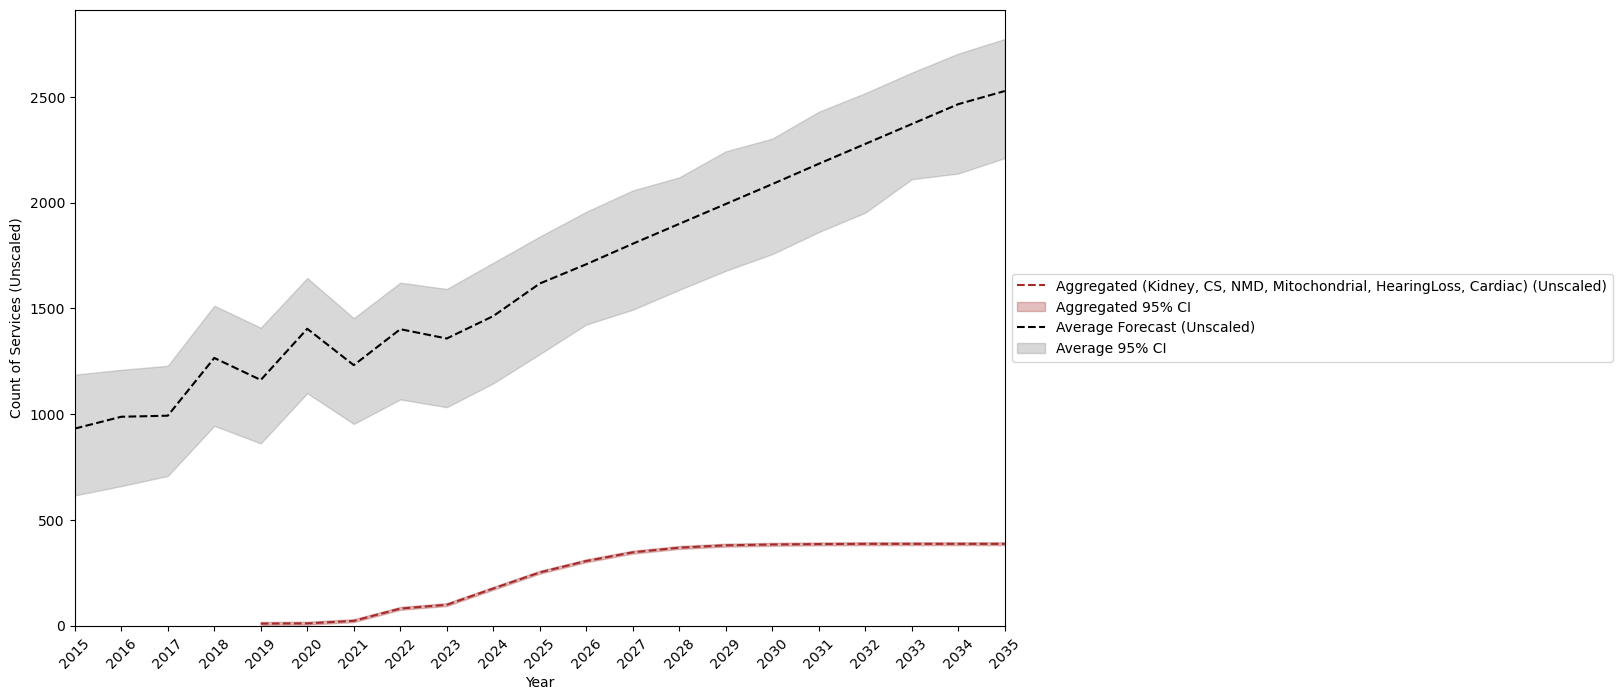

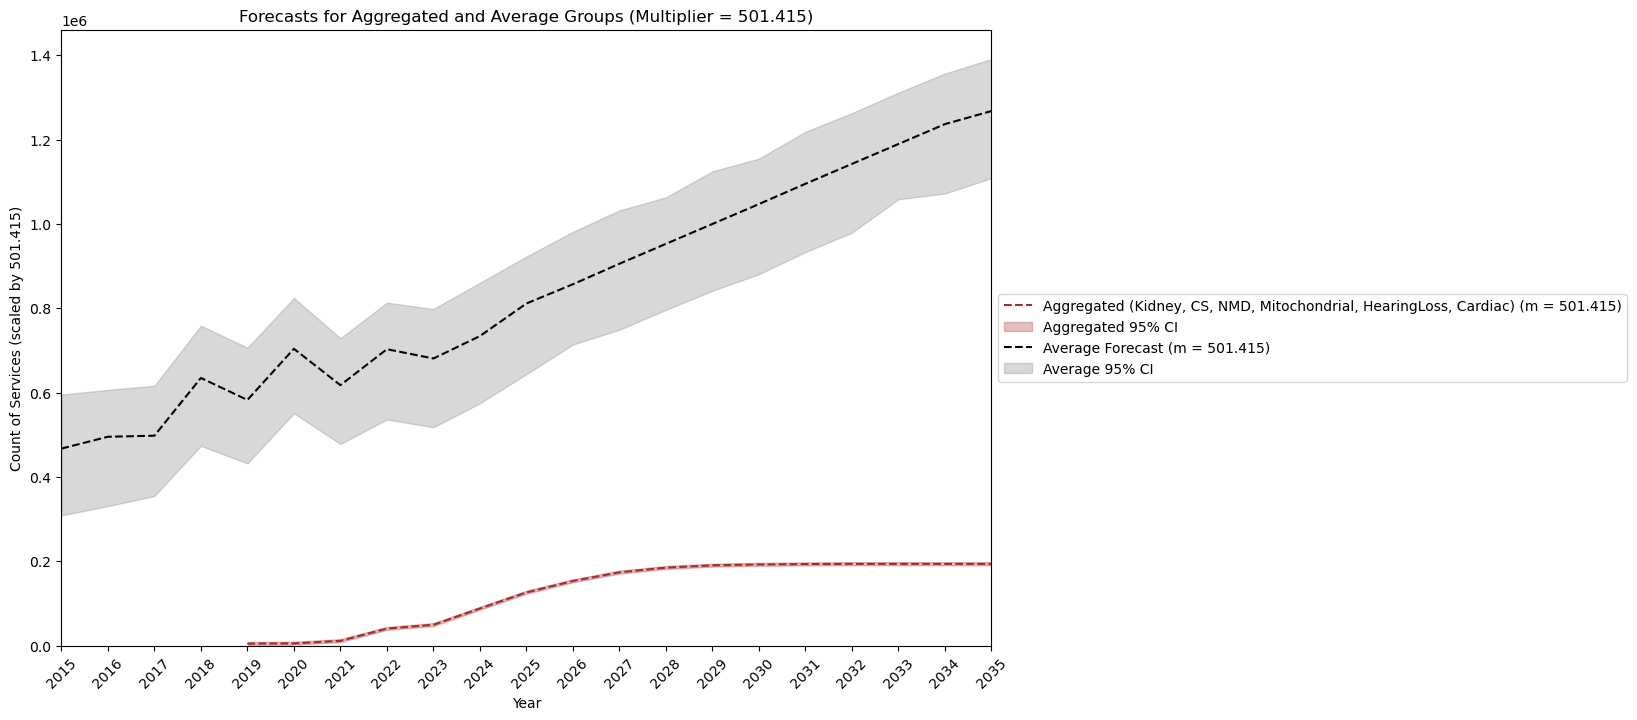

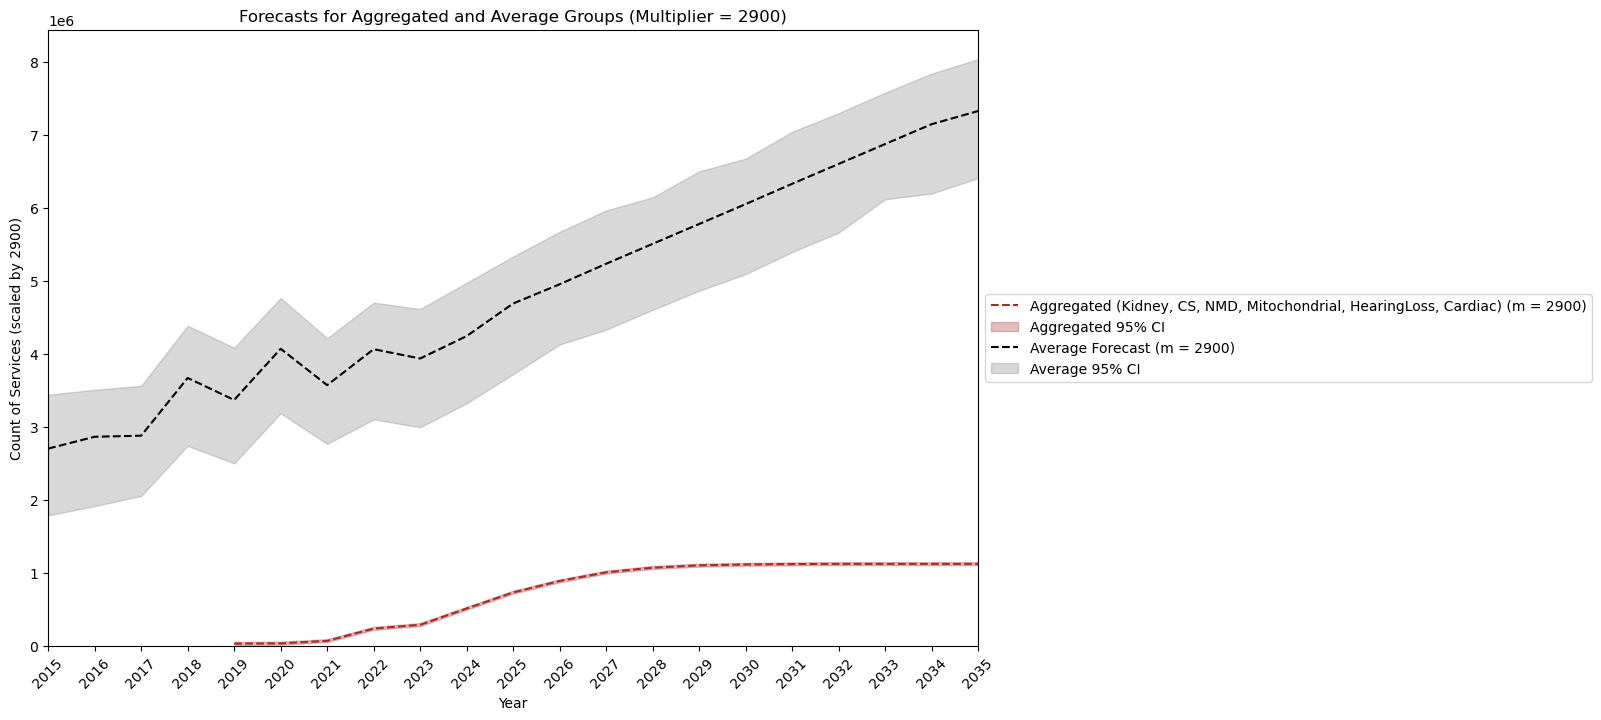

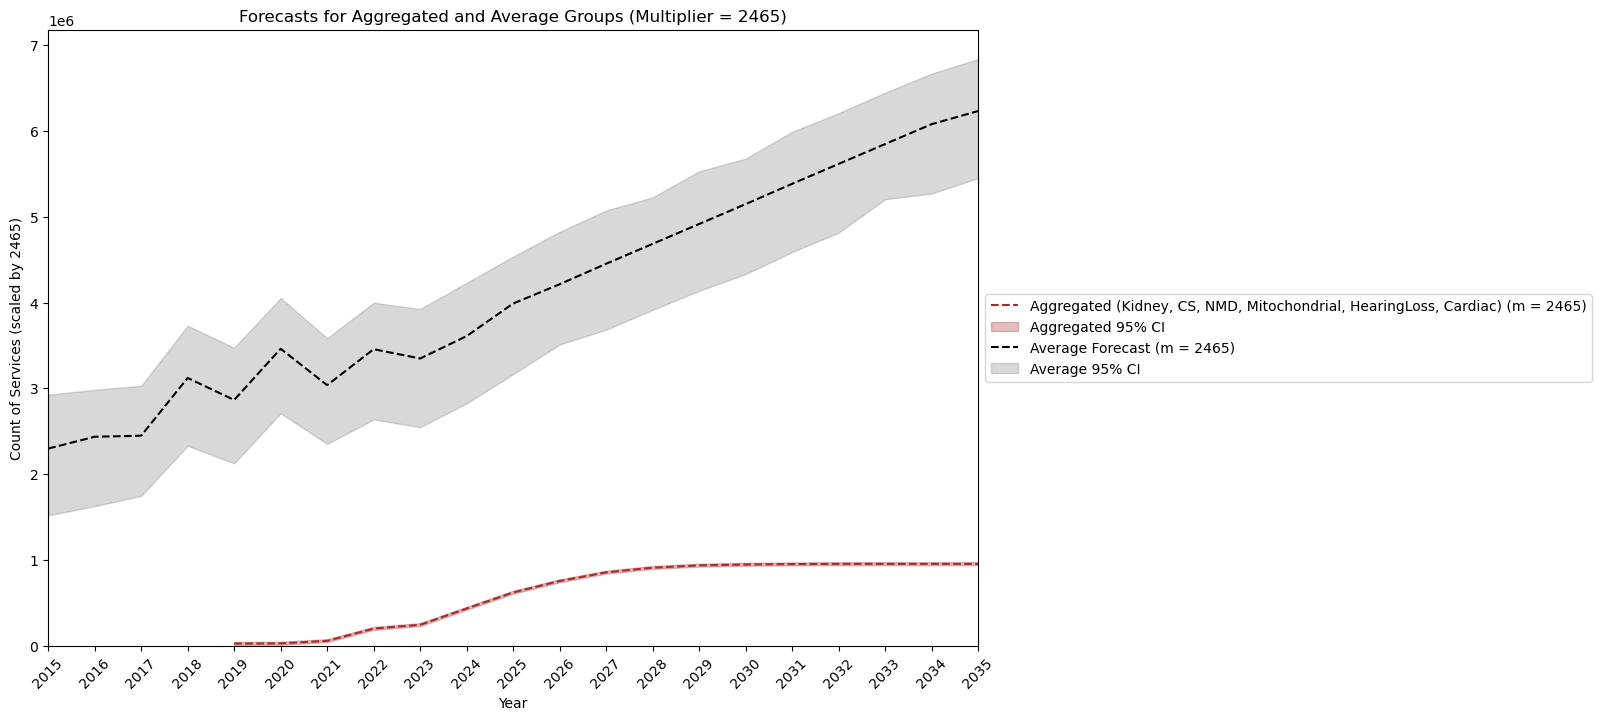

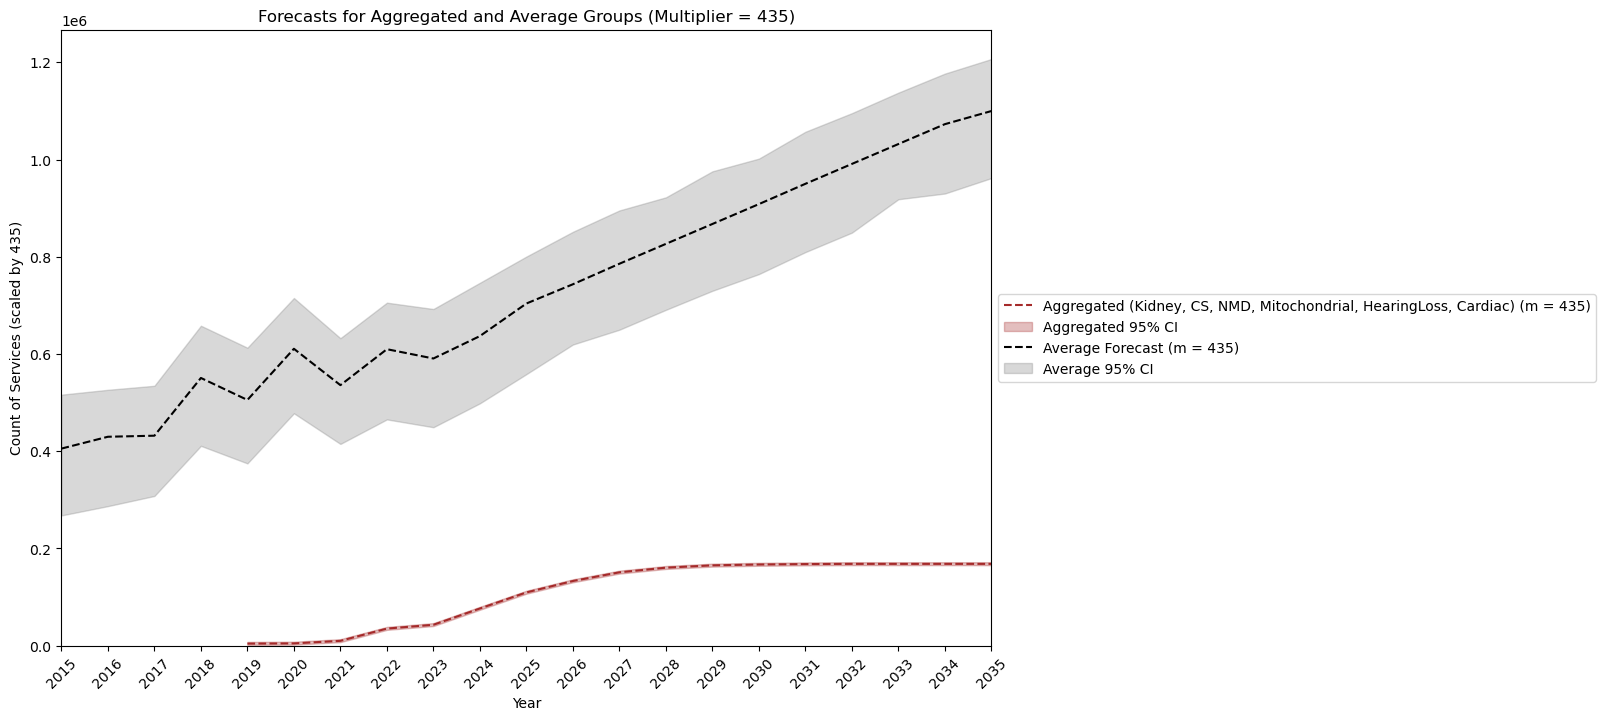

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filter warnings if desired
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=OptimizeWarning)

##########################
# Load and prepare the data
##########################
file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202410.feather"
data = pd.read_feather(file_path)
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

##########################
# Define groups and settings
##########################
group_definitions = {
    'Kidney': ['73298', '73401', '73402'],
    'CS': ['73358', '73359'],
    'NMD': ['73422'],
    'CMA': ['73292'],
    'FMR1': ['73300'],
    # Added new groups for Aggregated forecast:
    'Mitochondrial': ['73456', '73457', '73460'],    # Mitochondrial group
    'HearingLoss': ['73440', '73441', '73444'],       # Hearing Loss group
    'Cardiac': ['73416']                              # Cardiac group
}

color_map = {
    'CMA': 'red',
    'FMR1': 'blue'
}
agg_color = 'brown'  # color for aggregated secondary forecast

# Filter data for our items.
all_valid_items = [item for items in group_definitions.values() for item in items]
filtered_data = data[data['Item'].isin(all_valid_items)]

##########################
# Define model functions (Diffusion Models)
##########################
def logistic_diffusion(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def gompertz(t, a, b, c):
    return a * np.exp(-b * np.exp(-c * t))

def bass_diffusion(t, p, q, M):
    return M * (1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t))

##########################
# Forecasting for each group
##########################
best_predictions = []
diffusion_models = {
    "Logistic Diffusion": logistic_diffusion,
    "Gompertz": gompertz,
    "Bass Diffusion": bass_diffusion
}

for group, items in group_definitions.items():
    # Resample using month-end frequency and smooth.
    group_data = filtered_data[filtered_data['Item'].isin(items)]['Value'].resample('ME').sum().dropna()
    group_data = group_data.rolling(window=12, min_periods=1).mean()

    if group_data.empty:
        print(f"Group {group} has no data after processing. Skipping.")
        continue

    # Convert date index to decimal years (for fitting only).
    fitted_years = group_data.index.year + (group_data.index.month - 1) / 12.0

    results = {}
    max_val = group_data.max()
    mid_t = np.median(fitted_years)

    # --- Diffusion Models ---
    for model_name, model_func in diffusion_models.items():
        try:
            if model_name == "Gompertz":
                p0 = [max_val, 1.0, 0.1]
                bounds = (0, [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Logistic Diffusion":
                p0 = [max_val * 1.2, 0.1, mid_t]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            elif model_name == "Bass Diffusion":
                p0 = [0.01, 0.1, max_val * 1.2]
                bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
                params, _ = curve_fit(model_func, fitted_years, group_data,
                                      p0=p0, bounds=bounds, maxfev=10000)
            fitted_pred = model_func(fitted_years, *params)
            r2 = r2_score(group_data, fitted_pred)
            results[model_name] = {'r2': r2, 'params': params, 'func': model_func}
        except Exception as e:
            print(f"Error fitting {model_name} for group {group}: {e}")

    # --- SARIMA Model for CMA and FMR1 only ---
    if group in ["CMA", "FMR1"]:
        try:
            sarima_model = SARIMAX(group_data, order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_model.fit(disp=False)
            sarima_pred = sarima_fit.fittedvalues
            sarima_r2 = r2_score(group_data, sarima_pred)
            # Create forecast grid in whole years.
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years_sarima = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            forecast_index = pd.date_range(start=group_data.index[0],
                                           end=group_data.index[-1] + pd.DateOffset(years=10),
                                           freq='ME')
            sarima_forecast = sarima_fit.predict(start=group_data.index[0],
                                                 end=group_data.index[-1] + pd.DateOffset(years=10),
                                                 dynamic=False)
            sarima_forecast_interp = np.interp(forecast_years_sarima,
                                               forecast_index.year + (forecast_index.month - 1)/12.0,
                                               sarima_forecast.values)
            # Compute residuals for SARIMA using in-sample data.
            sarima_resid = group_data.values - sarima_pred
            results["SARIMA"] = {'r2': sarima_r2,
                                 'forecast_years': forecast_years_sarima,
                                 'forecast': sarima_forecast_interp,
                                 'residuals': sarima_resid}
        except Exception as e:
            print(f"Error fitting SARIMA for group {group}: {e}")

    # --- Select Best Model, Generate Forecast, and Compute Bootstrapped CIs ---
    if results:
        best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['r2'])
        if best_model_name == "SARIMA":
            forecast_years = best_model_metrics['forecast_years']
            best_pred_full = best_model_metrics['forecast']
            residuals = best_model_metrics.get('residuals')
        else:
            start_year_int = int(np.floor(fitted_years[0]))
            end_year_int = int(np.ceil(fitted_years[-1]))
            forecast_years = np.arange(start_year_int, end_year_int + 10 + 1, 1)
            best_pred_full = best_model_metrics['func'](forecast_years, *best_model_metrics['params'])
            residuals = group_data.values - best_model_metrics['func'](fitted_years, *best_model_metrics['params'])

        # Center the residuals before bootstrapping.
        resid_centered = residuals - np.mean(residuals)
        B = 500
        bootstrap_forecasts = np.zeros((B, len(forecast_years)))
        for b in range(B):
            boot_errors = np.random.choice(resid_centered, size=len(forecast_years), replace=True)
            bootstrap_forecasts[b, :] = best_pred_full + boot_errors
        ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

        # --- Round to whole numbers ---
        best_pred_full = np.rint(best_pred_full)
        ci_lower = np.rint(ci_lower)
        ci_upper = np.rint(ci_upper)

        entry = {
            'Group': group,
            'BestModel': best_model_name,
            'Years': forecast_years,
            'Predicted': best_pred_full,
            'CI_lower': ci_lower,
            'CI_upper': ci_upper
        }
        # For secondary groups, also store in-sample info.
        if group in ["Kidney", "CS", "NMD"]:
            entry['InSampleYears'] = fitted_years
            fitted_in_sample = best_model_metrics['func'](fitted_years, *best_model_metrics['params'])
            entry['InSampleFitted'] = np.rint(fitted_in_sample)
            entry['InSampleObserved'] = np.rint(group_data.values)
        # If desired, you could also save in-sample info for the new groups here.
        best_predictions.append(entry)

##########################
# Aggregated forecast for secondary groups 
# (Extended to include new groups: Mitochondrial, HearingLoss, and Cardiac)
##########################
secondary_group_list = ["Kidney", "CS", "NMD", "Mitochondrial", "HearingLoss", "Cardiac"]
secondary_preds = [bp for bp in best_predictions if bp['Group'] in secondary_group_list]
if secondary_preds:
    common_start = min(bp['Years'][0] for bp in secondary_preds)
    common_end = max(bp['Years'][-1] for bp in secondary_preds)
    common_time = np.arange(int(common_start), int(common_end) + 1, 1)

    aggregated_forecast = np.zeros_like(common_time, dtype=float)
    for bp in secondary_preds:
        aggregated_forecast += np.interp(common_time, bp['Years'], bp['Predicted'])
    # Compute aggregated in-sample residuals over the overlapping period.
    in_sample_starts = [bp['InSampleYears'][0] for bp in secondary_preds if 'InSampleYears' in bp]
    in_sample_ends = [bp['InSampleYears'][-1] for bp in secondary_preds if 'InSampleYears' in bp]
    if in_sample_starts and in_sample_ends:
        common_in_start = max(in_sample_starts)
        common_in_end = min(in_sample_ends)
        common_in_time = np.arange(int(np.floor(common_in_start)), int(np.ceil(common_in_end)) + 1, 1)
        aggregated_residuals = np.zeros_like(common_in_time, dtype=float)
        for bp in secondary_preds:
            # Only include those groups for which in-sample information exists
            if 'InSampleYears' in bp:
                obs_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleObserved'])
                fit_interp = np.interp(common_in_time, bp['InSampleYears'], bp['InSampleFitted'])
                aggregated_residuals += (obs_interp - fit_interp)

        # Center aggregated residuals.
        aggregated_resid_centered = aggregated_residuals - np.mean(aggregated_residuals)
        B = 500
        bootstrap_forecasts = np.zeros((B, len(common_time)))
        for b in range(B):
            boot_errors = np.random.choice(aggregated_resid_centered, size=len(common_time), replace=True)
            bootstrap_forecasts[b, :] = aggregated_forecast + boot_errors
        agg_ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
        agg_ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
    else:
        # Fallback if in-sample info is unavailable for some groups.
        agg_ci_lower = np.zeros_like(aggregated_forecast)
        agg_ci_upper = np.zeros_like(aggregated_forecast)

    # --- Round aggregated forecasts to whole numbers ---
    aggregated_forecast = np.rint(aggregated_forecast)
    agg_ci_lower = np.rint(agg_ci_lower)
    agg_ci_upper = np.rint(agg_ci_upper)

    aggregated_secondary_forecast = {
        'Group': 'Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)',
        'BestModel': "Diffusion",
        'Years': common_time,
        'Predicted': aggregated_forecast,
        'CI_lower': agg_ci_lower,
        'CI_upper': agg_ci_upper
    }
else:
    aggregated_secondary_forecast = None

##########################
# Extract forecasts for CMA and FMR1 and compute their average from 2015 onward
##########################
primary_forecasts = {bp['Group']: bp for bp in best_predictions if bp['Group'] in ["CMA", "FMR1"]}
if "CMA" in primary_forecasts and "FMR1" in primary_forecasts:
    years_cma = primary_forecasts["CMA"]['Years']
    pred_cma = primary_forecasts["CMA"]['Predicted']
    years_fmr1 = primary_forecasts["FMR1"]['Years']
    pred_fmr1 = primary_forecasts["FMR1"]['Predicted']

    common_start_avg = max(years_cma[0], years_fmr1[0], 2015)
    common_end_avg = min(years_cma[-1], years_fmr1[-1])
    common_years_avg = np.arange(int(common_start_avg), int(common_end_avg) + 1, 1)

    # Interpolate the forecasts onto the common grid.
    interp_cma = np.interp(common_years_avg, years_cma, pred_cma)
    interp_fmr1 = np.interp(common_years_avg, years_fmr1, pred_fmr1)
    avg_forecast = (interp_cma + interp_fmr1) / 2

    # For bootstrapping, compute in-sample residuals for each primary forecast.
    resid_cma = primary_forecasts["CMA"].get('residuals', primary_forecasts["CMA"]['Predicted'][:len(interp_cma)] - interp_cma)
    resid_fmr1 = primary_forecasts["FMR1"].get('residuals', primary_forecasts["FMR1"]['Predicted'][:len(interp_fmr1)] - interp_fmr1)
    # Center each set of residuals.
    resid_cma_centered = resid_cma - np.mean(resid_cma)
    resid_fmr1_centered = resid_fmr1 - np.mean(resid_fmr1)
    B = 500
    bootstrap_avg = np.zeros((B, len(common_years_avg)))
    for b in range(B):
        boot_error_cma = np.random.choice(resid_cma_centered, size=len(common_years_avg), replace=True)
        boot_error_fmr1 = np.random.choice(resid_fmr1_centered, size=len(common_years_avg), replace=True)
        boot_forecast_cma = interp_cma + boot_error_cma
        boot_forecast_fmr1 = interp_fmr1 + boot_error_fmr1
        bootstrap_avg[b, :] = (boot_forecast_cma + boot_forecast_fmr1) / 2
    avg_ci_lower = np.percentile(bootstrap_avg, 2.5, axis=0)
    avg_ci_upper = np.percentile(bootstrap_avg, 97.5, axis=0)

    # --- Round average forecasts to whole numbers ---
    avg_forecast = np.rint(avg_forecast)
    avg_ci_lower = np.rint(avg_ci_lower)
    avg_ci_upper = np.rint(avg_ci_upper)
else:
    raise ValueError("Forecasts for both CMA and FMR1 are required for averaging.")

##########################
# (Optional) Plotting the original forecasts (unscaled)
##########################
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    ax.plot(aggregated_secondary_forecast['Years'], aggregated_secondary_forecast['Predicted'],
            linestyle='--', color=agg_color,
            label=f"{aggregated_secondary_forecast['Group']} ({aggregated_secondary_forecast['BestModel']})")
    ax.fill_between(aggregated_secondary_forecast['Years'],
                    aggregated_secondary_forecast['CI_lower'],
                    aggregated_secondary_forecast['CI_upper'],
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
ax.plot(common_years_avg, avg_forecast, linestyle='--', color='black', linewidth=1.5, label="Average Forecast")
ax.fill_between(common_years_avg, avg_ci_lower, avg_ci_upper,
                color='gray', alpha=0.3, label="Average 95% CI")
global_start = min(common_years_avg[0],
                   aggregated_secondary_forecast['Years'][0] if aggregated_secondary_forecast is not None else common_years_avg[0])
global_end = max(common_years_avg[-1],
                 aggregated_secondary_forecast['Years'][-1] if aggregated_secondary_forecast is not None else common_years_avg[-1])
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services")
ax.set_title("Forecasts with 95% Bootstrapped Confidence Intervals (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()  # Uncomment to display the unscaled plot

##########################
# Generate table for Aggregated and Average Groups, scaled by each multiplier
##########################
# Multipliers now include unscaled (1) and 501.415 in addition to the previous ones.
multipliers = [1, 501.415, 2900, 2465, 435]
agg_group_name = 'Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)'  # Updated aggregated group name
avg_group_name = 'Average (CMA & FMR1)'
years_range = sorted(list(set(range(2025, 2036))))
table_data = {}

for year in years_range:
    row = {}
    # Process Aggregated Group.
    if aggregated_secondary_forecast is not None and year in aggregated_secondary_forecast['Years']:
        idx = np.where(aggregated_secondary_forecast['Years'] == year)[0][0]
        pred_val = aggregated_secondary_forecast['Predicted'][idx]
        ci_lower_val = aggregated_secondary_forecast['CI_lower'][idx]
        ci_upper_val = aggregated_secondary_forecast['CI_upper'][idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            # Multiply and convert to whole numbers.
            row[col_name] = f"{int(round(pred_val * m))} ({int(round(ci_lower_val * m))}, {int(round(ci_upper_val * m))})"
        # New column: Sum of multiplier 2465 and 501.415 for Aggregated group.
        sum_val = pred_val * 2465 + pred_val * 501.415
        sum_lower = ci_lower_val * 2465 + ci_lower_val * 501.415
        sum_upper = ci_upper_val * 2465 + ci_upper_val * 501.415
        row[f"{agg_group_name}_2465+501.415"] = f"{int(round(sum_val))} ({int(round(sum_lower))}, {int(round(sum_upper))})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{agg_group_name}_Unscaled"
            else:
                col_name = f"{agg_group_name}_{m}"
            row[col_name] = ""
        row[f"{agg_group_name}_2465+501.415"] = ""
    
    # Process Average Group.
    if year in common_years_avg:
        idx = np.where(common_years_avg == year)[0][0]
        pred_val = avg_forecast[idx]
        ci_lower_val = avg_ci_lower[idx]
        ci_upper_val = avg_ci_upper[idx]
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = f"{int(round(pred_val * m))} ({int(round(ci_lower_val * m))}, {int(round(ci_upper_val * m))})"
        # New column: Sum of multiplier 501.415 and 2465 for Average group.
        sum_val = pred_val * 501.415 + pred_val * 2465
        sum_lower = ci_lower_val * 501.415 + ci_lower_val * 2465
        sum_upper = ci_upper_val * 501.415 + ci_upper_val * 2465
        row[f"{avg_group_name}_501.415+2465"] = f"{int(round(sum_val))} ({int(round(sum_lower))}, {int(round(sum_upper))})"
    else:
        for m in multipliers:
            if m == 1:
                col_name = f"{avg_group_name}_Unscaled"
            else:
                col_name = f"{avg_group_name}_{m}"
            row[col_name] = ""
        row[f"{avg_group_name}_501.415+2465"] = ""
    
    table_data[year] = row

df_final = pd.DataFrame.from_dict(table_data, orient='index')
df_final.index.name = 'Year'
print(df_final)

##########################
# Create separate plots for:
# 1. Unscaled forecasts (m = 1)
# 2. Forecasts scaled with multiplier 501.415
# 3. Plots for the original multipliers: 2900, 2465, and 435
##########################

# 1. Unscaled Plot (m = 1)
m = 1
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (Unscaled)")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = np.rint(avg_forecast * m)
avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label="Average Forecast (Unscaled)")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel("Count of Services (Unscaled)")
#ax.set_title("Forecasts for Aggregated and Average Groups (Unscaled)")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 2. Plot with multiplier 501.415
m = 501.415
fig, ax = plt.subplots(figsize=(12, 8))
if aggregated_secondary_forecast is not None:
    years_agg = aggregated_secondary_forecast['Years']
    agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
    agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
    agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
    ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
            label=f"{agg_group_name} (m = {m})")
    ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                    color=agg_color, alpha=0.3, label="Aggregated 95% CI")
avg_pred_scaled = np.rint(avg_forecast * m)
avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
        label=f"Average Forecast (m = {m})")
ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                color='gray', alpha=0.3, label="Average 95% CI")
if aggregated_secondary_forecast is not None:
    global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
    global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
else:
    global_start = common_years_avg[0]
    global_end = common_years_avg[-1]
ax.set_xlim(global_start, global_end)
ax.set_ylim(bottom=0)
ax.set_xlabel("Year")
ax.set_ylabel(f"Count of Services (scaled by {m})")
ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
ax.set_xticks(np.arange(global_start, global_end + 1, 1))
ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 3. Plots for the original multipliers: 2900, 2465, and 435
for m in [2900, 2465, 435]:
    fig, ax = plt.subplots(figsize=(12, 8))
    if aggregated_secondary_forecast is not None:
        years_agg = aggregated_secondary_forecast['Years']
        agg_pred_scaled = np.rint(aggregated_secondary_forecast['Predicted'] * m)
        agg_ci_lower_scaled = np.rint(aggregated_secondary_forecast['CI_lower'] * m)
        agg_ci_upper_scaled = np.rint(aggregated_secondary_forecast['CI_upper'] * m)
        ax.plot(years_agg, agg_pred_scaled, linestyle='--', color=agg_color,
                label=f"{agg_group_name} (m = {m})")
        ax.fill_between(years_agg, agg_ci_lower_scaled, agg_ci_upper_scaled,
                        color=agg_color, alpha=0.3, label="Aggregated 95% CI")
    avg_pred_scaled = np.rint(avg_forecast * m)
    avg_ci_lower_scaled = np.rint(avg_ci_lower * m)
    avg_ci_upper_scaled = np.rint(avg_ci_upper * m)
    ax.plot(common_years_avg, avg_pred_scaled, linestyle='--', color='black', linewidth=1.5,
            label=f"Average Forecast (m = {m})")
    ax.fill_between(common_years_avg, avg_ci_lower_scaled, avg_ci_upper_scaled,
                    color='gray', alpha=0.3, label="Average 95% CI")
    if aggregated_secondary_forecast is not None:
        global_start = min(common_years_avg[0], aggregated_secondary_forecast['Years'][0])
        global_end = max(common_years_avg[-1], aggregated_secondary_forecast['Years'][-1])
    else:
        global_start = common_years_avg[0]
        global_end = common_years_avg[-1]
    ax.set_xlim(global_start, global_end)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Count of Services (scaled by {m})")
    ax.set_title(f"Forecasts for Aggregated and Average Groups (Multiplier = {m})")
    ax.set_xticks(np.arange(global_start, global_end + 1, 1))
    ax.set_xticklabels(np.arange(global_start, global_end + 1, 1), rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [79]:
df_final

Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)_Unscaled  \
Year                                                                              
2025                                     252 (246, 260)                           
2026                                     306 (300, 314)                           
2027                                     347 (341, 355)                           
2028                                     369 (363, 377)                           
2029                                     380 (374, 388)                           
2030                                     384 (378, 392)                           
2031                                     386 (380, 394)                           
2032                                     387 (381, 395)                           
2033                                     387 (381, 395)                           
2034                                     387 (381, 395)                           
2035                                     387 (381, 395)                           

     Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)_501.415  \
Year                                                                             
2025                            126357 (123348, 130368)                          
2026                            153433 (150424, 157444)                          
2027                            173991 (170983, 178002)                          
2028                            185022 (182014, 189033)                          
2029                            190538 (187529, 194549)                          
2030                            192543 (189535, 196555)                          
2031                            193546 (190538, 197558)                          
2032                            194048 (191039, 198059)                          
2033                            194048 (191039, 198059)                          
2034                            194048 (191039, 198059)                          
2035                            194048 (191039, 198059)                          

     Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)_2900  \
Year                                                                          
2025                            730800 (713400, 754000)                       
2026                            887400 (870000, 910600)                       
2027                          1006300 (988900, 1029500)                       
2028                         1070100 (1052700, 1093300)                       
2029                         1102000 (1084600, 1125200)                       
2030                         1113600 (1096200, 1136800)                       
2031                         1119400 (1102000, 1142600)                       
2032                         1122300 (1104900, 1145500)                       
2033                         1122300 (1104900, 1145500)                       
2034                         1122300 (1104900, 1145500)                       
2035                         1122300 (1104900, 1145500)                       

     Aggregated (Kidney, CS, NMD, Mitochondrial, HearingLoss, Cardiac)_2465  \
Year                                                                          
2025                            621180 (606390, 640900)                       
2026                            754290 (739500, 774010)                       
2027                            855355 (840565, 875075)                       
2028                            909585 (894795, 929305)                       
2029                            936700 (921910, 956420)                       
2030                            946560 (931770, 966280)                       
2031                            951490 (936700, 971210)                       
2032                            953955 (939165, 973675)                       
2033                            953955 (